# Sequence to Sequence Modelling

**Note**: All code should be in Python3. Keras version should be 2.0.4. The directory structure on the bitbucket repo should be exactly same as the hw4.zip provided to you (with the exception of data directory. Do not upload it). To push the code to remote repo, use the same instructions as given in HW0. **Double check you remote repo for correct directory structure. We won't consider any regrade requests based on wrong directory structure penalty. Again, do not upload data to your bitbucket repo ** <br>
**The data provided to you should not be used for any other purpose than this course. You must not distribute it or upload it to any public platform.**

![title](seq2seq.png)

In this assignment, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

# Preparing Inputs

In [1]:
from os import listdir
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, Input, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda, Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
#from keras import initializers
from keras import backend as K
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras import optimizers
import numpy as np
from attention_decoder import AttentionDecoder

Using TensorFlow backend.


## <span style="color:red"> !!! The version of Keras and Tensorflow !!! </span>   
<span style="color:red">The Keras version is 2.0.9, while tensorflow version is 14.0</span>

The first part of the assignment is to prepare data. You are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. You will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get you started and we recommend experimenting, to improve your scores after you are done with your first implementation)

In [353]:
MAX_LEN = 33 #count_sum = np.max(np.count_nonzero(summary_pad, axis=1)) + 1

VOCAB_SIZE = 20000

Write a function which takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number of indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

In [354]:
def _tokenize_(text, val = None):
        tokenizer = Tokenizer(filters='-\t\n')
        sub_text = [_.replace("<unk>", "<UNK>") for _ in text]
        if val:
            sub_val = [_.replace("<unk>", "<UNK>") for _ in val]
        else:
            sub_val = sub_text
        tokenizer.fit_on_texts(sub_text)  ## unk included
        return tokenizer, sub_val

In [355]:
def load_data(article, summary, max_len, vocab_size):
    ######################### article ###############################3
    # create idx2word
    print("Creating article's idx2word ...")
    #tokenizer = Tokenizer()
    #sub_article = [_.replace("<unk>", "UNK") for _ in article]
    #tokenizer.fit_on_texts(sub_article)  ## unk included
    tokenizer, sub_article = _tokenize_(article)
    word_counts = tokenizer.word_counts
    idx2word_art = []
    idx2word_art.append("ZERO")
    idx2word_art += sorted(word_counts, key=lambda k: word_counts[k], reverse=True)[:vocab_size]
    print("The vocabulary size of article is {}".format(len(idx2word_art)))
    #create word2idx
    print("Creating article's word2idx ...")
    word2idx_art =  {k: tokenizer.word_index[k] for k in idx2word_art[1:]}
    word2idx_art['ZERO'] = 0
    #Convert the words in the article, unknown words to unk
    print("Converting Article to index..")
    temp = tokenizer.texts_to_sequences(sub_article)
    trans_article = [[tokenizer.word_index['<unk>'] if x > vocab_size else x for x in row] for row in temp]
    # Padding
    print("Padding the sentence..")
    article_pad = sequence.pad_sequences(trans_article, maxlen=max_len, padding='post', truncating='post') # truncate the end
    
    ######################### summary ###############################3
    # create idx2word
    print("Creating summary's idx2word ...")
    #tokenizer = Tokenizer()
    #sub_summary = [_.replace("<unk>", "UNK") for _ in summary]
    #tokenizer.fit_on_texts(sub_summary)  ## unk included
    tokenizer, sub_summary = _tokenize_(summary)
    word_counts = tokenizer.word_counts
    idx2word_sum = []
    idx2word_sum.append("ZERO")
    idx2word_sum += sorted(word_counts, key=lambda k: word_counts[k], reverse=True)[:(vocab_size-1)]
    idx2word_sum.append("<s>")
    print("The vocabulary size of summary is {}".format(len(idx2word_sum)))
    #create word2idx
    print("Creating summary's word2idx ... ")
    word2idx_sum =  {k: tokenizer.word_index[k] for k in idx2word_sum[1:-1]}
    word2idx_sum['ZERO'] = 0
    word2idx_sum['<s>'] = vocab_size
    #word2idx_sum['<eos>'] = vocab_size
    #Convert the words in the article, unknown words to unk
    print("Converting Summary to index..")
    temp = tokenizer.texts_to_sequences(sub_summary)
    trans_summary = [[tokenizer.word_index['<unk>'] if x > vocab_size else x for x in row] for row in temp]
    # Padding
    print("Padding the sentence..")
    summary_pad = sequence.pad_sequences(trans_summary, maxlen= (max_len-1), padding='post', truncating='post')
    # add <s> and <eos> to the start and end of the summary respectively
    summary_pad = np.insert(summary_pad, 0, word2idx_sum['<s>'], axis=1)
    
    
    return article_pad,len(idx2word_art), idx2word_art, word2idx_art, summary_pad,len(idx2word_sum), idx2word_sum, word2idx_sum

Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

In [356]:
# loading data
with open("data/train_article.txt") as f:
    train_article = f.readlines()
with open("data/train_title.txt") as f:
    train_title = f.readlines()
with open("data/test_article.txt") as f:
    test_article = f.readlines()
with open("data/test_title.txt") as f:
    test_title = f.readlines()
# get padding dataset
article_pad,vocab_art, idx2word_art, word2idx_art, summary_pad,vocab_sum, \
idx2word_sum, word2idx_sum = load_data(train_article, train_title, MAX_LEN, VOCAB_SIZE)
# transform test data using train word2vec
print("Transform test data...")
tokenizer, sub_test_article = _tokenize_(train_article, test_article)
temp = tokenizer.texts_to_sequences(sub_test_article)
trans_test_article = [[tokenizer.word_index['<unk>'] if x > VOCAB_SIZE else x for x in row] for row in temp]
test_article_pad = sequence.pad_sequences(trans_test_article, maxlen=MAX_LEN, padding='post', truncating='post')
# one-hot vectorize train_title
#print("Vectorize train title..")
#title_vec = np_utils.to_categorical(trans_summary)

Creating article's idx2word ...
The vocabulary size of article is 20001
Creating article's word2idx ...
Converting Article to index..
Padding the sentence..
Creating summary's idx2word ...
The vocabulary size of summary is 20001
Creating summary's word2idx ... 
Converting Summary to index..
Padding the sentence..
Transform test data...


In [357]:
# get the maximum length of articles and summaries
count_art = np.max(np.count_nonzero(article_pad, axis=1))
count_sum = np.max(np.count_nonzero(summary_pad, axis=1))
print("The maximum length of artitles is {}, while that of summaries is {}".format(count_art, count_sum))

The maximum length of artitles is 24, while that of summaries is 33


In [358]:
# one-hot vectorize inputs (batch_size, max_len , vocab_size)
##encoder_input_data = np.zeros( (500, count_art, VOCAB_SIZE), dtype='float64')
# load GloVe vectors
import codecs
EMBED_SIZE = 300
#load glove embeddings
gembeddings_index = {}
with codecs.open('glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        gembedding = np.asarray(values[1:], dtype='float32')
        gembeddings_index[word] = gembedding
#
f.close()
print('G Word embeddings:', len(gembeddings_index))
embedding_weights = np.zeros(((VOCAB_SIZE+1), EMBED_SIZE))
missing = 0
for word, index in word2idx_art.items():
    try:
        embedding_weights[index, :] = gembeddings_index[word]
    except KeyError:
        #print(word)
        missing += 1
        pass
print('G Null word embeddings: %d' %missing)

G Word embeddings: 14050
G Null word embeddings: 9960


In [359]:
## for title set
print('G Word embeddings:', len(gembeddings_index))
embedding_weights_sum = np.zeros(((VOCAB_SIZE+1), EMBED_SIZE))
missing = 0
for word, index in word2idx_sum.items():
    try:
        embedding_weights_sum[index, :] = gembeddings_index[word]
    except KeyError:
        #print(word)
        missing += 1
        pass
print('G Null word embeddings: %d' %missing)

G Word embeddings: 14050
G Null word embeddings: 10633


# Unidirectional LSTM Encoder Decoder 

Define the parameters for your LSTM encoder decoder model. 

In [371]:
BATCH_SIZE = 64
NUM_LAYERS = (1,1)
HIDDEN_DIM = 256 
EPOCHS = 25

Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [352]:
def create_UniLSTM(X_vocab_len, X_max_len,y_vocab_len, y_max_len, hidden_size, num_layers = (1,1)):
    max_len = max(X_max_len, y_max_len)
    embed_dim = embedding_weights.shape[1]
    # create and return the model for unidirectional LSTM encoder decoder
    encoder_inputs = Input(shape=(max_len,))
    # to get shape(?,?,vocab_len)
    embedder = Embedding(embedding_weights.shape[0], embed_dim, input_length = max_len, weights = [embedding_weights],
                     mask_zero= True)(encoder_inputs)
    encoder = LSTM(hidden_size, input_shape = (max_len,embed_dim), return_state=True)
    encoder_outputs, state_h, state_c = encoder(embedder)
    # just use the states 
    encoder_states = [state_h, state_c]
    
    # decode inputs
    decoder_inputs = Input(shape=(None, y_vocab_len))
    decoder_lstm = LSTM(hidden_size,  return_state=True , return_sequences=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
    decoder_dense = Dense(y_vocab_len, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # model: `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(loss='categorical_crossentropy', optimizer= 'rmsprop', metrics=[ 'accuracy' ])
    
    # inference
    bst_encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(HIDDEN_DIM,))
    decoder_state_input_c = Input(shape=(HIDDEN_DIM,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    ##decoder_lstm = LSTM(hidden_size, return_sequences=True)(decoder_inputs, initial_state=decoder_states_inputs)
    ##decoder_outputs, state_h, state_c = LSTM(hidden_size,  return_state=True , return_sequences=True)(decoder_lstm)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

In [363]:
model, encoder_model, decoder_model = create_UniLSTM(VOCAB_SIZE+1, count_art, VOCAB_SIZE+1, count_sum, HIDDEN_DIM)

In [380]:
plain_model = model
plain_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 33)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 33, 300)      6000300     input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, None, 20001)  0                                            
__________________________________________________________________________________________________
lstm_13 (LSTM)                  [(None, 256), (None, 570368      embedding_6[0][0]                
__________________________________________________________________________________________________
lstm_14 (L

# Train the Model

Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

In [365]:
def __data_generation():
        for i in range(len(article_pad)//500):
            ## batch size
            X_train, y_trian = article_pad[i*500:(i+1)*500], summary_pad[i*500:(i+1)*500]
            # one-hot y
            decoder_input_data = np.zeros((len(y_trian), count_sum, vocab_sum),
                                          dtype='float64')
            decoder_target_data = np.zeros((len(y_trian), count_sum,vocab_sum),
                                           dtype='float64')
            ## construct decoder data
            for k, target_text in enumerate(y_trian):
                for t, ind in enumerate(target_text):
                    # decoder_target_data is ahead of decoder_input_data by one timestep
                    decoder_input_data[k, t, ind] = 1.
                    if t > 0:
                        # decoder_target_data will be ahead by one timestep
                        # and will not include the start character.
                        decoder_target_data[k, t - 1, ind] = 1.
            yield X_train, decoder_input_data, decoder_target_data 

In [372]:
# checkpoint
filepath="weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, mode='max')
callbacks_list = [checkpoint]

for i in range(EPOCHS):
    print("epochs %d" % i)
    times = 0
    for X_train, Y_train_input, Y_train_target in __data_generation():
        times += 1
        print("samples %d" % times)
        plain_model.fit([X_train, Y_train_input], Y_train_target, batch_size= 64, epochs= 1, validation_split=0.2, 
              callbacks=callbacks_list)

epochs 0
samples 1
Train on 400 samples, validate on 100 samples
Epoch 1/1
384/400 [===========================>..] - ETA: 0s - loss: 1.7753 - acc: 0.7688

/usr/local/lib/python3.4/dist-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_14 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_13/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_13/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


400/400 [==============================] - 10s 25ms/step - loss: 1.7770 - acc: 0.7687 - val_loss: 1.9199 - val_acc: 0.7512
samples 2
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 17s 43ms/step - loss: 1.6894 - acc: 0.7797 - val_loss: 1.8937 - val_acc: 0.7733
samples 3
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.6817 - acc: 0.7842 - val_loss: 1.8129 - val_acc: 0.7794
samples 4
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 17s 42ms/step - loss: 1.5203 - acc: 0.8007 - val_loss: 0.9847 - val_acc: 0.8579
samples 5
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.2820 - acc: 0.8207 - val_loss: 1.7098 - val_acc: 0.7821
samples 6
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 23ms/step 

400/400 [==============================] - 9s 24ms/step - loss: 1.0176 - acc: 0.8503 - val_loss: 1.0725 - val_acc: 0.8452
samples 45
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.3132 - acc: 0.8115 - val_loss: 1.6778 - val_acc: 0.7812
samples 46
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.5936 - acc: 0.7821 - val_loss: 1.7056 - val_acc: 0.7691
samples 47
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.6382 - acc: 0.7755 - val_loss: 1.7035 - val_acc: 0.7912
samples 48
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 23ms/step - loss: 1.6118 - acc: 0.7868 - val_loss: 1.6548 - val_acc: 0.7924
samples 49
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/ste

400/400 [==============================] - 8s 21ms/step - loss: 0.9599 - acc: 0.8602 - val_loss: 1.1575 - val_acc: 0.8309
samples 88
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.0249 - acc: 0.8483 - val_loss: 1.6013 - val_acc: 0.7842
samples 89
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.5236 - acc: 0.7899 - val_loss: 1.5512 - val_acc: 0.7867
samples 90
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.6474 - acc: 0.7767 - val_loss: 1.9355 - val_acc: 0.7458
samples 91
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.5465 - acc: 0.7892 - val_loss: 1.6588 - val_acc: 0.7924
samples 92
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/s

400/400 [==============================] - 10s 26ms/step - loss: 1.6416 - acc: 0.7830 - val_loss: 1.8200 - val_acc: 0.7773
samples 31
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.6832 - acc: 0.7788 - val_loss: 1.5645 - val_acc: 0.8064
samples 32
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 11s 26ms/step - loss: 0.8939 - acc: 0.8673 - val_loss: 1.2369 - val_acc: 0.8388
samples 33
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.4753 - acc: 0.7954 - val_loss: 1.7117 - val_acc: 0.7885
samples 34
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 26ms/step - loss: 1.6144 - acc: 0.7758 - val_loss: 1.5401 - val_acc: 0.8036
samples 35
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/s

400/400 [==============================] - 8s 21ms/step - loss: 1.3836 - acc: 0.8063 - val_loss: 1.5586 - val_acc: 0.7939
samples 74
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 24ms/step - loss: 1.5135 - acc: 0.7870 - val_loss: 1.8022 - val_acc: 0.7609
samples 75
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.5250 - acc: 0.7877 - val_loss: 1.7335 - val_acc: 0.7697
samples 76
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.5516 - acc: 0.7958 - val_loss: 1.6246 - val_acc: 0.7924
samples 77
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.5728 - acc: 0.7925 - val_loss: 1.6945 - val_acc: 0.7842
samples 78
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 11s 29ms/st

400/400 [==============================] - 10s 25ms/step - loss: 1.4553 - acc: 0.7948 - val_loss: 1.5800 - val_acc: 0.7955
samples 17
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.6071 - acc: 0.7783 - val_loss: 1.7255 - val_acc: 0.7724
samples 18
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.6029 - acc: 0.7900 - val_loss: 1.7358 - val_acc: 0.7876
samples 19
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.6161 - acc: 0.7858 - val_loss: 1.7788 - val_acc: 0.7836
samples 20
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 26ms/step - loss: 1.3302 - acc: 0.8207 - val_loss: 0.8804 - val_acc: 0.8730
samples 21
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/s

400/400 [==============================] - 8s 21ms/step - loss: 1.4009 - acc: 0.7998 - val_loss: 1.5536 - val_acc: 0.7891
samples 60
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 26ms/step - loss: 1.5555 - acc: 0.7784 - val_loss: 1.6363 - val_acc: 0.7882
samples 61
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.4607 - acc: 0.7964 - val_loss: 1.8129 - val_acc: 0.7727
samples 62
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 11s 26ms/step - loss: 1.5028 - acc: 0.7964 - val_loss: 1.7404 - val_acc: 0.7861
samples 63
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.5503 - acc: 0.7912 - val_loss: 1.3088 - val_acc: 0.8300
samples 64
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 26ms/s

400/400 [==============================] - 9s 23ms/step - loss: 1.5376 - acc: 0.7905 - val_loss: 1.8141 - val_acc: 0.7800
samples 3
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.5524 - acc: 0.7916 - val_loss: 1.7921 - val_acc: 0.7833
samples 4
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.3758 - acc: 0.8139 - val_loss: 0.8318 - val_acc: 0.8770
samples 5
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.0738 - acc: 0.8412 - val_loss: 1.6030 - val_acc: 0.7927
samples 6
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 24ms/step - loss: 1.4742 - acc: 0.7913 - val_loss: 1.3474 - val_acc: 0.8233
samples 7
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - l

400/400 [==============================] - 8s 21ms/step - loss: 1.1473 - acc: 0.8293 - val_loss: 1.5911 - val_acc: 0.7885
samples 46
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 24ms/step - loss: 1.4254 - acc: 0.7945 - val_loss: 1.5993 - val_acc: 0.7797
samples 47
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.4675 - acc: 0.7880 - val_loss: 1.6518 - val_acc: 0.7936
samples 48
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.4959 - acc: 0.7954 - val_loss: 1.6096 - val_acc: 0.7933
samples 49
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.5142 - acc: 0.7905 - val_loss: 1.8060 - val_acc: 0.7758
samples 50
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 23ms/ste

400/400 [==============================] - 10s 26ms/step - loss: 0.8594 - acc: 0.8662 - val_loss: 1.5604 - val_acc: 0.7909
samples 89
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.3180 - acc: 0.8059 - val_loss: 1.4816 - val_acc: 0.7958
samples 90
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.4403 - acc: 0.7937 - val_loss: 1.8797 - val_acc: 0.7533
samples 91
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3504 - acc: 0.8045 - val_loss: 1.6454 - val_acc: 0.7927
samples 92
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.5193 - acc: 0.7955 - val_loss: 1.6619 - val_acc: 0.7897
samples 93
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/s

400/400 [==============================] - 8s 21ms/step - loss: 1.5754 - acc: 0.7866 - val_loss: 1.5226 - val_acc: 0.8106
samples 32
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 11s 27ms/step - loss: 0.7671 - acc: 0.8840 - val_loss: 1.1721 - val_acc: 0.8473
samples 33
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.3310 - acc: 0.8107 - val_loss: 1.6721 - val_acc: 0.7912
samples 34
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 11s 29ms/step - loss: 1.4593 - acc: 0.7927 - val_loss: 1.4751 - val_acc: 0.8076
samples 35
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.4837 - acc: 0.7959 - val_loss: 1.8412 - val_acc: 0.7836
samples 36
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/s

400/400 [==============================] - 10s 24ms/step - loss: 1.3464 - acc: 0.8008 - val_loss: 1.7680 - val_acc: 0.7642
samples 75
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3492 - acc: 0.8026 - val_loss: 1.7023 - val_acc: 0.7773
samples 76
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 23ms/step - loss: 1.4149 - acc: 0.8047 - val_loss: 1.6241 - val_acc: 0.7936
samples 77
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.4411 - acc: 0.8010 - val_loss: 1.6816 - val_acc: 0.7864
samples 78
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 11s 28ms/step - loss: 1.4730 - acc: 0.7967 - val_loss: 0.6601 - val_acc: 0.8967
samples 79
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/st

400/400 [==============================] - 8s 21ms/step - loss: 1.4739 - acc: 0.7895 - val_loss: 1.6775 - val_acc: 0.7821
samples 18
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.4988 - acc: 0.7975 - val_loss: 1.7203 - val_acc: 0.7873
samples 19
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.5167 - acc: 0.7930 - val_loss: 1.7357 - val_acc: 0.7858
samples 20
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.2225 - acc: 0.8301 - val_loss: 0.8343 - val_acc: 0.8827
samples 21
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.0129 - acc: 0.8506 - val_loss: 1.7473 - val_acc: 0.7758
samples 22
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step

400/400 [==============================] - 9s 23ms/step - loss: 1.4213 - acc: 0.7912 - val_loss: 1.6074 - val_acc: 0.7882
samples 61
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.3497 - acc: 0.8084 - val_loss: 1.8042 - val_acc: 0.7742
samples 62
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 23ms/step - loss: 1.3816 - acc: 0.8039 - val_loss: 1.7384 - val_acc: 0.7897
samples 63
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.4329 - acc: 0.8004 - val_loss: 1.3000 - val_acc: 0.8312
samples 64
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.6766 - acc: 0.8936 - val_loss: 0.8810 - val_acc: 0.8742
samples 65
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 9s 22ms/step - loss: 1.4633 - acc: 0.7996 - val_loss: 1.7899 - val_acc: 0.7821
samples 4
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 26ms/step - loss: 1.2800 - acc: 0.8243 - val_loss: 0.7676 - val_acc: 0.8839
samples 5
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 0.9704 - acc: 0.8556 - val_loss: 1.5626 - val_acc: 0.7976
samples 6
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.3466 - acc: 0.8047 - val_loss: 1.3325 - val_acc: 0.8248
samples 7
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.4584 - acc: 0.8030 - val_loss: 1.8023 - val_acc: 0.7818
samples 8
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step -

400/400 [==============================] - 11s 27ms/step - loss: 1.3097 - acc: 0.8082 - val_loss: 1.5854 - val_acc: 0.7821
samples 47
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3474 - acc: 0.8006 - val_loss: 1.6481 - val_acc: 0.7955
samples 48
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.4007 - acc: 0.8027 - val_loss: 1.6093 - val_acc: 0.7927
samples 49
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.4116 - acc: 0.7998 - val_loss: 1.8137 - val_acc: 0.7773
samples 50
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 11s 27ms/step - loss: 1.0341 - acc: 0.8511 - val_loss: 0.8691 - val_acc: 0.8773
samples 51
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/s

400/400 [==============================] - 8s 21ms/step - loss: 1.1966 - acc: 0.8202 - val_loss: 1.4682 - val_acc: 0.7982
samples 90
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.3119 - acc: 0.8070 - val_loss: 1.8781 - val_acc: 0.7573
samples 91
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.2335 - acc: 0.8172 - val_loss: 1.6626 - val_acc: 0.7912
samples 92
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.4097 - acc: 0.8027 - val_loss: 1.6721 - val_acc: 0.7879
samples 93
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.4398 - acc: 0.7978 - val_loss: 1.6121 - val_acc: 0.7909
samples 94
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/s

400/400 [==============================] - 10s 24ms/step - loss: 0.6944 - acc: 0.8942 - val_loss: 1.1743 - val_acc: 0.8494
samples 33
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2380 - acc: 0.8219 - val_loss: 1.6747 - val_acc: 0.7936
samples 34
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.3590 - acc: 0.8045 - val_loss: 1.4816 - val_acc: 0.8082
samples 35
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.4037 - acc: 0.8067 - val_loss: 1.8570 - val_acc: 0.7806
samples 36
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.4190 - acc: 0.8065 - val_loss: 1.8173 - val_acc: 0.7803
samples 37
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/s

400/400 [==============================] - 9s 22ms/step - loss: 1.2444 - acc: 0.8145 - val_loss: 1.7134 - val_acc: 0.7770
samples 76
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.3201 - acc: 0.8156 - val_loss: 1.6381 - val_acc: 0.7930
samples 77
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.3477 - acc: 0.8120 - val_loss: 1.7154 - val_acc: 0.7833
samples 78
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.3792 - acc: 0.8070 - val_loss: 0.6558 - val_acc: 0.8964
samples 79
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.6691 - acc: 0.8939 - val_loss: 1.0406 - val_acc: 0.8588
samples 80
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/s

400/400 [==============================] - 10s 24ms/step - loss: 1.4186 - acc: 0.8075 - val_loss: 1.7522 - val_acc: 0.7833
samples 19
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.4364 - acc: 0.8019 - val_loss: 1.7851 - val_acc: 0.7839
samples 20
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.1488 - acc: 0.8401 - val_loss: 0.8308 - val_acc: 0.8836
samples 21
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.9350 - acc: 0.8627 - val_loss: 1.7717 - val_acc: 0.7755
samples 22
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 25ms/step - loss: 1.2969 - acc: 0.8136 - val_loss: 1.6766 - val_acc: 0.7782
samples 23
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/s

400/400 [==============================] - 8s 21ms/step - loss: 1.2698 - acc: 0.8195 - val_loss: 1.8397 - val_acc: 0.7721
samples 62
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 1.2983 - acc: 0.8136 - val_loss: 1.7897 - val_acc: 0.7845
samples 63
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3485 - acc: 0.8099 - val_loss: 1.3246 - val_acc: 0.8315
samples 64
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/step - loss: 0.6068 - acc: 0.9030 - val_loss: 0.8933 - val_acc: 0.8761
samples 65
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.7958 - acc: 0.8763 - val_loss: 1.4749 - val_acc: 0.8079
samples 66
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 10s 24ms/s

400/400 [==============================] - 9s 23ms/step - loss: 1.2103 - acc: 0.8355 - val_loss: 0.7629 - val_acc: 0.8861
samples 5
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.9024 - acc: 0.8652 - val_loss: 1.5860 - val_acc: 0.7948
samples 6
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 24ms/step - loss: 1.2700 - acc: 0.8175 - val_loss: 1.3474 - val_acc: 0.8224
samples 7
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3901 - acc: 0.8123 - val_loss: 1.8592 - val_acc: 0.7794
samples 8
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.7216 - acc: 0.8904 - val_loss: 1.2110 - val_acc: 0.8427
samples 16
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 23ms/step - l

400/400 [==============================] - 9s 22ms/step - loss: 1.2469 - acc: 0.8196 - val_loss: 1.8507 - val_acc: 0.7730
samples 55
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.3391 - acc: 0.8119 - val_loss: 1.7607 - val_acc: 0.7855
samples 56
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.3366 - acc: 0.8123 - val_loss: 1.7673 - val_acc: 0.7870
samples 57
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.6975 - acc: 0.8917 - val_loss: 0.8634 - val_acc: 0.8791
samples 58
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 0.7779 - acc: 0.8797 - val_loss: 1.4903 - val_acc: 0.8018
samples 59
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 1.1346 - acc: 0.8308 - val_loss: 1.6343 - val_acc: 0.7815
samples 98
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2061 - acc: 0.8176 - val_loss: 1.5924 - val_acc: 0.7915
samples 99
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2295 - acc: 0.8158 - val_loss: 1.6205 - val_acc: 0.7845
samples 100
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2595 - acc: 0.8222 - val_loss: 1.9494 - val_acc: 0.7639
epochs 10
samples 1
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3167 - acc: 0.8130 - val_loss: 1.8256 - val_acc: 0.7709
samples 2
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 

400/400 [==============================] - 8s 21ms/step - loss: 1.1952 - acc: 0.8258 - val_loss: 1.9525 - val_acc: 0.7515
samples 41
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1497 - acc: 0.8323 - val_loss: 1.6880 - val_acc: 0.7997
samples 42
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2963 - acc: 0.8189 - val_loss: 1.7100 - val_acc: 0.7915
samples 43
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3204 - acc: 0.8107 - val_loss: 1.7622 - val_acc: 0.7848
samples 44
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.7095 - acc: 0.8925 - val_loss: 0.9142 - val_acc: 0.8615
samples 45
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 1.1119 - acc: 0.8352 - val_loss: 1.5954 - val_acc: 0.7982
samples 84
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2635 - acc: 0.8235 - val_loss: 1.7535 - val_acc: 0.7879
samples 85
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3215 - acc: 0.8140 - val_loss: 1.7570 - val_acc: 0.7821
samples 86
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3361 - acc: 0.8104 - val_loss: 0.7515 - val_acc: 0.8788
samples 87
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.6254 - acc: 0.9019 - val_loss: 1.0351 - val_acc: 0.8533
samples 88
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 9s 22ms/step - loss: 0.7822 - acc: 0.8868 - val_loss: 0.9537 - val_acc: 0.8670
samples 27
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1324 - acc: 0.8395 - val_loss: 1.8262 - val_acc: 0.7661
samples 28
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3111 - acc: 0.8120 - val_loss: 1.7032 - val_acc: 0.7830
samples 29
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2390 - acc: 0.8289 - val_loss: 1.9397 - val_acc: 0.7752
samples 30
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3442 - acc: 0.8152 - val_loss: 1.8668 - val_acc: 0.7739
samples 31
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 9s 22ms/step - loss: 1.2786 - acc: 0.8188 - val_loss: 1.7285 - val_acc: 0.7858
samples 70
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.2723 - acc: 0.8212 - val_loss: 1.8095 - val_acc: 0.7733
samples 71
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.7469 - acc: 0.8891 - val_loss: 0.8238 - val_acc: 0.8821
samples 72
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.6466 - acc: 0.8975 - val_loss: 0.9487 - val_acc: 0.8600
samples 73
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.0128 - acc: 0.8477 - val_loss: 1.5351 - val_acc: 0.7988
samples 74
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 1.2389 - acc: 0.8247 - val_loss: 1.7732 - val_acc: 0.7933
samples 13
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.3468 - acc: 0.8134 - val_loss: 1.7558 - val_acc: 0.7888
samples 14
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.3694 - acc: 0.8149 - val_loss: 1.7674 - val_acc: 0.7912
samples 15
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 0.6658 - acc: 0.9011 - val_loss: 1.2105 - val_acc: 0.8391
samples 16
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1325 - acc: 0.8363 - val_loss: 1.5494 - val_acc: 0.7991
samples 17
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 9s 21ms/step - loss: 1.2544 - acc: 0.8242 - val_loss: 1.7971 - val_acc: 0.7797
samples 56
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2520 - acc: 0.8223 - val_loss: 1.8019 - val_acc: 0.7830
samples 57
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.6418 - acc: 0.9006 - val_loss: 0.8590 - val_acc: 0.8782
samples 58
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.7164 - acc: 0.8887 - val_loss: 1.5216 - val_acc: 0.7976
samples 59
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0846 - acc: 0.8415 - val_loss: 1.5538 - val_acc: 0.7948
samples 60
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



samples 66
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step - loss: 0.9485 - acc: 0.8615 - val_loss: 1.5776 - val_acc: 0.7988
samples 67
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step - loss: 1.1135 - acc: 0.8373 - val_loss: 1.6814 - val_acc: 0.7945
samples 68
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0591 - acc: 0.8510 - val_loss: 1.8090 - val_acc: 0.7870
samples 69
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1529 - acc: 0.8404 - val_loss: 1.8244 - val_acc: 0.7806
samples 70
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1478 - acc: 0.8442 - val_loss: 1.9676 - val_acc: 0.7709
samples 71
Train on 400 samples, validate on 100 sample

400/400 [==============================] - 8s 21ms/step - loss: 1.1995 - acc: 0.8399 - val_loss: 1.0760 - val_acc: 0.8639
samples 10
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.6490 - acc: 0.9077 - val_loss: 1.7110 - val_acc: 0.7906
samples 11
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0665 - acc: 0.8520 - val_loss: 1.9352 - val_acc: 0.7706
samples 12
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 1.1221 - acc: 0.8470 - val_loss: 1.8942 - val_acc: 0.7888
samples 13
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 1.2249 - acc: 0.8395 - val_loss: 1.8719 - val_acc: 0.7858
samples 14
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 0.9564 - acc: 0.8633 - val_loss: 1.5216 - val_acc: 0.8106
samples 53
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1436 - acc: 0.8346 - val_loss: 1.3084 - val_acc: 0.8303
samples 54
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0467 - acc: 0.8545 - val_loss: 2.0340 - val_acc: 0.7636
samples 55
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1230 - acc: 0.8461 - val_loss: 1.9402 - val_acc: 0.7733
samples 56
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1352 - acc: 0.8454 - val_loss: 1.9437 - val_acc: 0.7779
samples 57
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 0.5551 - acc: 0.9180 - val_loss: 1.1042 - val_acc: 0.8521
samples 96
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.5720 - acc: 0.9130 - val_loss: 1.6848 - val_acc: 0.7909
samples 97
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.9392 - acc: 0.8652 - val_loss: 1.7842 - val_acc: 0.7785
samples 98
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0141 - acc: 0.8524 - val_loss: 1.7345 - val_acc: 0.7882
samples 99
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0363 - acc: 0.8524 - val_loss: 1.7516 - val_acc: 0.7842
samples 100
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/ste

400/400 [==============================] - 8s 21ms/step - loss: 0.5740 - acc: 0.9211 - val_loss: 1.0092 - val_acc: 0.8694
samples 39
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.9326 - acc: 0.8723 - val_loss: 1.7591 - val_acc: 0.7879
samples 40
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0179 - acc: 0.8583 - val_loss: 2.1212 - val_acc: 0.7506
samples 41
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.9769 - acc: 0.8627 - val_loss: 1.8413 - val_acc: 0.7924
samples 42
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1004 - acc: 0.8520 - val_loss: 1.8732 - val_acc: 0.7858
samples 43
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step

400/400 [==============================] - 9s 22ms/step - loss: 0.5695 - acc: 0.9157 - val_loss: 1.6912 - val_acc: 0.7921
samples 89
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.8944 - acc: 0.8722 - val_loss: 1.6265 - val_acc: 0.7915
samples 90
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0070 - acc: 0.8579 - val_loss: 2.1068 - val_acc: 0.7488
samples 91
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.9573 - acc: 0.8642 - val_loss: 1.9008 - val_acc: 0.7836
samples 92
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1093 - acc: 0.8511 - val_loss: 1.8839 - val_acc: 0.7800
samples 93
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 0.9663 - acc: 0.8658 - val_loss: 1.8485 - val_acc: 0.7912
samples 42
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0910 - acc: 0.8538 - val_loss: 1.8712 - val_acc: 0.7852
samples 43
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step - loss: 1.1047 - acc: 0.8502 - val_loss: 1.9426 - val_acc: 0.7794
samples 44
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.5925 - acc: 0.9165 - val_loss: 0.9890 - val_acc: 0.8639
samples 45
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.7704 - acc: 0.8881 - val_loss: 1.7286 - val_acc: 0.7900
samples 46
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 1.0651 - acc: 0.8575 - val_loss: 1.9347 - val_acc: 0.7830
samples 85
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step - loss: 1.1122 - acc: 0.8484 - val_loss: 1.9613 - val_acc: 0.7764
samples 86
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step - loss: 1.1324 - acc: 0.8462 - val_loss: 0.7831 - val_acc: 0.8806
samples 87
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.5238 - acc: 0.9233 - val_loss: 1.1157 - val_acc: 0.8476
samples 88
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.5658 - acc: 0.9180 - val_loss: 1.6707 - val_acc: 0.7952
samples 89
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step

400/400 [==============================] - 8s 20ms/step - loss: 0.9776 - acc: 0.8707 - val_loss: 1.9928 - val_acc: 0.7682
samples 28
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step - loss: 1.1363 - acc: 0.8496 - val_loss: 1.8298 - val_acc: 0.7873
samples 29
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step - loss: 1.0726 - acc: 0.8625 - val_loss: 2.1103 - val_acc: 0.7706
samples 30
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1619 - acc: 0.8501 - val_loss: 2.0294 - val_acc: 0.7715
samples 31
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 20ms/step - loss: 1.2103 - acc: 0.8427 - val_loss: 1.7428 - val_acc: 0.8033
samples 32
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 9s 21ms/step - loss: 1.1018 - acc: 0.8530 - val_loss: 2.0355 - val_acc: 0.7718
samples 71
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.6341 - acc: 0.9117 - val_loss: 0.8846 - val_acc: 0.8794
samples 72
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.5376 - acc: 0.9227 - val_loss: 1.0186 - val_acc: 0.8624
samples 73
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.8512 - acc: 0.8824 - val_loss: 1.6655 - val_acc: 0.7976
samples 74
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.9490 - acc: 0.8652 - val_loss: 1.9455 - val_acc: 0.7594
samples 75
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 1.1877 - acc: 0.8477 - val_loss: 1.9213 - val_acc: 0.7818
samples 14
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.2201 - acc: 0.8458 - val_loss: 1.9267 - val_acc: 0.7873
samples 15
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.5744 - acc: 0.9241 - val_loss: 1.3199 - val_acc: 0.8400
samples 16
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.9887 - acc: 0.8700 - val_loss: 1.6628 - val_acc: 0.7985
samples 17
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1379 - acc: 0.8511 - val_loss: 1.9103 - val_acc: 0.7736
samples 18
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 1.0853 - acc: 0.8549 - val_loss: 2.0109 - val_acc: 0.7742
samples 57
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 0.5555 - acc: 0.9211 - val_loss: 0.9248 - val_acc: 0.8742
samples 58
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.6054 - acc: 0.9136 - val_loss: 1.6362 - val_acc: 0.8009
samples 59
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.9468 - acc: 0.8734 - val_loss: 1.6604 - val_acc: 0.7909
samples 60
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0752 - acc: 0.8506 - val_loss: 1.8011 - val_acc: 0.7852
samples 61
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 8s 21ms/step - loss: 1.0125 - acc: 0.8607 - val_loss: 1.7805 - val_acc: 0.7839
samples 100
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0204 - acc: 0.8631 - val_loss: 2.1746 - val_acc: 0.7591
epochs 24
samples 1
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1104 - acc: 0.8545 - val_loss: 2.0087 - val_acc: 0.7730
samples 2
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1288 - acc: 0.8546 - val_loss: 2.0551 - val_acc: 0.7782
samples 3
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1622 - acc: 0.8547 - val_loss: 2.0342 - val_acc: 0.7755
samples 4
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21

400/400 [==============================] - 8s 21ms/step - loss: 1.0730 - acc: 0.8575 - val_loss: 1.9082 - val_acc: 0.7855
samples 43
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0894 - acc: 0.8554 - val_loss: 2.0119 - val_acc: 0.7776
samples 44
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.5834 - acc: 0.9216 - val_loss: 1.0248 - val_acc: 0.8615
samples 45
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.7584 - acc: 0.8952 - val_loss: 1.7333 - val_acc: 0.7906
samples 46
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.0003 - acc: 0.8644 - val_loss: 1.7205 - val_acc: 0.7809
samples 47
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

400/400 [==============================] - 9s 22ms/step - loss: 1.0928 - acc: 0.8554 - val_loss: 1.9986 - val_acc: 0.7767
samples 86
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 1.1139 - acc: 0.8523 - val_loss: 0.7908 - val_acc: 0.8839
samples 87
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 21ms/step - loss: 0.5175 - acc: 0.9273 - val_loss: 1.1383 - val_acc: 0.8445
samples 88
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 9s 22ms/step - loss: 0.5518 - acc: 0.9220 - val_loss: 1.7201 - val_acc: 0.7909
samples 89
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step - loss: 0.8738 - acc: 0.8807 - val_loss: 1.6710 - val_acc: 0.7924
samples 90
Train on 400 samples, validate on 100 samples
Epoch 1/1
400/400 [==============================] - 8s 21ms/step

In [381]:
bst_model, bst_encoder_model, bst_decoder_model = create_UniLSTM(VOCAB_SIZE+1, count_art, VOCAB_SIZE+1, count_sum, HIDDEN_DIM)
bst_model.load_weights("weights.best.h5")

# Evaluation using Rouge score 

Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles.
When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. <br>
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [385]:
def decode_sequence(input_seq, y_vocab_len, y_max_len):   
    # Encode the input as state vectors.
    states_value = bst_encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, y_vocab_len))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, word2idx_sum['<s>']] = 1.
    # Sampling loop for a batch of sequences (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = bst_decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2word_sum[sampled_token_index]
        if sampled_word != 'ZERO':
            decoded_sentence = decoded_sentence + sampled_word + " "

        # Exit condition: either hit max length or find stop character.
        if sampled_word == 'ZERO' or len(decoded_sentence) >  y_max_len:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, y_vocab_len))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence.rstrip()

In [386]:
result = []
for seq_index in range(len(test_article_pad)):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = test_article_pad[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, VOCAB_SIZE+1, count_sum)
    result.append(decoded_sentence)
    print('-')
    print('Input sentence:', test_title[seq_index])
    print('Decoded sentence:', decoded_sentence)
np.savetxt('result_plain.txt', result, fmt='%s')

-
Input sentence: london share prices up at midday

Decoded sentence: london share prices higher at midday
-
Input sentence: london share prices down at midday

Decoded sentence: london share prices lower at midday
-
Input sentence: kewell ready for jeers when liverpool hosts leeds

Decoded sentence: liverpool liverpool to liverpool
-
Input sentence: most rwc tries conceded list

Decoded sentence: world cup home
-
Input sentence: u.s. open referee masters art of juggling

Decoded sentence: woods is out of the open
-
Input sentence: san jose defenseman gary suter to retire

Decoded sentence: <unk> to be nhl
-
Input sentence: stocks finish down in mexico chile ; rise sharply in argentina

Decoded sentence: stocks down in mexico argentina ;
-
Input sentence: the green book _ ##,### songs #,### categories _ popular with industry pros music geeks

Decoded sentence: a williams and the detroit news
-
Input sentence: caracas police become latest target of political violence in venezuela

Decod

-
Input sentence: boeing books orders for ## more ###s

Decoded sentence: boeing ### ## ## million for #
-
Input sentence: knicks waive ewing exercise options on # players

Decoded sentence: says says he 's he has not to be
-
Input sentence: tourism bureaus use social sites to promote sights

Decoded sentence: what 's your <unk> for holiday
-
Input sentence: yemen tries journalist for alleged al-qaida ties

Decoded sentence: former man man charged with <unk>
-
Input sentence: cameron returns to space with # avatar sequels

Decoded sentence: <unk> is is a <unk>
-
Input sentence: kentucky derby champ super saver retired

Decoded sentence: super super bowl super bowl super
-
Input sentence: russians win pairs at skate canada

Decoded sentence: canada wins canada 's canada at <unk>
-
Input sentence: feds drop all charges against celebrity coroner

Decoded sentence: court case case
-
Input sentence: <unk> zetterberg wearing down for red wings

Decoded sentence: red wings <unk> to win
-
Inpu

-
Input sentence: despite changes masters will still get a <unk> gathering

Decoded sentence: <unk> 's open open with the first
-
Input sentence: guay aiming for more revenge on val gardena course where both he and his brother have crashed

Decoded sentence: precede to host world cup title
-
Input sentence: #### sea games to reduce number of olympic sports

Decoded sentence: asian games to be games to the games
-
Input sentence: last-minute us shoppers bring relief to retailers ; post-christmas season seen as crucial

Decoded sentence: it 's time for holiday holiday
-
Input sentence: pippen makes first return to chicago

Decoded sentence: <unk> ## bulls ##
-
Input sentence: tokyo stocks higher at midday

Decoded sentence: tokyo stocks rise in early trading
-
Input sentence: common cold virus drug is near

Decoded sentence: it 's <unk> is the way to be christmas
-
Input sentence: stock prices fall in london

Decoded sentence: london share prices lower at midday
-
Input sentence: philip 

-
Input sentence: michelle obama talk tests mentoring to students

Decoded sentence: obama 's first time to <unk> first
-
Input sentence: list of ## nominees to next european commission

Decoded sentence: eu eu eu on the eu
-
Input sentence: a list of the nobel prizes and when they will be announced

Decoded sentence: the top of #### list
-
Input sentence: gerrard desperate to reach first world cup

Decoded sentence: microsoft is out of the world cup
-
Input sentence: magazine publisher conde nast to publish men 's vogue

Decoded sentence: <unk> 's <unk> women 's baby
-
Input sentence: france hopes to find scoring touch against cyprus

Decoded sentence: france france france with # # in world
-
Input sentence: london organizers to move into new headquarters

Decoded sentence: <unk> on the world 's ####
-
Input sentence: oil gold prices end higher

Decoded sentence: oil prices fall slightly
-
Input sentence: east asian games attempt to change shady image of gambling enclave macau

Decode

-
Input sentence: adriano and alex lead revived brazil at copa america

Decoded sentence: brazil s america is a america
-
Input sentence: moderate earthquake shakes eastern turkey

Decoded sentence: moderate earthquake shakes turkey
-
Input sentence: robson sure of warm welcome in barcelona

Decoded sentence: braves is back in the game
-
Input sentence: devils shut out blues #

Decoded sentence: devils devils in the <unk>
-
Input sentence: lakers sign forward stephen howard

Decoded sentence: los angeles daily news budget
-
Input sentence: lindros future uncertain

Decoded sentence: mickelson is n't back with his sox
-
Input sentence: lott brings bacon home to miss.

Decoded sentence: <unk> 's <unk> is no to play in the
-
Input sentence: yankees # rangers #

Decoded sentence: mets yankees yankees #
-
Input sentence: u.s. loses case over $ #

Decoded sentence: u.s. <unk> still the <unk>
-
Input sentence: woman beats man in boxing match

Decoded sentence: no <unk> is a woman of her <unk>

-
Input sentence: agassi wins tough match at siebel open

Decoded sentence: agassi stocks up to #
-
Input sentence: webb 's last shot keeps her in lead at ladies masters

Decoded sentence: braves # rain win in the game
-
Input sentence: list of #### grammy award winners

Decoded sentence: list of the winners of award
-
Input sentence: purdue qb brees ca n't carry win

Decoded sentence: tyson 's no mariners to rangers
-
Input sentence: jets call timeout on coaching plans

Decoded sentence: jets jets jets jets jets jets
-
Input sentence: no. # duke ## florida state ##

Decoded sentence: ucla 's he 's team is a first game
-
Input sentence: vikings defense comes up big

Decoded sentence: falcons defense in the defense of
-
Input sentence: lions hire millen as president ceo

Decoded sentence: <unk> is a new york on the <unk>
-
Input sentence: sharpe 's big catch helps ravens

Decoded sentence: angels is a good in the own
-
Input sentence: raiders season comes to end

Decoded sentence: raide

-
Input sentence: chicago enlists volunteers to find canada geese eggs for population control

Decoded sentence: chicago city in the <unk> is a new
-
Input sentence: london s ftse-### index down ##.# points at #,###.## at close

Decoded sentence: london 's prices lower at midday
-
Input sentence: missing mobster s arrest a real coppola story

Decoded sentence: croatian <unk> on the <unk>
-
Input sentence: brazilian forward <unk> joins parma from fiorentina

Decoded sentence: <unk> signs <unk> on <unk>
-
Input sentence: passenger train derails in russia injuries reported

Decoded sentence: train train train in train of russia
-
Input sentence: osasuna signs valencia <unk> osasuna signs hugo viana on one-year loan

Decoded sentence: <unk> <unk> <unk> signs on loan
-
Input sentence: ac milan loans brazilian forward ricardo oliveira to real zaragoza

Decoded sentence: ac milan to ac milan
-
Input sentence: fc barcelona agrees to sell <unk> giuly to as roma

Decoded sentence: barcelona <unk

-
Input sentence: bening testifies for acting teacher

Decoded sentence: sevilla a new york in the <unk>
-
Input sentence: knicks ## nets ##

Decoded sentence: jets are are up for the game
-
Input sentence: wednesday 's wall street glance

Decoded sentence: hires fires <unk> as coach
-
Input sentence: digital audio player goes retro

Decoded sentence: a <unk> is a way of the <unk>
-
Input sentence: milosevic faces socialist rebellion

Decoded sentence: police to kill police police police
-
Input sentence: johnson wants court to lift ban

Decoded sentence: johnson wins his bid in his time
-
Input sentence: french fans chastened after france draws #-# with uruguay with <unk>

Decoded sentence: paris 's a good <unk> to be <unk>
-
Input sentence: take that big sis serena williams beats venus for french open

Decoded sentence: french open french open win at french
-
Input sentence: russia is in the driving seat to reach second round ; belgium needs

Decoded sentence: <unk> to play against r

-
Input sentence: clinton survives to campaign another day

Decoded sentence: a look to the the world cup
-
Input sentence: black decker 's offer on recalled toaster draws

Decoded sentence: <unk> <unk> on the <unk>
-
Input sentence: nec agrees to merge pc division with packard bell

Decoded sentence: microsoft to buy china 's company
-
Input sentence: sahara 's <unk> budget

Decoded sentence: <unk> list of the news of the year
-
Input sentence: latino parents look ahead

Decoded sentence: school
-
Input sentence: outdoor amenities on the tube

Decoded sentence: <unk> a good at the <unk>
-
Input sentence: try some assertive <unk> now in season

Decoded sentence: <unk> is a good for the game
-
Input sentence: bonuses not always a given

Decoded sentence: more than the <unk> is the news
-
Input sentence: mobile net revolutionaries still playing trivial pursuit

Decoded sentence: <unk> <unk> is a new internet
-
Input sentence: all the news that seemed unfit to print

Decoded sentence: <un

-
Input sentence: first of august drives britons to

Decoded sentence: in the a city is a a good of the
-
Input sentence: web sites offer a new click for parents

Decoded sentence: a internet internet to get internet
-
Input sentence: <unk> money talks spends its humor wisely

Decoded sentence: talks says he s no not on the deal
-
Input sentence: pressure builds for credit card changes

Decoded sentence: gop gop house bill <unk>
-
Input sentence: when grieving coincides with the holiday season

Decoded sentence: in iraq war
-
Input sentence: debate shows lamont 's problems against lieberman

Decoded sentence: mccain campaign campaign
-
Input sentence: obama 's free ride for now

Decoded sentence: obama 's obama is a time for obama
-
Input sentence: consumers pull the economic reins

Decoded sentence: home sales sales on sales in sales
-
Input sentence: better training needed for security workers lawmakers told

Decoded sentence: security security security security
-
Input sentence: a n

-
Input sentence: roush racing suspends busch for final races

Decoded sentence: cup <unk> is a big <unk>
-
Input sentence: poseidon remake has no upside

Decoded sentence: the news is the news
-
Input sentence: weak safety net for china 's aged

Decoded sentence: china 's world cup <unk> <unk>
-
Input sentence: hip edgy luxury cars aim to grab younger buyers the detroit news

Decoded sentence: the <unk> on the road of the road
-
Input sentence: nuggets numbers add up to trouble

Decoded sentence: broncos not to be the game of the
-
Input sentence: suv inside pickup outside avalanche right for passengers cargo

Decoded sentence: toyota 's a big in the game
-
Input sentence: x games medalist cr johnson conquers accident that left him comatose

Decoded sentence: johnson is a good in the ucla
-
Input sentence: hoffman riding wave of victory

Decoded sentence: with a cubs of a way
-
Input sentence: democratic-controlled congress gives armenian americans new hope for genocide resolution

De

-
Input sentence: retirement saving excuses fraught with <unk>

Decoded sentence: how to leave the real real real life
-
Input sentence: town ball disguised as top-flight professionalism

Decoded sentence: cubs get get a game in the city
-
Input sentence: land girls is woman 's picture

Decoded sentence: <unk> is a <unk> of the <unk>
-
Input sentence: how to know when steak is done

Decoded sentence: you 's <unk> is a way to be a way
-
Input sentence: obama tries to find his campaign groove

Decoded sentence: a president of bush 's a time to play
-
Input sentence: <unk> it out in the french quarter

Decoded sentence: french <unk> in the big <unk>
-
Input sentence: something <unk> in shenzhen

Decoded sentence: china 's first first time of china
-
Input sentence: cox news service business budget

Decoded sentence: news news service service budget
-
Input sentence: heat over celtics ##-##

Decoded sentence: celtics 's celtics out a celtics
-
Input sentence: clemens and yanks narrow their

-
Input sentence: devils beat <unk> #-#

Decoded sentence: new devils is the good in the <unk>
-
Input sentence: stars line up for #-# victory against blues

Decoded sentence: stars is the game
-
Input sentence: girl with grit takes on school district

Decoded sentence: school school school school school
-
Input sentence: broadcast industry fighting plans to cut campaign costs with free

Decoded sentence: <unk> <unk> will be a new city
-
Input sentence: bad first impression bodes well for kansas

Decoded sentence: texas 's <unk> is a big ###
-
Input sentence: vic chesnutt readies his <unk> debut

Decoded sentence: <unk> is n't be a <unk>
-
Input sentence: <unk> is one for the book at unh

Decoded sentence: nhl 's new york is is a good
-
Input sentence: a <unk> at ## tries to simplify

Decoded sentence: ex school and <unk> is a <unk>
-
Input sentence: in liar carrey gets back on track

Decoded sentence: phelps 's a big is is the <unk>
-
Input sentence: glitzy cast terrific in gutsy issu

-
Input sentence: belichick made the right call

Decoded sentence: patriots <unk> back to the season
-
Input sentence: as their culture vanishes <unk> try to preserve their history

Decoded sentence: scientists <unk> is a <unk>
-
Input sentence: stock clubs more play than work

Decoded sentence: a <unk> of the big at the small and
-
Input sentence: enron scandal has broadest impact since ####

Decoded sentence: bush 's president on his his way to
-
Input sentence: swift changes will help quell fears of another enron

Decoded sentence: it 's time to be <unk> 's first power
-
Input sentence: mavericks stop sonics for #th road win in row

Decoded sentence: clippers ## <unk> ##
-
Input sentence: travel deals for spring

Decoded sentence: it 's time to be <unk>
-
Input sentence: point given selected horse of the year

Decoded sentence: a year for america 's america 's <unk>
-
Input sentence: daniel pearl 's story

Decoded sentence: wall street stocks rise
-
Input sentence: help for college 

-
Input sentence: dee turns down dodgers offer

Decoded sentence: dodgers angeles dodgers dodgers
-
Input sentence: <unk> <unk> 's outdoor drawings are a natural delight

Decoded sentence: in the <unk> <unk> is n't <unk>
-
Input sentence: only the best under pressure will survive final round

Decoded sentence: <unk> <unk> to lead at open
-
Input sentence: nfl owners to allow the rams to move to st. louis

Decoded sentence: cardinals to make it 's big game
-
Input sentence: abc 's texas does n't do justice to michener

Decoded sentence: texas <unk> is n't <unk>
-
Input sentence: nothing face-saving in nedved turnaround

Decoded sentence: two # # more than a # #
-
Input sentence: a <unk> 's love story

Decoded sentence: world 's <unk> is <unk>
-
Input sentence: google s new browser aims to run web programs steve lohr and brad stone contributed reporting

Decoded sentence: google 's new new zealand for no new
-
Input sentence: rockies find themselves in same hole as last year

Decoded sen

-
Input sentence: ##,### attend willie nelson 's <unk> fourth of july

Decoded sentence: two <unk> in the right in the mexico
-
Input sentence: mets back up words with bats

Decoded sentence: mets mets mets mets # #
-
Input sentence: massachusetts downsizing leaves some wondering

Decoded sentence: new york 's <unk> is a business
-
Input sentence: celtics makes offer to mcilvaine

Decoded sentence: celtics 's celtics to beat celtics
-
Input sentence: u.s. women no slam-dunk favorite

Decoded sentence: us women 's top top big at ####
-
Input sentence: holyfield overjoyed for ali

Decoded sentence: after <unk> is still in the right
-
Input sentence: radio host <unk> innocence in oklahoma city bombing

Decoded sentence: radio <unk> says he 's <unk> to be
-
Input sentence: for black men job market hurdles grow ever larger

Decoded sentence: a <unk> of the <unk> in the business
-
Input sentence: pretzels pillows take a back seat to first-class perks

Decoded sentence: when <unk> is a job
-


-
Input sentence: why tall people stay home

Decoded sentence: when the <unk> is a good
-
Input sentence: wine sip takes a time trip with julia s child s paris pal

Decoded sentence: french french open is <unk>
-
Input sentence: our nation s founders would fail in #### politics

Decoded sentence: a year <unk> in ####
-
Input sentence: <unk> an emerging field cell phone art

Decoded sentence: in the new york 's sports service
-
Input sentence: in a funk whitfield tries hypnosis

Decoded sentence: giants 's his good to the nfl 's season
-
Input sentence: newman 's on the pole again

Decoded sentence: johnson 's <unk> has his his victory
-
Input sentence: cleric abuse victims complaint kills super bowl ad

Decoded sentence: super bowl bowl super bowl bowl
-
Input sentence: <unk> may turn out to be the stars of this super bowl

Decoded sentence: <unk> may be a new york
-
Input sentence: mexican girl enjoys life and mourns her brother-in-law

Decoded sentence: <unk> <unk> a <unk> in <unk>
-

-
Input sentence: kids can provide extra workout on hike

Decoded sentence: for the <unk> of the <unk>
-
Input sentence: checking in with hemingway on key west

Decoded sentence: in the <unk> is a good a good <unk>
-
Input sentence: <unk> film focuses on the <unk> botched u.s. occupation of iraq

Decoded sentence: iraq says iraq is n't to the <unk>
-
Input sentence: next act awaits the wilbur theatre

Decoded sentence: wall street 's <unk> are a <unk>
-
Input sentence: there s no shaking booty this season

Decoded sentence: <unk> is is up for the jets
-
Input sentence: era ends for king subjects

Decoded sentence: king king in king of king
-
Input sentence: a chavez comeback more astounding than his fall

Decoded sentence: venezuela 's president of power 's
-
Input sentence: wright is bit of all right mate

Decoded sentence: gordon 's redskins webb
-
Input sentence: the sweeps will be with you always

Decoded sentence: <unk> on the web 's time to be a year
-
Input sentence: old nfc eas

-
Input sentence: lpga goes from tee to shining tee

Decoded sentence: world cup on <unk>
-
Input sentence: doyenne of newport takes on the boys of summer

Decoded sentence: baseball a good for the <unk>
-
Input sentence: dodgers lose duel fall out of first

Decoded sentence: dodgers dodgers mets but dodgers
-
Input sentence: rangers ca n't solve tigers

Decoded sentence: rangers # # #
-
Input sentence: cora keeps his spot in dodgers lineup

Decoded sentence: talks 's he 's he 's he will be his
-
Input sentence: in a day of great shots toms has the best

Decoded sentence: a day of the big and the <unk>
-
Input sentence: # accessories for kids to help make it fun to get back to

Decoded sentence: it 's a time to return to the home
-
Input sentence: #d straight loss for celtics <unk>

Decoded sentence: celtics is a good game
-
Input sentence: city parents boycotting added tests at # schools

Decoded sentence: new york school school <unk> to school
-
Input sentence: in a reshuffling sears

-
Input sentence: investors heed positive economic news

Decoded sentence: economy is a good for the news
-
Input sentence: not even brown can lift dodgers

Decoded sentence: dodgers angeles dodgers dodgers dodgers
-
Input sentence: a member of australia 's in crowd draws fire for failures

Decoded sentence: <unk> 's <unk> on its <unk>
-
Input sentence: london 's black cabs may not rule for long

Decoded sentence: the <unk> is the <unk>
-
Input sentence: james t. ellis computer network pioneer dies

Decoded sentence: <unk> says he 's no <unk> in the wife
-
Input sentence: pressures of college sports can overwhelm student athletes

Decoded sentence: 
-
Input sentence: roddick ferrero advance to final

Decoded sentence: roddick to be roddick at wimbledon
-
Input sentence: broncos coach mcdaniels cooks up a first-rate quarterback

Decoded sentence: broncos is a <unk> as nfl coach
-
Input sentence: the states vs. wall street

Decoded sentence: a <unk> on the road for the wall street
-
Inpu

-
Input sentence: a history of battling trouble

Decoded sentence: new york <unk> is a <unk>
-
Input sentence: forbes to be on ballot despite fluke in law

Decoded sentence: california 's presidential wins women
-
Input sentence: vermeer paintings describe private moments of ##th century life

Decoded sentence: on the world of henin
-
Input sentence: child abuse and laws that protect protectors

Decoded sentence: us case is <unk> in case
-
Input sentence: head game leaves us wanting extra innings

Decoded sentence: baseball is n't to be a game
-
Input sentence: few great albums in jazz the <unk> 's art

Decoded sentence: new york is <unk> is a <unk>
-
Input sentence: all joking aside bush faces letterman

Decoded sentence: simpson 's a big big big into the
-
Input sentence: democrat ahead in polls for u.s. senate in <unk> nebraska

Decoded sentence: gop gop gop gop gop gop gop first
-
Input sentence: former b-## 's singer fred schneider rediscovers punk

Decoded sentence: stars <unk> a

-
Input sentence: livermore valley wine region expansion ok 'd

Decoded sentence: <unk> <unk> in the year of the year
-
Input sentence: everything works in rangers win

Decoded sentence: rangers rangers out on rangers
-
Input sentence: opponents have lowdown on taming <unk> bat

Decoded sentence: broncos <unk> to be new new year
-
Input sentence: location of seabiscuit 's last paddock remains a mystery

Decoded sentence: the <unk> 's <unk> is the <unk>
-
Input sentence: pirates prove to be right medicine for dodgers

Decoded sentence: dolphins <unk> out of south <unk>
-
Input sentence: goalie patrick roy a #### hall of fame inductee

Decoded sentence: stars 's star is a <unk>
-
Input sentence: country singer chris ledoux dead at ##

Decoded sentence: country 's <unk> king of the new year
-
Input sentence: using the flower show to create your own bloom fest

Decoded sentence: <unk> up in the <unk>
-
Input sentence: <unk> gunner palace follows troops on iraq rounds

Decoded sentence: a w

-
Input sentence: bushfires in australia get new momentum

Decoded sentence: new zealand 's new zealand in australia
-
Input sentence: u.s. <unk> president receives marco polo award in china

Decoded sentence: chief chief chief 's chief chief is
-
Input sentence: u.s. stocks end lower

Decoded sentence: u.s. stocks fall amid inflation of
-
Input sentence: six countries bid for asean soccer championship

Decoded sentence: # #### world #### championships
-
Input sentence: dollar hovers at upper ### yen in tokyo

Decoded sentence: dollar at upper ### yen in tokyo
-
Input sentence: german stocks open lower

Decoded sentence: german stocks open lower
-
Input sentence: chinese shares rise #.## pct

Decoded sentence: chinese shares up #.## percent
-
Input sentence: bulgarian stock market ends higher

Decoded sentence: bulgarian stock market ends higher
-
Input sentence: dollar at upper ## yen in tokyo

Decoded sentence: dollar down to upper ## yen range
-
Input sentence: dollar at upper ## ye

-
Input sentence: dollar moves up to lower ## yen level in tokyo

Decoded sentence: dollar rises to upper ## yen range
-
Input sentence: dollar falls to lower ## yen range in tokyo

Decoded sentence: dollar down in lower ## yen range
-
Input sentence: ronaldo establishes <unk> plans

Decoded sentence: brazilian says he 's no not not not
-
Input sentence: dollar at mid-## yen level in tokyo

Decoded sentence: dollar trades in mid ## yen range
-
Input sentence: series quakes strike off eastern indonesia

Decoded sentence: u.s. stocks close # # pct in ####
-
Input sentence: china 's public health work developing steadily

Decoded sentence: china 's <unk> to get new <unk>
-
Input sentence: weekly forecast for major world events

Decoded sentence: world 's #### sales closes #
-
Input sentence: australian dollar continues its slide to close lower

Decoded sentence: australian dollar closes lower
-
Input sentence: chile uruguay draw #-# in soccer friendly

Decoded sentence: chile draws # # in

-
Input sentence: dollar trades in upper ## yen range in tokyo

Decoded sentence: dollar at upper ## yen in tokyo
-
Input sentence: nikkei opens slightly lower

Decoded sentence: nikkei opens lower
-
Input sentence: dollar falls into upper ## yen range in tokyo

Decoded sentence: dollar down in upper ## yen range
-
Input sentence: hong kong stocks close #.## pct lower

Decoded sentence: hong kong stocks close #.## pct lower
-
Input sentence: new zealand dollar sinking to all-time low against usd

Decoded sentence: new dollar hits new dollar
-
Input sentence: australian stocks end lower

Decoded sentence: australian stock market closes lower
-
Input sentence: large stone forest found in central china

Decoded sentence: <unk> <unk> in china 's province
-
Input sentence: china hopes sri lanka continue national reconciliation process

Decoded sentence: china nepal to host new ties with
-
Input sentence: tokyo stocks open higher

Decoded sentence: dollar at upper ### yen in tokyo
-
Input se

-
Input sentence: a\/h#n# flu cases continue to grow in spain

Decoded sentence: spain reports of swine flu in spain
-
Input sentence: nepal india set to ink revised trade treaty

Decoded sentence: india to sign trade trade
-
Input sentence: german stocks open mixed

Decoded sentence: german stocks open mixed
-
Input sentence: nz stocks finish higher

Decoded sentence: new zealand stocks close higher
-
Input sentence: foundation stone laid for bangkok subway

Decoded sentence: thailand to first first first time
-
Input sentence: loud explosions heard in baghdad

Decoded sentence: iraq in iraq <unk> <unk> <unk>
-
Input sentence: rubber futures up on increased volumes

Decoded sentence: rubber futures close higher on bigger
-
Input sentence: china plans to expand use of lethal injection for executions

Decoded sentence: china to new <unk> on <unk>
-
Input sentence: rubber futures close up on reduced volumes

Decoded sentence: rubber futures close higher on bigger
-
Input sentence: <unk> 

-
Input sentence: lion attacks woman in mozambican tourist city

Decoded sentence: woman is a <unk> in the right
-
Input sentence: leverkusen ready to throw in the towel as relegation looms

Decoded sentence: after champions league still still
-
Input sentence: garzelli makes it three out of three for italians

Decoded sentence: italy wins stage stage of stage
-
Input sentence: ronaldo 's bad news for world defenders

Decoded sentence: european european player player of
-
Input sentence: nuremberg exorcises nazi ghosts with new exhibit

Decoded sentence: german the world is no no no <unk>
-
Input sentence: oil prices slightly higher in asian trade

Decoded sentence: oil prices rise slightly in trade
-
Input sentence: twitter takes to the airwaves at least in spain

Decoded sentence: even is a good of the first
-
Input sentence: taiwan financial markets closed

Decoded sentence: taiwan financial markets closed
-
Input sentence: skorean shares close #.## percent lower

Decoded sentence: 

-
Input sentence: stocks mixed in early trading

Decoded sentence: stocks up in early trading
-
Input sentence: world split on u.s.

Decoded sentence: the world and the talk and the <unk>
-
Input sentence: no. # washington ## ucla ##

Decoded sentence: ucla ucla to make ucla in ucla
-
Input sentence: stock prices rise in london

Decoded sentence: london share prices up at midday
-
Input sentence: yankees to stay on msg next season

Decoded sentence: yankees is yankees to yankees
-
Input sentence: no. ## wisconsin ## no. ## okla. ##

Decoded sentence: no. ## no. ## ##
-
Input sentence: david reid returns to boxing ring

Decoded sentence: gordon says he 's he will be his house
-
Input sentence: kings carril to have bypass surgery

Decoded sentence: kings has has surgery
-
Input sentence: designer schreckengost gets his due

Decoded sentence: a year old old <unk>
-
Input sentence: cart not returning to nazareth

Decoded sentence: nfl 's season to car season
-
Input sentence: dollar declin

-
Input sentence: christie re-signs with kings

Decoded sentence: kings kings kings kings
-
Input sentence: news corp tv stations acquired

Decoded sentence: <unk> says it 's all news to be news
-
Input sentence: brack looking for rebound at chicago

Decoded sentence: gordon wins the road out of the first
-
Input sentence: after labor s split unions join forces in to get out the vote in tuesday s elections

Decoded sentence: california s <unk> to the <unk>
-
Input sentence: police arrest obsessed man for stalking pop star hilary duff

Decoded sentence: police police <unk> <unk>
-
Input sentence: london share prices trade ##.## points higher at #,###.##

Decoded sentence: london share prices up in early trading
-
Input sentence: <unk> wins big air opener at olympic stadium

Decoded sentence: <unk> wins world cup championship
-
Input sentence: london share prices close down #.# points at #,###.#

Decoded sentence: london share prices lower
-
Input sentence: irans parliament speaker prais

-
Input sentence: former bon jovi bassist alec john such selling memorabilia

Decoded sentence: john 's a paul is a <unk>
-
Input sentence: dutch shake their penalty shootout curse with quarterfinal win against sweden

Decoded sentence: three years of the <unk> to win the
-
Input sentence: german markus merk to handle euro #### final

Decoded sentence: german coach against euro #### euro
-
Input sentence: rescuers search for boat adrift off spain 's southern coast ; dozens of immigrants believed on board

Decoded sentence: spain s <unk> crash in south africa
-
Input sentence: yao ming plays breakout game for rockets

Decoded sentence: nba 's no game to be in nba games
-
Input sentence: talented teens could give santos first national crown

Decoded sentence: simpson wins brazil 's brazil
-
Input sentence: pee-wee herman s big comeback

Decoded sentence: new show on the show
-
Input sentence: former lazard banker accused of insider trading

Decoded sentence: former former former charged 

-
Input sentence: gladiator boosts roman epics

Decoded sentence: the <unk> 's a big big at the time
-
Input sentence: stock prices fall in london

Decoded sentence: london share prices lower at midday
-
Input sentence: pirates assign # players to minors

Decoded sentence: braves <unk> at the <unk>
-
Input sentence: donny osmond may be game show host

Decoded sentence: stars <unk> on the <unk>
-
Input sentence: parnevik tryon shine at honda

Decoded sentence: roddick wins first round in final
-
Input sentence: two dead in utah avalanche

Decoded sentence: two killed in avalanche in #
-
Input sentence: diamondbacks trim ## players

Decoded sentence: <unk> ## to ## ## ##
-
Input sentence: spanish king to meet with bush

Decoded sentence: king president to meet with king 's
-
Input sentence: tyrone davis to stay with packers

Decoded sentence: davis re sign davis 's davis
-
Input sentence: knoblauch may debut thursday

Decoded sentence: 's ready to be dodgers
-
Input sentence: boxer tua r

-
Input sentence: veteran striker delvecchio joins parma on one-year deal

Decoded sentence: <unk> to <unk> <unk>
-
Input sentence: gasoline futures drop gold up

Decoded sentence: crude oil futures close higher
-
Input sentence: three days that changed the soviet union began on a warm summer 's

Decoded sentence: ukrainian 's a good good for <unk>
-
Input sentence: tokyo stocks fall dollar higher

Decoded sentence: tokyo stocks end lower
-
Input sentence: first private tv network in bosnia begins broadcasting

Decoded sentence: radio 's first first first on tech
-
Input sentence: mcginley o'meara battle for lead ; woods stays in contention ;

Decoded sentence: woods woods is a woods woods
-
Input sentence: arnold schwarzenegger returns to the arnold bodybuilding expo

Decoded sentence: for <unk> 's <unk> is his his his
-
Input sentence: items on ### races on way out men 's pole vault nazarova maiden medals

Decoded sentence: <unk> to get the world at worlds
-
Input sentence: british t

-
Input sentence: tiger woods hits a par on #st hole at the masters

Decoded sentence: woods is a woods at woods
-
Input sentence: somali pirates abandon hijacked turkish vessel

Decoded sentence: somali says militants
-
Input sentence: couples shows the old guy has still got it again

Decoded sentence: miller wins to get a lead
-
Input sentence: irish bishop resigns in vatican move against abuse

Decoded sentence: a <unk> is a <unk> in the sex
-
Input sentence: goldman traders get grilled and its stock jumps

Decoded sentence: a senate <unk> is as as no president
-
Input sentence: <unk> bidding to become sumo s #st european champ

Decoded sentence: europe to be another in the world
-
Input sentence: a lot of #s in the kentucky derby

Decoded sentence: ucla 's a field for the field
-
Input sentence: british monarch gives closing ceremony a royal touch

Decoded sentence: british <unk> of new open
-
Input sentence: lewis hints at retirement again

Decoded sentence: former he expected to 

-
Input sentence: johnson wins #st gold at games

Decoded sentence: johnson johnson a johnson to win
-
Input sentence: ullrich wins olympic road race

Decoded sentence: armstrong wins his title
-
Input sentence: stocks up in mexico brazil argentina

Decoded sentence: stocks rise in mexico ; stocks rise
-
Input sentence: coaches agree riquelme owen rooney to make big impact at world cup

Decoded sentence: england is out of england
-
Input sentence: jon stewart wins <unk> prize for humor

Decoded sentence: for the big is is the news
-
Input sentence: league president stronach steps down

Decoded sentence: czech czech soccer soccer coach
-
Input sentence: doctor expects best to die friday

Decoded sentence: former star says he is a job
-
Input sentence: jackson 's video clip angers rio officials

Decoded sentence: jackson 's return to be
-
Input sentence: nuggets ### bulls ##

Decoded sentence: jordan jordan is a good
-
Input sentence: retrial of four former kurdish deputies begins

Decod

-
Input sentence: soccer may be ready for ##st century technology

Decoded sentence: world cup team is <unk>
-
Input sentence: schild wins world cup slalom event

Decoded sentence: germany wins world cup slalom slalom
-
Input sentence: boy band busted are not more

Decoded sentence: new orleans for <unk>
-
Input sentence: <unk> named president of sony bmg 's classical division

Decoded sentence: top names <unk> as president 's president
-
Input sentence: second inaugural speeches rarely stir the soul

Decoded sentence: a new york 's home is a new year
-
Input sentence: christopher plummer back on broadway and once again nominated for a tony award

Decoded sentence: in the future is is a <unk>
-
Input sentence: ducks look to finish off senators in ottawa

Decoded sentence: devils <unk> america 's cup team
-
Input sentence: reed elsevier says it will quit the defense exhibitions business

Decoded sentence: <unk> 's <unk> <unk> to ## ## in ##
-
Input sentence: monaco names former bordeaux

-
Input sentence: london stock market closed

Decoded sentence: london stock exchange closed for london
-
Input sentence: clemens agrees to $ ##.# million one-year contract with yankees

Decoded sentence: yankees gets yankees to yankees
-
Input sentence: davis injury bad news for denver

Decoded sentence: broncos super bowl bowl
-
Input sentence: pele 's son faces murder trial

Decoded sentence: brazilian man 's <unk> for brazil
-
Input sentence: no. ## texas ## oklahoma ##

Decoded sentence: texas <unk> texas <unk> ##
-
Input sentence: tigers might make garner manager

Decoded sentence: rangers ## as <unk> to beat
-
Input sentence: european stocks drop to #-month low

Decoded sentence: european stock markets close lower
-
Input sentence: confusion over final mets score

Decoded sentence: mets # # # #
-
Input sentence: get real a fine forgotten series

Decoded sentence: <unk> is the real is n't the the news
-
Input sentence: el duque is mr. cool

Decoded sentence: red sox 's <unk> are 

Input sentence: tomlin would rather be on a farm

Decoded sentence: stars s is is the right
-
Input sentence: hawks retiring wilkins no. ##

Decoded sentence: after ## years of a <unk> is a good
-
Input sentence: injury ends season for catchings

Decoded sentence: <unk> <unk> are fashion <unk>
-
Input sentence: atlanta hawks sign cba player

Decoded sentence: sign sign free <unk>
-
Input sentence: lehman getting honorary oscar

Decoded sentence: actor <unk> to be <unk> in <unk>
-
Input sentence: vince carter may miss all-star game

Decoded sentence: johnson 's he 's all star
-
Input sentence: miller throws out the numbers predicts a u.s. win

Decoded sentence: cup is is the the world cup
-
Input sentence: tv on the radio aim for voice to our time on new album return to cookie mountain

Decoded sentence: tv 's radio <unk> has new york
-
Input sentence: manchester woman charged with two terrorist offenses

Decoded sentence: police man charged with #
-
Input sentence: bordeaux coach ricar

-
Input sentence: vikings robert smith retiring

Decoded sentence: cowboys is is n't be a <unk>
-
Input sentence: gretzky expected to buy coyotes

Decoded sentence: cowboys is n't be a year old <unk>
-
Input sentence: gibson takes on the lost empire

Decoded sentence: roddick <unk> out of the news
-
Input sentence: gov. ventura 's xfl work reviewed

Decoded sentence: governor 's state 's state is n't
-
Input sentence: woods in search of nissan open win

Decoded sentence: woods is a good for woods
-
Input sentence: stock prices fall in london

Decoded sentence: london share prices close lower in
-
Input sentence: xfl ratings falling fast

Decoded sentence: <unk> news 's the news news
-
Input sentence: mourinho future in doubt after chelsea loses premier league title

Decoded sentence: champions league league league
-
Input sentence: vienna s public library raising cash through erotica hotline

Decoded sentence: let 's first time to be the first
-
Input sentence: germany s frings decides

-
Input sentence: community organizers have a home in alaska after all

Decoded sentence: <unk> in the big in as <unk>
-
Input sentence: aerosmith keeps walking their way

Decoded sentence: <unk> 's a time for his time
-
Input sentence: part old-time revival part modern-day marketing :

Decoded sentence: a peace with <unk> and the world
-
Input sentence: art of the <unk> empire in peru

Decoded sentence: <unk> 's <unk> in the world 's <unk>
-
Input sentence: at the indian museum acquiring a native aesthetic

Decoded sentence: how 's a good good
-
Input sentence: ready set read

Decoded sentence: when a day for good time
-
Input sentence: frist campaign fund a loser in the stock market

Decoded sentence: house 's campaign campaign on the
-
Input sentence: two digital cameras both well worth their prices

Decoded sentence: prices <unk> on the world
-
Input sentence: networks stream into prime time online

Decoded sentence: the internet internet internet
-
Input sentence: this school has 

-
Input sentence: three to watch and watch again

Decoded sentence: stars in russia s best is back in
-
Input sentence: dole campaign 's problem is not lack of money but

Decoded sentence: president 's campaign is n't not to
-
Input sentence: senator is left out in the cold

Decoded sentence: alaska governor 's bid to be ####
-
Input sentence: bursting with praise for tomatoes

Decoded sentence: agassi s <unk> is a big from a book
-
Input sentence: clinton delivers unqualified endorsement of obama

Decoded sentence: clinton 's a clinton is is to be the
-
Input sentence: <unk> phenomenon falls short of these shores

Decoded sentence: <unk> <unk> a new york of <unk>
-
Input sentence: illinois senate seat timeline

Decoded sentence: u.s. 's u.s. is the first as the the
-
Input sentence: marines encounter and overcome surprise

Decoded sentence: ## years in afghanistan
-
Input sentence: greedy a hopeless comedy

Decoded sentence: <unk> <unk> <unk> a <unk> at ##
-
Input sentence: big sur 's

-
Input sentence: <unk> s role as cook

Decoded sentence: new <unk> <unk> <unk> to #
-
Input sentence: gardener cultivates peace through seed

Decoded sentence: scientists <unk> a first in the city
-
Input sentence: eager bergeron has a foothold this year

Decoded sentence: for the time for the time of the <unk>
-
Input sentence: author puts the middle ages back in middle age

Decoded sentence: world cup shows shows <unk>
-
Input sentence: high-powered couple go green to power their home houston chronicle

Decoded sentence: <unk> 's <unk> is a new york
-
Input sentence: <unk> use continues to simmer with time

Decoded sentence: a new look for the year
-
Input sentence: ortiz tries to work through another slump

Decoded sentence: lyon to get in his game
-
Input sentence: champion skater fleming takes health campaign to heart houston chronicle

Decoded sentence: in the america 's a first is a one
-
Input sentence: ubs is said to raise pay despite cuts in bonuses

Decoded sentence: bank s

-
Input sentence: hip-hop community gets into the game

Decoded sentence: martinez and all star game
-
Input sentence: today 's radio duty has special weight for <unk>

Decoded sentence: stars and <unk> their new york
-
Input sentence: angels clobber park then hold on

Decoded sentence: angels beat mariners # #
-
Input sentence: screen actors guild leaders to revisit contract about video games

Decoded sentence: hollywood <unk> are big at new york
-
Input sentence: poker ok but wagers are not ag rules

Decoded sentence: big players set to get a big deal
-
Input sentence: in a quandary torre sees his options slip away

Decoded sentence: rangers says he is not to be a
-
Input sentence: terrorists magazine now in english

Decoded sentence: crude says it is the <unk>
-
Input sentence: in his battle with cancer nuggets karl finds more friends than he knew he had

Decoded sentence: <unk> 's <unk> is is in the job
-
Input sentence: shanghai symphony plays central park to aid expo

Decoded sen

-
Input sentence: sec is like ferdinand the bull

Decoded sentence: a year old old is a good for a family
-
Input sentence: despite losing the knicks are winning

Decoded sentence: in the road and the big and the road
-
Input sentence: shanahan faces his own waterloo

Decoded sentence: in the <unk> is n't the <unk>
-
Input sentence: float hero gave kidney to a stranger

Decoded sentence: a <unk> for $ ###
-
Input sentence: public religion without civility

Decoded sentence: in the <unk> is the world
-
Input sentence: for divac the end is near

Decoded sentence: ucla 's a big is a victory
-
Input sentence: wolf high on french version of show

Decoded sentence: lyon 's big show to be his show
-
Input sentence: wine for the discriminating alumni

Decoded sentence: <unk> 's <unk> is a <unk> in the mexico
-
Input sentence: bach aside the organ swings again

Decoded sentence: america 's best is a new <unk>
-
Input sentence: san jose sharks fire head coach al sims after one season

Decoded se

-
Input sentence: thailand 's bad-loan crisis may have claimed biggest victim yet

Decoded sentence: thailand 's more than a big big is
-
Input sentence: dog pulls off rare act studies and mimics owner 's every move

Decoded sentence: <unk> 's his his time to be his his
-
Input sentence: chicago bears re-sign quarterback erik kramer to contract

Decoded sentence: re sign re sign <unk>
-
Input sentence: balloons made of latex pose choking hazard

Decoded sentence: house is out for the world
-
Input sentence: why finland sweden do n't need nato membership

Decoded sentence: nato nato nato on u.s. military military
-
Input sentence: easter is about grown-up faith

Decoded sentence: a christmas christmas christmas
-
Input sentence: zenga looks for a niche with revolution

Decoded sentence: bonds 's no stadium for the time
-
Input sentence: knicks get well for the road

Decoded sentence: jets is a ### of the game
-
Input sentence: bird eyeing more active role in the game

Decoded sentence: 

-
Input sentence: adp takes last track at windward

Decoded sentence: <unk> stocks up at ##
-
Input sentence: defensemen carry load for stars

Decoded sentence: stars star on the <unk>
-
Input sentence: underdog titans earn respect with afc championship

Decoded sentence: ucla 's it 's big football to be well
-
Input sentence: anthony dorsett aims to cash in on rare start

Decoded sentence: <unk> <unk> in the right of the year
-
Input sentence: homecoming for rebels to puerto rico they never knew

Decoded sentence: martinez in the san francisco
-
Input sentence: bush strikes super bowl gold twice

Decoded sentence: super bowl bowl bowl
-
Input sentence: palffy is a <unk>

Decoded sentence: san <unk> gets his way to win
-
Input sentence: texas motor speedway wants tyson-lewis fight

Decoded sentence: <unk> 's <unk> in his field
-
Input sentence: jordan tries to explain missed dunk

Decoded sentence: jordan jordan to return to giants
-
Input sentence: fall <unk> roars on runway

Decoded 

-
Input sentence: perry 's focus only on playoffs

Decoded sentence: nba wins top big nba in nba 's award
-
Input sentence: these women are just too much

Decoded sentence: women 's a good time to win
-
Input sentence: hard times for drivers of wall street powerful c.j. hughes contributed reporting

Decoded sentence: dodgers has no good to dodgers
-
Input sentence: at last stamkos gets to play tonight

Decoded sentence: sosa to get a global on
-
Input sentence: broncos receiver s nerve and nerves recovering from arm injury

Decoded sentence: injury 's good good to be good
-
Input sentence: a u.s. blogger rattles canada 's liberal party

Decoded sentence: american american american american
-
Input sentence: a palmer in familiar position at augusta

Decoded sentence: broncos is a good for the first time
-
Input sentence: <unk> stoves unsuitable for central heating repeating for berkshire eagle

Decoded sentence: <unk> <unk> on the <unk>
-
Input sentence: tribal colleges bring indians ba

-
Input sentence: murray takes rogers cup and no. # in the rankings

Decoded sentence: federer set to win u.s. open
-
Input sentence: federer exerts his power from the ground up

Decoded sentence: federer federer to win
-
Input sentence: trying to translate snow to sand with photo

Decoded sentence: <unk> <unk> <unk> <unk>
-
Input sentence: moyer cherishes world series start

Decoded sentence: angels in the road to the game
-
Input sentence: a record in making guinness annoyed at you

Decoded sentence: index is a new york
-
Input sentence: nugget j.r. smith s game is still maturing

Decoded sentence: broncos broncos broncos broncos to
-
Input sentence: for chandler comparisons are pointless

Decoded sentence: no gets back on home from home
-
Input sentence: d'amato visits city hall

Decoded sentence: man 's <unk> is a big of its <unk>
-
Input sentence: stevens picks a winner over super bowl

Decoded sentence: super bowl bowl super bowl
-
Input sentence: media hound a black mayor but le

-
Input sentence: jason 's aims for tragic grandeur

Decoded sentence: a <unk> in the <unk>
-
Input sentence: school places troublesome students in intensive care

Decoded sentence: more than a <unk> in french women
-
Input sentence: it seems everyone has a beef with the meat industry

Decoded sentence: turkey 's <unk> is a <unk>
-
Input sentence: entering its fourth season ren

Decoded sentence: <unk> <unk> a big big in the year
-
Input sentence: even congressmen have about had it with congress

Decoded sentence: a time to be a big of his smith 's
-
Input sentence: agassi takes no. # sets sights on open title

Decoded sentence: agassi has agassi to win
-
Input sentence: downey looking for a fighting chance

Decoded sentence: a 's <unk> is is a <unk>
-
Input sentence: fall means the return of school _ and allergies

Decoded sentence: a <unk> at the <unk>
-
Input sentence: mariners new gm must be architect for the future

Decoded sentence: for president 's day is n't to be
-
Input sente

-
Input sentence: for gore life on the mississippi is full of details

Decoded sentence: gore 's gore 's <unk> 's good to be
-
Input sentence: survivor winds up stunning summer tonight

Decoded sentence: <unk> 's <unk> <unk> is n't in her
-
Input sentence: pope unseats costello as punter for cincinnati

Decoded sentence: pope 's <unk> for jordan
-
Input sentence: former business colleagues give cheney mixed grades as ceo

Decoded sentence: microsoft 's more than more than than
-
Input sentence: getting to the big island

Decoded sentence: airlines 's big big at big
-
Input sentence: <unk> basement ceiling will save on fuel bills

Decoded sentence: with <unk> <unk> a <unk>
-
Input sentence: six <unk> candidates vie in open race to succeed weicker

Decoded sentence: on campaign governor 's governor 's
-
Input sentence: seahawks try to keep their balance on a spinning line

Decoded sentence: it 's play is all all game
-
Input sentence: getting together on family reunion recipes

Decoded s

-
Input sentence: brewers sign catcher mike matheny to one-year contract

Decoded sentence: rangers sign signs to contract to
-
Input sentence: for the holidays a host of coffee-table tomes

Decoded sentence: <unk> 's holiday holiday
-
Input sentence: warriors play santa to suns

Decoded sentence: celtics sign free agent draft
-
Input sentence: trench fever returns to attack aids patients

Decoded sentence: world war on new york
-
Input sentence: texas tech has making of special season

Decoded sentence: <unk> 's texas texas tech ## ## ##
-
Input sentence: <unk> sally field let the land teach her what to grow

Decoded sentence: for the first time is a <unk> for
-
Input sentence: a startup says it can predict others fate

Decoded sentence: <unk> a big in <unk> 's stock
-
Input sentence: presidential campaigns becoming adept at responding to any and all perceived slights

Decoded sentence: on the <unk> is the the way of the
-
Input sentence: chief struggles to revive merrill lynch

Decod

-
Input sentence: a sexual predator aims for normalcy in the <unk>

Decoded sentence: the <unk> is a good
-
Input sentence: at the grave remembering the yankees music man

Decoded sentence: yankees is a yankees
-
Input sentence: the best of kobe

Decoded sentence: bryant bryant has his lead in beijing
-
Input sentence: kobe grows up before our eyes

Decoded sentence: bryant 's a bryant for a <unk>
-
Input sentence: nl teams get look at hot mariners

Decoded sentence: american win in rangers league
-
Input sentence: company program lets workers be recruiters

Decoded sentence: the <unk> is a big of the year
-
Input sentence: <unk> judge 's watch texas prisons have improved

Decoded sentence: for <unk> <unk> is a <unk> in the
-
Input sentence: pasadena 's hearn set for second start

Decoded sentence: ford is a <unk>
-
Input sentence: make analysts disclose their track records

Decoded sentence: wall street street <unk> as <unk>
-
Input sentence: rekindling your pc after a real fire wall


-
Input sentence: they ll always have paris

Decoded sentence: at ## year <unk> festival is a big
-
Input sentence: stars players stunned to hear of gm s firing

Decoded sentence: <unk> stars on the jets
-
Input sentence: history boys actors take a look back at their own histories

Decoded sentence: a look of the road to get a school
-
Input sentence: second big bomb in three days strikes baghdad

Decoded sentence: bomb kills # kills # in pakistan
-
Input sentence: summer tradition continues at a classic clam shack

Decoded sentence: lyon is a <unk> in the <unk>
-
Input sentence: guantanamo prison camp remains but not its legal rationale

Decoded sentence: taiwan could be out of first day
-
Input sentence: for top swimmers new suit a stroke of genius

Decoded sentence: <unk> is a <unk> on the line
-
Input sentence: do n't blame the soda cadbury executive says

Decoded sentence: <unk> says he 's not to be a <unk>
-
Input sentence: triangle luring outside pr firms

Decoded sentence: in <

-
Input sentence: they get along like cats an dogs

Decoded sentence: new zealand is is on the world
-
Input sentence: u.s. women swimmers trounce chinese

Decoded sentence: world 's world cup team <unk>
-
Input sentence: <unk> a strong second stewart takes chase lead

Decoded sentence: stewart in the field of the <unk>
-
Input sentence: rays makeover starts at top

Decoded sentence: rays <unk> on the <unk>
-
Input sentence: podsednik sets the table for white sox victory

Decoded sentence: <unk> <unk> win the white sox
-
Input sentence: born of disaster park helps redeem a community

Decoded sentence: a <unk> is a way to the u.s.
-
Input sentence: nugget kenyon martin unsure how his injured knee will hold up

Decoded sentence: broncos <unk> is a <unk> is a new
-
Input sentence: nomo to make major league history in all-star game

Decoded sentence: baseball 's baseball is a good for
-
Input sentence: clinging on to trek fame

Decoded sentence: stars <unk> up in the <unk>
-
Input sentence

-
Input sentence: shares in south korea drop

Decoded sentence: s. korean stocks close lower
-
Input sentence: dollar in lower ## yen range in tokyo

Decoded sentence: dollar at lower ## yen range in tokyo
-
Input sentence: dollar at upper ## yen in tokyo

Decoded sentence: dollar at upper ## yen in tokyo
-
Input sentence: dollar trades at lower ## yen level in tokyo

Decoded sentence: dollar trades in lower ## yen range
-
Input sentence: dollar at lower ## yen level in tokyo

Decoded sentence: dollar trades in lower ## yen range
-
Input sentence: stocks close lower in argentina brazil

Decoded sentence: stocks close higher in mexico
-
Input sentence: malaysia optimistic about nine gold target at doha asiad

Decoded sentence: malaysia wins asian games games
-
Input sentence: china national academy of chinese painting set up

Decoded sentence: china 's first chinese <unk> festival
-
Input sentence: hungary holds military drills

Decoded sentence: military military military <unk> in
-
In

-
Input sentence: italian trade union leader dies

Decoded sentence: former president dies
-
Input sentence: malaysian airlines wants more flights to india

Decoded sentence: india airlines to airlines to india
-
Input sentence: kazakhstan publishes first history book

Decoded sentence: first first first time to first first
-
Input sentence: beijing opens its first joint venture sewage processing company

Decoded sentence: beijing opens first first first center
-
Input sentence: ecb main reference exchange rates

Decoded sentence: german stock exchange rates
-
Input sentence: german stocks open lower

Decoded sentence: german stocks open lower
-
Input sentence: dollar briefly drops to lower ## yen in tokyo

Decoded sentence: dollar down to lower ## yen in tokyo
-
Input sentence: german stocks open mixed

Decoded sentence: german stocks open higher
-
Input sentence: brunei to hold international defense expo

Decoded sentence: to to host international international
-
Input sentence: wall

-
Input sentence: dollar loses ground in lower ### yen level in tokyo

Decoded sentence: dollar down in lower ### yen in tokyo
-
Input sentence: us senate extends aid to palestinians

Decoded sentence: u.s. senate us house to get on iraq
-
Input sentence: hang seng china enterprises index up

Decoded sentence: hang seng china enterprises index
-
Input sentence: malaysia to launch cycling race

Decoded sentence: malaysia wins ##th stage in ####
-
Input sentence: dollar at upper ## yen level in tokyo

Decoded sentence: dollar at upper ## yen in tokyo
-
Input sentence: dollar falls in upper ## yen range in tokyo

Decoded sentence: dollar falls to upper ## yen in tokyo
-
Input sentence: new philippine presidential portal promotes transparency

Decoded sentence: philippine president says he 's not
-
Input sentence: china kyrgyzstan sign cooperation agreements

Decoded sentence: china sign sign <unk> <unk>
-
Input sentence: economic and human development must move together

Decoded sentence:

-
Input sentence: africa 's first aids palliative project to be launched in uganda

Decoded sentence: uganda to aids aids in aids
-
Input sentence: us stock market ends mixed

Decoded sentence: stocks end mixed mixed
-
Input sentence: venezuela aims to host under-## world cup

Decoded sentence: world cup #### #### world cup
-
Input sentence: brazil beat honduras #-# in concacaf gold cup

Decoded sentence: brazil beat # # in group group
-
Input sentence: nigerian scholar wins martin luther king award

Decoded sentence: king king <unk> as king of king
-
Input sentence: results of chinese basketball league

Decoded sentence: chinese chinese <unk> <unk> dies at
-
Input sentence: german artist 's paintings exhibited in beijing

Decoded sentence: <unk> 's <unk> <unk> in beijing
-
Input sentence: u.s. trade deficit hits new record in november

Decoded sentence: <unk> 's trade and $ ## year
-
Input sentence: dollar trades in upper ## yen range in early tokyo deals

Decoded sentence: dollar at 

-
Input sentence: britain 's prince edward sophie rhys-jones visit la on riot anniversary

Decoded sentence: britain 's british government is is
-
Input sentence: us deploys destroyers off north korea as part of missile defense system

Decoded sentence: us <unk> says he is not to be
-
Input sentence: new zealand stocks close flat

Decoded sentence: new zealand stocks close flat in new
-
Input sentence: bush orders action to head off new al-qaeda attacks

Decoded sentence: bush 's bush 's bush <unk>
-
Input sentence: sonia gandhi declines to be indian pm

Decoded sentence: india 's india 's india to be india
-
Input sentence: new zealand stocks close lower

Decoded sentence: new zealand shares close #.## percent
-
Input sentence: rubber futures close lower on bigger volumes

Decoded sentence: rubber futures close lower on bigger
-
Input sentence: sheffield shield cricket scores

Decoded sentence: australian sheffield cricket cricket
-
Input sentence: sheffield shield cricket scores

Dec

-
Input sentence: australian invincible toshack dead at ##

Decoded sentence: former president and <unk> dies
-
Input sentence: defoe transfer request rejected

Decoded sentence: west west west ham to <unk> <unk>
-
Input sentence: taiwan lifts travel restrictions on canada

Decoded sentence: taiwan taiwan taiwan taiwan on the
-
Input sentence: i 'll go in #### says mccarthy

Decoded sentence: former says he will be to be his he
-
Input sentence: hong kong shares open slightly higher

Decoded sentence: hong kong stocks close higher
-
Input sentence: russia to keep china border open despite sars

Decoded sentence: china russia to china its russia
-
Input sentence: result of south africa v all blacks tri-nations match

Decoded sentence: south africa africa south africa
-
Input sentence: cowboys bengals look to break through

Decoded sentence: cowboys defense are a good
-
Input sentence: koppel being considered for return to abc news

Decoded sentence: chavez back on the news news
-
Input 

-
Input sentence: date set for referendum in malta on eu membership

Decoded sentence: eu party wins eu eu
-
Input sentence: from three teachers to former model crash victims stories emerge with <unk> crash

Decoded sentence: <unk> <unk> is a way to the <unk>
-
Input sentence: poet denise <unk> dies at ##

Decoded sentence: american <unk> <unk> dies at ##
-
Input sentence: pavarotti sees retirement in ####

Decoded sentence: <unk> s stock market in first close
-
Input sentence: low-budget zimbabwe <unk> good enough to beat england

Decoded sentence: in #### news euro the <unk>
-
Input sentence: <unk> rivalries rarely get any better or older than

Decoded sentence: world 's soccer <unk> win in germany
-
Input sentence: mcquillan wins in three sets

Decoded sentence: australian stocks close on u.s. open
-
Input sentence: friday nov. # ####

Decoded sentence: <unk> is out of the day of the day
-
Input sentence: titans # steelers #

Decoded sentence: no. ## no. ## ucla ##
-
Input sentence:

-
Input sentence: matt wins world cup slalom

Decoded sentence: miller wins world cup slalom
-
Input sentence: bush honors nba champions miami heat

Decoded sentence: bush 's bush bush is a good for time
-
Input sentence: lebed to discuss chechnya pact with prime minister

Decoded sentence: in the <unk> is n't the news
-
Input sentence: repeating to correct that assassination was only attempted

Decoded sentence: colombian death for death
-
Input sentence: four arrested in murders of <unk>

Decoded sentence: police police arrest # #
-
Input sentence: fusion 's wynalda feeling refreshed

Decoded sentence: more than more than <unk> in their
-
Input sentence: dow jumps ### in early trading wall street report

Decoded sentence: stocks up in early trading
-
Input sentence: braves galarraga back with the team

Decoded sentence: ucla 's braves is a game
-
Input sentence: leaf stays on chargers roster

Decoded sentence: san francisco <unk> to coach
-
Input sentence: pianist williams planning r

-
Input sentence: andretti green trying to regain that winning edge

Decoded sentence: <unk> is a good for the <unk>
-
Input sentence: woods keeps low profile after missing cut at u.s. open

Decoded sentence: woods woods at the open
-
Input sentence: landis denies wrongdoing says his case not about doping

Decoded sentence: armstrong and france and the first
-
Input sentence: tickets nearly gone for ##-year-old 's debut

Decoded sentence: <unk> 's first time on the time
-
Input sentence: stojakovic leads kings over rockets

Decoded sentence: kings 's kings beat rangers # # #
-
Input sentence: former warrior ron fritz williams dies

Decoded sentence: former former president dies at ##
-
Input sentence: north korea urges south koreans to bury anti-communist opposition parties with bc-as-pol skorea-election bc-as-pol <unk>

Decoded sentence: key key in key 's korea
-
Input sentence: facts and policies of south korea 's major parties with bc-as-pol skorea-election

Decoded sentence: key ko

-
Input sentence: kevin stadler takes early lead after two rounds of hsbc champions tournament

Decoded sentence: mickelson takes into lead at masters
-
Input sentence: manager steve bruce resolves dispute with birmingham to finally complete move to wigan

Decoded sentence: rain to move on the <unk>
-
Input sentence: espn secures uk rights to europa league

Decoded sentence: in the open against final
-
Input sentence: chicchi wins tour of missouri stage

Decoded sentence: italy wins first stage of stage of
-
Input sentence: us open champ home to cheers of del <unk> del <unk>

Decoded sentence: u.s. s <unk> is ready to win
-
Input sentence: stocks follow overseas markets lower after run-up

Decoded sentence: us stocks fall on wall street stocks
-
Input sentence: mexico out of world cup running in #### ####

Decoded sentence: mexico to host #### world cup ####
-
Input sentence: many athenians want the #### olympics just not in their

Decoded sentence: <unk> may be a time for olympics
-
I

-
Input sentence: malaysia to bid to host #### olympics and #### asian games

Decoded sentence: malaysia to bid to #### #### ####
-
Input sentence: tokyo stocks rise dollar higher against yen in early trading

Decoded sentence: tokyo stocks end higher
-
Input sentence: barrichello leaving ferrari massa named replacement

Decoded sentence: street wins in us open
-
Input sentence: charlton signs norwegian keeper thomas <unk>

Decoded sentence: norway signs new year
-
Input sentence: includes items on thierry henry <unk> nakata clinton morrison mathieu <unk>

Decoded sentence: lyon s arsenal on arsenal to win
-
Input sentence: jerry seinfeld a dad for third time

Decoded sentence: wife 's wife gives new york
-
Input sentence: arena wants fans to tune in

Decoded sentence: u.s. coach in u.s. america is a <unk>
-
Input sentence: u.s. dollar falls tokyo stocks lower in early trading

Decoded sentence: dollar down in early trading
-
Input sentence: some spanish-language radio stations use obs

-
Input sentence: ethiopian <unk> runs off with boston women s win

Decoded sentence: women 's <unk> wins women 's marathon
-
Input sentence: soccer superstar david beckham set for the view

Decoded sentence: venus says he will not not not to
-
Input sentence: #.#-magnitude earthquake strikes samoa

Decoded sentence: #.# earthquake hits earthquake earthquake
-
Input sentence: stocks get a boost after jump in home sales

Decoded sentence: stocks open on u.s. news news
-
Input sentence: risk factors for heart disease with <unk> cholesterol

Decoded sentence: sosa hits a <unk>
-
Input sentence: tokyo stocks up dollar lower against yen

Decoded sentence: tokyo stocks rise dollar higher against
-
Input sentence: when it comes to the europeans backley is unbeatable

Decoded sentence: <unk> <unk> to be a championship
-
Input sentence: scores down as winds subside at pga

Decoded sentence: rain leads the big # #
-
Input sentence: ### children of ny families involved in post-sept

Decoded sente

-
Input sentence: toyota formula one team suspends chief engineer

Decoded sentence: toyota says as toyota to be one
-
Input sentence: defending champ nadal wins ; moya safin davydenko out

Decoded sentence: nadal to win open in wimbledon
-
Input sentence: major league baseball fines bonds over uniform infraction

Decoded sentence: baseball baseball baseball baseball
-
Input sentence: on-loan tacchinardi to remain with villarreal for another season

Decoded sentence: <unk> to join at time
-
Input sentence: beckham looks like a perfect fit for los angeles

Decoded sentence: beckham says he is n't be the real
-
Input sentence: goetschl wins world cup downhill

Decoded sentence: kuwait wins world cup victory
-
Input sentence: brodeur back for ninth nhl all-star game

Decoded sentence: nhl star is still to be a game
-
Input sentence: us man looking to set world record rides stationary bike for ## hours

Decoded sentence: paul is a new time for new york
-
Input sentence: mancuso leads ameri

-
Input sentence: nadal pulls out of paris masters with abdominal injury

Decoded sentence: nadal out out of open with paris injury
-
Input sentence: argentina seeks to become no. # nation in youth soccer ; nigeria wants first title

Decoded sentence: argentina king soccer soccer soccer
-
Input sentence: solari signs for inter milan

Decoded sentence: real madrid signs with year
-
Input sentence: katie holmes poses in wedding dress

Decoded sentence: cavs <unk> at the new season
-
Input sentence: international flavor in brazilian championship

Decoded sentence: argentina to play in the world cup
-
Input sentence: madonna reinvented _ the english lady of the manor

Decoded sentence: madonna 's book on the world 's film
-
Input sentence: pentagon briskly stepping up deployment of drones

Decoded sentence: u.s. iraq war war in iraq
-
Input sentence: <unk> tequila and bobby <unk> call it quits second shot at love season announced

Decoded sentence: <unk> 's <unk> is a good
-
Input sentence

-
Input sentence: picabo street hits comeback road

Decoded sentence: for a world cup is is a <unk>
-
Input sentence: cricket great colin <unk> dies

Decoded sentence: england 's ## dies
-
Input sentence: white sox sign cal eldred

Decoded sentence: white <unk> is back to a year
-
Input sentence: fans mark john lennon 's murder

Decoded sentence: wall street and his wall street
-
Input sentence: steelers dawson to miss game

Decoded sentence: stars 's game game game
-
Input sentence: peter graves discusses marriage

Decoded sentence: for <unk> a <unk> of the <unk>
-
Input sentence: u.s. wants fifa soccer championship

Decoded sentence: u.s. to host #### world cup
-
Input sentence: wednesday 's sports scoreboard

Decoded sentence: london 's prices close higher in early
-
Input sentence: meg ryan defensive about break up

Decoded sentence: after a love is is a good
-
Input sentence: rangers having familiar struggles

Decoded sentence: rangers is back to rangers
-
Input sentence: tigers l

-
Input sentence: kostner climbing world cup ladder as fast as she skis downhill

Decoded sentence: <unk> is the big in the world of the
-
Input sentence: peace prize comes amid trouble for mideast peace

Decoded sentence: an prize for the year
-
Input sentence: man suspected of calling in thousands of false fire alarms

Decoded sentence: new york 's york is a new york
-
Input sentence: deadline for agreement in baseball strike may be extended

Decoded sentence: no talks to be a talks
-
Input sentence: share prices close generally higher

Decoded sentence: share prices close generally higher
-
Input sentence: mujahedeen fighters defend deserted village

Decoded sentence: in the city of the <unk> in the city
-
Input sentence: dates in the u.s.-north korea dispute over downed helicopter

Decoded sentence: north korea north korea in north korea
-
Input sentence: newman 's strong qualifying no guarantee of race success

Decoded sentence: international <unk> and <unk> <unk>
-
Input sentence

-
Input sentence: braves boot playoff opener

Decoded sentence: braves 's stock are out
-
Input sentence: luther vandross on new label

Decoded sentence: <unk> 's new york is a a king of the
-
Input sentence: solheim teams get good luck boost

Decoded sentence: davis cup with arsenal
-
Input sentence: former new mexico congressman dies

Decoded sentence: former former former former <unk>
-
Input sentence: yankees to total ##,### air miles

Decoded sentence: new york are yankees as <unk>
-
Input sentence: ny 's reed struggles against cards

Decoded sentence: mets is n't dodgers
-
Input sentence: perez piazza fuel mets offense

Decoded sentence: mets mets mets in dodgers
-
Input sentence: eagles moving on without staley

Decoded sentence: eagles <unk> <unk> to their <unk>
-
Input sentence: ws goes to mets yanks fans heads

Decoded sentence: mets mets mets yankees mets
-
Input sentence: tigers re-sign coaching staff

Decoded sentence: detroit sign to be <unk>
-
Input sentence: franco gets

-
Input sentence: beyond proving war is hell ...

Decoded sentence: with <unk> <unk> is the world of the
-
Input sentence: show dog vanishes into airport 's marshes

Decoded sentence: new york 's new york show is the new
-
Input sentence: # quakes jolt san francisco in ##-minute span

Decoded sentence: cubs hits a big big in the world 's
-
Input sentence: beach variety on pleasure island

Decoded sentence: in the <unk> of the <unk>
-
Input sentence: alaska 's stevens money

Decoded sentence: how 's a new york is n't be a <unk>
-
Input sentence: no country chases its literary tale

Decoded sentence: a <unk> is a good time for the time
-
Input sentence: new yorkers oppose governor 's license plan

Decoded sentence: new <unk> times in the road
-
Input sentence: huckabee gaining on romney

Decoded sentence: former governor 's governor 's no
-
Input sentence: states that offer vehicle histories

Decoded sentence: <unk> <unk> service and service
-
Input sentence: <unk> and canseco think big


-
Input sentence: marshall play offers up a slice of his life

Decoded sentence: sosa 's good good to be good for a
-
Input sentence: military recruiters practice the art of persuasion

Decoded sentence: summer <unk> <unk> to the <unk>
-
Input sentence: bombing suspects went quickly from agitation to action

Decoded sentence: in the new york 's <unk> are <unk>
-
Input sentence: from basement operation video game maker finds fame

Decoded sentence: big game in the <unk>
-
Input sentence: glamour that certain something

Decoded sentence: <unk> <unk>
-
Input sentence: higher oil prices help exxon again set record profit

Decoded sentence: in the new york city a big a big
-
Input sentence: <unk> takes fight to the macro level

Decoded sentence: <unk> <unk> on the <unk>
-
Input sentence: us airways we hardly flew ye

Decoded sentence: us <unk> says he is not in the <unk>
-
Input sentence: tracking the mystery of a <unk> cupboard handle

Decoded sentence: <unk> <unk> on the <unk>
-
Input sen

-
Input sentence: united league planning expansion in six cities

Decoded sentence: new league is not to the braves
-
Input sentence: and the oscar goes to ...

Decoded sentence: <unk> 's ready for the season
-
Input sentence: <unk> hopes next shift is a turn for better

Decoded sentence: withdraws <unk> from surgery to injury
-
Input sentence: riviera has big plans for pga championship

Decoded sentence: northridge <unk> is a good for the
-
Input sentence: tension mounts at texas prisons as inmates prepare for ban on tobacco

Decoded sentence: texas texas texas <unk> could be a
-
Input sentence: stars might be at boiling point

Decoded sentence: celtics defense is n't off
-
Input sentence: bucs offense is running on empty gruden says

Decoded sentence: ucla 's <unk> on nfl 's coach
-
Input sentence: iowa state faces colorado with big ## north on line

Decoded sentence: <unk> state to get a state of state
-
Input sentence: haiti struggles on path to democracy

Decoded sentence: haiti '

-
Input sentence: vikings johnson calls mcdaniel soon to be honored the best ever

Decoded sentence: giants <unk> to be <unk>
-
Input sentence: toyota tundra in no hurry for '## designation

Decoded sentence: toyota toyota to be more in u.s.
-
Input sentence: rudolf de <unk> ## abstract painter

Decoded sentence: <unk> <unk> ## ## dies in ##
-
Input sentence: play on music students improvise a hockey program

Decoded sentence: in the <unk> is a <unk>
-
Input sentence: <unk> the detroit news <unk> <unk> <unk> sit <unk>

Decoded sentence: <unk> <unk> <unk>
-
Input sentence: texas tech cornerback ready for anything against oklahoma state

Decoded sentence: no. ## no. ## no. ## ##
-
Input sentence: <unk> snow white is doa in tired sydney white

Decoded sentence: <unk> star of <unk>
-
Input sentence: the cox news service spot news budget for tuesday june # ####

Decoded sentence: the news service service news budget
-
Input sentence: nuclear minefield of what to do

Decoded sentence: in the

-
Input sentence: ex-spy turned negotiator meets with islamists and the west

Decoded sentence: new york is is in the news
-
Input sentence: boston music venues land in local hands

Decoded sentence: china 's <unk> <unk> is a new york
-
Input sentence: mets alerted on citi field bonds

Decoded sentence: mets mets a mets for mets
-
Input sentence: weighing the options with credit card debt

Decoded sentence: credit credit credit credit credit
-
Input sentence: homeowners with defective drywall take the offensive

Decoded sentence: how to get a <unk> in
-
Input sentence: college presidents are flunking the salary test

Decoded sentence: stocks close to <unk> in the wall
-
Input sentence: hedman out vs. montreal tonight

Decoded sentence: stars is a good but <unk> is n't
-
Input sentence: what you should know about elevated heart rates

Decoded sentence: it 's <unk> on the internet
-
Input sentence: major league baseball won t expand instant replay

Decoded sentence: chicago is a new game

-
Input sentence: tunnel work to cut service on two subway lines

Decoded sentence: in a a good for <unk>
-
Input sentence: search for new planets yields confusion

Decoded sentence: stars stars on <unk>
-
Input sentence: ucla point guard almost all business

Decoded sentence: ucla 's <unk> is <unk>
-
Input sentence: georgia 's garr in welterweight title bout

Decoded sentence: <unk> wins another title in title
-
Input sentence: grieving families search for answers to usair crash

Decoded sentence: at the air <unk> says
-
Input sentence: mavericks fans rain boos upon nash in loss to rockets

Decoded sentence: mavericks wins third straight in title
-
Input sentence: watts estes share lead at players championship

Decoded sentence: gordon takes a lead at #
-
Input sentence: brand is the name of duke 's game

Decoded sentence: sosa <unk> a new york
-
Input sentence: revolution striker savarese has foot x-ray

Decoded sentence: revolution at french open
-
Input sentence: school to test stu

-
Input sentence: celtics finally win on road

Decoded sentence: celtics to the celtics <unk>
-
Input sentence: driver training more than basics

Decoded sentence: a battle of <unk> is a <unk>
-
Input sentence: a few key tips help your pan handle florida foods

Decoded sentence: <unk> is n't <unk> to look at the
-
Input sentence: fox 's sunday shows spice up sweeps

Decoded sentence: orioles <unk> in new york
-
Input sentence: politics marries show biz

Decoded sentence: gop <unk> in the vote
-
Input sentence: the electoral college unfair from day one

Decoded sentence: <unk> from a look at the look
-
Input sentence: women students have greater understanding of the nfl thanks to

Decoded sentence: the <unk> is a best
-
Input sentence: webb aims to be right on the money

Decoded sentence: gordon wins first straight win at
-
Input sentence: tcu works on new contract for franchione

Decoded sentence: no <unk> to play in the game
-
Input sentence: governor 's campaign says it 's ready to m

-
Input sentence: a history of our experiments with celibacy

Decoded sentence: cardinals is a good for time
-
Input sentence: collectors can indulge habit at show

Decoded sentence: in the <unk> and the <unk>
-
Input sentence: merrill lynch settles charges in rogue broker case

Decoded sentence: judge 's brings 's is is to be a big
-
Input sentence: money makes for untied families

Decoded sentence: in the new york is n't be a <unk>
-
Input sentence: <unk> a sweet treat can be just as savory

Decoded sentence: with <unk> 's <unk>
-
Input sentence: students in free enterprise takes its mission worldwide

Decoded sentence: a <unk> at the world cup
-
Input sentence: graham <unk> redirects flight of butterfly

Decoded sentence: the <unk> is the right
-
Input sentence: wordplay puts crossword expert in play

Decoded sentence: actor is <unk> in the <unk>
-
Input sentence: get rid of trans fat

Decoded sentence: more than <unk> than <unk>
-
Input sentence: buckeyes are the <unk> wild one buc

-
Input sentence: first trace of color found in fossil bird feathers

Decoded sentence: the <unk> of the <unk>
-
Input sentence: it s a nutty business but texas couple loves it

Decoded sentence: <unk> in the world of the business
-
Input sentence: disney hoping tinker bell spreads fairy dust on sales

Decoded sentence: microsoft says he 's he is not not
-
Input sentence: a london museum 's good omen

Decoded sentence: a 's house in the city
-
Input sentence: another shake-up at <unk> 's new york office

Decoded sentence: in the <unk> is a new york
-
Input sentence: from <unk> to mickey mouse faucets builders show has it all

Decoded sentence: for a time in the race
-
Input sentence: sir george travels the long and winding road

Decoded sentence: former <unk> says he 's he 's <unk>
-
Input sentence: high school satire nips rather than bites

Decoded sentence: a school of the film is the big show
-
Input sentence: gore just misses big homecoming

Decoded sentence: johnson is a good good

-
Input sentence: maggert the one to finally fire a winning shot

Decoded sentence: gordon and the good time
-
Input sentence: say aloha to a new cop show nbc 's hawaii follows in shallow footsteps of five-o

Decoded sentence: a big game big big big big big
-
Input sentence: students binge drinking growing heavier

Decoded sentence: more than than <unk> in the world
-
Input sentence: abc to use #-second delay on games

Decoded sentence: football football football is n't
-
Input sentence: <unk> flooding raises <unk> questions

Decoded sentence: northridge 's good to be back to play
-
Input sentence: pfizer facing anger at viagra spam tries to soothe angry consumers without e-mail

Decoded sentence: e mail mail finds more than the new
-
Input sentence: europe finishes off the united states in the ryder cup

Decoded sentence: 
-
Input sentence: <unk> 's restaurant shuts doors after a year

Decoded sentence: <unk> a good good for good stock
-
Input sentence: #-##-## old-time fried pies are

-
Input sentence: u.s. retail sales down #.# % in july ; excluding autos up #.# %

Decoded sentence: u.s. sales sales fall in sales
-
Input sentence: former merrill lynch analyst settles junk bond trading charges

Decoded sentence: a <unk> <unk> is a <unk> to $ #
-
Input sentence: tyson eager to let out anger

Decoded sentence: tyson says he 's his his way to win
-
Input sentence: butler trade becomes numbers game for dodgers

Decoded sentence: mets 's mets is n't dodgers
-
Input sentence: three cowboys rookies await their fate

Decoded sentence: with <unk> <unk> on his deal
-
Input sentence: boeing looks like a big winner in china all politics aside

Decoded sentence: a <unk> to the china 's china
-
Input sentence: king kiraly reaches another beach volleyball final

Decoded sentence: king 's king is the time
-
Input sentence: fidelity makes alliance seeks to boost bank trust business

Decoded sentence: bank bank fund <unk> to rise
-
Input sentence: broncos hand seahawks second straigh

-
Input sentence: <unk> israel is set to embrace broad project to promote the use of electric cars

Decoded sentence: israel to build <unk>
-
Input sentence: cbs to make internet music unit more like radio

Decoded sentence: <unk> <unk> the internet internet
-
Input sentence: tripping up the politics of hope

Decoded sentence: <unk> <unk> on the <unk>
-
Input sentence: patriots in good hands with brown

Decoded sentence: patriots is patriots
-
Input sentence: for jets first must game of parcells regime

Decoded sentence: jets jets jets jets jets jets jets
-
Input sentence: writer fadiman chronicles clash of medical cultures

Decoded sentence: it 's a time is n't be in
-
Input sentence: it 's beginning to book a lot like christmas

Decoded sentence: a <unk> is a good time for this year
-
Input sentence: u.k. stocks seen falling after dow jones hang seng weaken

Decoded sentence: as stocks fall as u.s. stocks fall
-
Input sentence: swiss stocks seen rising after u.s.

Decoded sentence: f

-
Input sentence: window shades are not just blank spaces anymore

Decoded sentence: a a look at <unk>
-
Input sentence: air force prepares to integrate reserves ang

Decoded sentence: air air air air and air and the air
-
Input sentence: classic clash coaches agree

Decoded sentence: <unk> 's football football
-
Input sentence: court protocol lacking in commandments case

Decoded sentence: a court 's court court is n't court
-
Input sentence: turn your grill into a pizzeria

Decoded sentence: a <unk> <unk> in the market
-
Input sentence: unification is a bout removed for judah

Decoded sentence: <unk> <unk> out of the year
-
Input sentence: in birmingham black pastor is example of shift in attitude

Decoded sentence: a time for a time to the city of a
-
Input sentence: davis realized enough 's enough

Decoded sentence: davis 's <unk> is a good for ucla
-
Input sentence: brazil despairs over a wide range of unexpected woes

Decoded sentence: brazil 's brazil is a world
-
Input sentence

-
Input sentence: the cox news service spot news budget for thursday may # ####

Decoded sentence: the news service service news budget
-
Input sentence: the cox news service spot news budget for saturday may # ####

Decoded sentence: the news service service news budget
-
Input sentence: the cox news service spot news budget for tuesday may ## ####

Decoded sentence: the news news service news budget
-
Input sentence: jordan eager to retake the spotlight

Decoded sentence: jordan jordan to play in jordan
-
Input sentence: dodgers waste park 's gem

Decoded sentence: johnson says he has not be a cowboys
-
Input sentence: campbell hopes ## tackles not needed again

Decoded sentence: ucla 's air defense is no no or to
-
Input sentence: wildfires on nuclear sites raise specters of radiation

Decoded sentence: for power power power in the east
-
Input sentence: survivor skills pay off in workplace

Decoded sentence: all tv is n't be out for the news
-
Input sentence: wood is better than ru

-
Input sentence: ewing may hold the key to van gundy 's future

Decoded sentence: it 's a good good is no good
-
Input sentence: martinez brothers finding comfort zone

Decoded sentence: bonds and his his round
-
Input sentence: zambrano not popular in chicago

Decoded sentence: galaxy 's dodgers dodgers
-
Input sentence: stars rally takes #-# series lead

Decoded sentence: stars stars for the stars
-
Input sentence: pet store clerk wrests gun from would-be robbers

Decoded sentence: two government is a big at government
-
Input sentence: clooney getting the right breaks but not right movies

Decoded sentence: a film is is the right
-
Input sentence: radical treatment gives breast cancer patient new hope

Decoded sentence: <unk> has a good time for the open
-
Input sentence: the cox news service spot news budget for tuesday july # ####

Decoded sentence: the news service service news budget
-
Input sentence: the cox news service spot news budget for friday july ## ####

Decoded senten

-
Input sentence: death does n't take a snow day

Decoded sentence: more than <unk> is a big and the world
-
Input sentence: bernanke learns about cupcakes

Decoded sentence: prices is n't not the world
-
Input sentence: bmw 's smooth # series has fighter-jet option

Decoded sentence: <unk> a new look to the $ # million
-
Input sentence: in iraq they 're joining the club

Decoded sentence: iraq is a u.s. iraq
-
Input sentence: four stocks value guru benjamin graham might pick

Decoded sentence: market
-
Input sentence: your baking questions about cookies

Decoded sentence: for the world 's sales
-
Input sentence: mekong airlines begins first flight to hong kong

Decoded sentence: hong kong airlines to take to ###
-
Input sentence: hk airlines take measures over war on iraq

Decoded sentence: hong kong stocks up on iraq
-
Input sentence: china offers military aid to mongolia

Decoded sentence: china china to us military ties
-
Input sentence: israel 's labor party chairman amram mitzna 

-
Input sentence: champions league top scorers

Decoded sentence: champions league league champions
-
Input sentence: china sets up film copyright protection network

Decoded sentence: film to get big big in <unk>
-
Input sentence: shandong becomes china 's largest vegetable garden

Decoded sentence: more than more than <unk> in china
-
Input sentence: u.s. stocks open higher on stronger corporate profits

Decoded sentence: u.s. stocks open higher
-
Input sentence: xinhua home news advisory may ##

Decoded sentence: home home news to be march #
-
Input sentence: wall street trades mixed amid acquisition news

Decoded sentence: wall street mixed in lower news news
-
Input sentence: stocks close higher in mexico brazil

Decoded sentence: stocks close higher in mexico and
-
Input sentence: dollar trades at mid ### yen level in tokyo

Decoded sentence: dollar rises to upper ### yen in tokyo
-
Input sentence: nicaragua confirms athletes for beijing olympics

Decoded sentence: beijing olympi

-
Input sentence: china switzerland vow to enhance military cooperation

Decoded sentence: china russia to sign military cooperation
-
Input sentence: dollar at mid-## yen in tokyo

Decoded sentence: dollar at mid ## yen range in tokyo
-
Input sentence: dollar down to upper ## yen in tokyo

Decoded sentence: dollar down to upper ## yen range
-
Input sentence: dollar at lower ## yen in tokyo

Decoded sentence: dollar at lower ## yen range in tokyo
-
Input sentence: spain prepares for wednesday 's general strike

Decoded sentence: spain 's first time to strike its
-
Input sentence: crude prices jump on u.s. inventories

Decoded sentence: crude prices rise on u.s. dollars
-
Input sentence: hang seng china enterprises index up

Decoded sentence: hang seng china enterprises index
-
Input sentence: uruguay condemns india 's nuclear test explosions

Decoded sentence: india condemns india of nuclear nuclear
-
Input sentence: birds find paradise in yellow river delta

Decoded sentence: <unk> is

-
Input sentence: dollar briefly slides to lower ## yen in tokyo

Decoded sentence: dollar trades lower ## yen in tokyo
-
Input sentence: china germany agree to further develop military ties

Decoded sentence: china germany military to sign ties
-
Input sentence: dollar remains in upper ## yen range in tokyo

Decoded sentence: dollar trades in upper ## yen range
-
Input sentence: stocks close flat in central america

Decoded sentence: stocks close higher in central america
-
Input sentence: number of mobile users increase in nepal

Decoded sentence: launches more more than people 's
-
Input sentence: chinese president addresses pakistani senate

Decoded sentence: chinese vice pakistan in pakistan
-
Input sentence: first spider monkey born in beijing zoo

Decoded sentence: chinese 's is in china 's china
-
Input sentence: u.s. to launch eight-team soccer tournament

Decoded sentence: brazil to play in soccer soccer
-
Input sentence: zanzibar to hold #### intl trade fair

Decoded sentenc

-
Input sentence: asian age group swimming championships opens in macao

Decoded sentence: asian games women 's asian championships
-
Input sentence: rescued s. african tourist flies home from uganda

Decoded sentence: south african african south <unk>
-
Input sentence: german stocks open lower

Decoded sentence: german stocks open lower
-
Input sentence: death toll rises to ## in military plane crash in peru

Decoded sentence: us death toll in iraq
-
Input sentence: pfannberger wins austrian road race cycling

Decoded sentence: <unk> wins wins men 's race
-
Input sentence: stocks close higher in mexico brazil lower in argentina

Decoded sentence: stocks close higher in mexico argentina
-
Input sentence: german stocks open higher

Decoded sentence: german stocks open higher
-
Input sentence: german stocks open higher

Decoded sentence: german stocks open higher
-
Input sentence: martin and <unk> advance to women 's curling final

Decoded sentence: britain <unk> <unk> dead at ##
-
Input

-
Input sentence: list of new kenyan cabinet after reshuffle

Decoded sentence: new zealand 's new zealand 's the
-
Input sentence: podium in the men 's individual time-trial

Decoded sentence: commonwealth games men 's men 's final
-
Input sentence: podium in the women 's road race

Decoded sentence: commonwealth games men 's women 's
-
Input sentence: heatwave causes <unk> baby boom ### billion oysters

Decoded sentence: french president in france to be
-
Input sentence: ireland beat romania ##-## in world cup

Decoded sentence: ireland beats scotland in ## world
-
Input sentence: ferrero clings to world top spot after win

Decoded sentence: spanish <unk> takes the lead at the
-
Input sentence: danish port aims to be world 's first fossil-fuel free city

Decoded sentence: norway 's world cup <unk>
-
Input sentence: former cook islands prime minister dies

Decoded sentence: former former pm prime minister dies
-
Input sentence: china markets closed for holiday

Decoded sentence: china

-
Input sentence: honduras tops colombia 's millonarios #-# in friendly match

Decoded sentence: albania beats beats # # in friendly
-
Input sentence: tokyo stocks up dollar higher against yen

Decoded sentence: tokyo stocks open higher dollar up
-
Input sentence: court condemns two convicted terrorists to death

Decoded sentence: court 's terror attack on the open
-
Input sentence: bulgaria # albania #

Decoded sentence: poland beats # # # in soccer friendly
-
Input sentence: seven of eight into quarterfinals ; fc porto or inter milan will get final spot

Decoded sentence: of champions league league
-
Input sentence: tokyo stocks rise in morning trade ; dollar up against yen euro

Decoded sentence: tokyo stocks rise higher dollar lower
-
Input sentence: sweden fires basketball coach ahead of european qualifying

Decoded sentence: <unk> fires coach <unk> <unk>
-
Input sentence: two years after u.s.-led invasion iraqis split between hope and despair

Decoded sentence: u.s. u.s. military

-
Input sentence: tickets go on sale for nba games in london

Decoded sentence: nba s nba nba nba will be more than
-
Input sentence: colombian is world s shortest man at ## inches

Decoded sentence: skorean 's a big of <unk>
-
Input sentence: # people missing in us wildfire

Decoded sentence: police killed in baghdad
-
Input sentence: treasury yields retreat from #-month high

Decoded sentence: treasury prices rise in ####
-
Input sentence: treasury yields retreat from #-month high

Decoded sentence: treasury prices fall in ####
-
Input sentence: sara lee to cut ### jobs in europe

Decoded sentence: as a year in europe 's europe
-
Input sentence: stocks edge higher on industrial production growth

Decoded sentence: stocks open higher as street rally
-
Input sentence: pace bowler sidebottom retires from england

Decoded sentence: england <unk> has <unk>
-
Input sentence: lynn nottage wins theater s richest prize

Decoded sentence: how to get a $ midday
-
Input sentence: oil rises above

In [387]:
from rouge import FilesRouge
files_rouge = FilesRouge("result_plain.txt", "data/test_title.txt")
scores = files_rouge.get_scores(avg=True)

In [388]:
print("The Rouge result of the seq2seq model is : \n {}".format(scores))
scores

The Rouge result of the seq2seq model is : 
 {'rouge-2': {'r': 0.066936540047254342, 'p': 0.078488718820861683, 'f': 0.070398070799569334}, 'rouge-1': {'r': 0.18562584290022249, 'p': 0.2649181405895692, 'f': 0.20839276210950952}, 'rouge-l': {'r': 0.17851186924549256, 'p': 0.20928109668109668, 'f': 0.17909751631917847}}


{'rouge-1': {'f': 0.20839276210950952,
  'p': 0.2649181405895692,
  'r': 0.18562584290022249},
 'rouge-2': {'f': 0.070398070799569334,
  'p': 0.078488718820861683,
  'r': 0.066936540047254342},
 'rouge-l': {'f': 0.17909751631917847,
  'p': 0.20928109668109668,
  'r': 0.17851186924549256}}

# Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

In [339]:
def generator(batch_size):
    while 1:
        for i in range(len(article_pad)//batch_size):
            ## batch size
            X_train, y_trian = article_pad[i*batch_size:(i+1)*batch_size], summary_pad[i*batch_size:(i+1)*batch_size]
            # one-hot y
            decoder_input_data = np.zeros((len(y_trian), count_sum, vocab_sum),
                                          dtype='float64')
            decoder_target_data = np.zeros((len(y_trian), count_sum,vocab_sum),
                                           dtype='float64')
            ## construct decoder data
            for k, target_text in enumerate(y_trian):
                for t, ind in enumerate(target_text):
                    # decoder_target_data is ahead of decoder_input_data by one timestep
                    decoder_input_data[k, t, ind] = 1.
                    if t > 0:
                        # decoder_target_data will be ahead by one timestep
                        # and will not include the start character.
                        decoder_target_data[k, t - 1, ind] = 1.
            yield ([X_train, decoder_input_data], decoder_target_data) 

In [344]:
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir = './logs', histogram_freq = 0, 
                          write_graph = True, write_images = True)

plain_model.fit_generator( generator =  generator(100), steps_per_epoch = 200, epochs= 10, 
              callbacks= [tensorboard])

Epoch 1/10
200/200 [==============================] - 371s 2s/step - loss: 2.1653 - acc: 0.7702
Epoch 2/10
200/200 [==============================] - 340s 2s/step - loss: 1.7395 - acc: 0.7837
Epoch 3/10
200/200 [==============================] - 357s 2s/step - loss: 1.7259 - acc: 0.7810
Epoch 4/10
200/200 [==============================] - 342s 2s/step - loss: 1.6509 - acc: 0.7856
Epoch 5/10
200/200 [==============================] - 312s 2s/step - loss: 1.5348 - acc: 0.7939
Epoch 6/10
200/200 [==============================] - 316s 2s/step - loss: 1.6040 - acc: 0.7891
Epoch 7/10
200/200 [==============================] - 340s 2s/step - loss: 1.4568 - acc: 0.8003
Epoch 8/10
200/200 [==============================] - 328s 2s/step - loss: 1.4963 - acc: 0.7960
Epoch 9/10
200/200 [==============================] - 303s 2s/step - loss: 1.4594 - acc: 0.7991
Epoch 10/10
200/200 [==============================] - 305s 2s/step - loss: 1.3651 - acc: 0.8065


The plots from tensorboard:


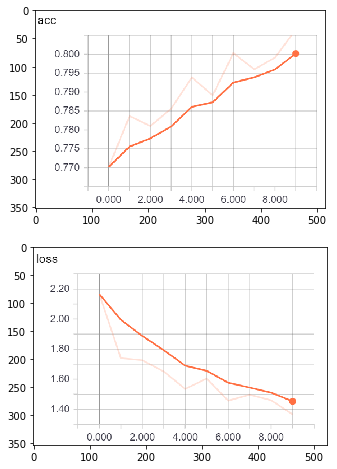

In [398]:
import matplotlib.image as mpimg
print("The plots from tensorboard:")
fig, axes = plt.subplots(2, 1, figsize=[10,8])
img_acc = mpimg.imread('img/acc.PNG')
axes[0].imshow(img_acc)
img_loss = mpimg.imread('img/loss.PNG')
axes[1].imshow(img_loss)

# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for your LSTM encoder decoder model with attention

In [11]:
BATCH_SIZE = 1000
NUM_LAYERS = (3,3)
HIDDEN_DIM = 128
EPOCHS = 60

You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

In [12]:
def create_UniLSTMwithAttention(X_vocab_len, X_max_len,y_vocab_len, y_max_len, hidden_size, num_layers = NUM_LAYERS, return_probabilities = False):
    max_len = max(X_max_len, y_max_len)
    embed_dim = embedding_weights.shape[1]
    encoder_inputs = Input(shape=(max_len,))
    embedder = Embedding(embedding_weights.shape[0], embed_dim, input_length = max_len, weights = [embedding_weights],
                     mask_zero= True)(encoder_inputs)
    ### LSTM hidden state output and cell state for the last time step 
    encoder = LSTM(hidden_size, input_shape = (max_len,embed_dim), return_sequences=True, return_state=True)
    encoder_outputs,_,_ = encoder(embedder)
    #encoder_outputs = Dropout(0.2)(encoder_outputs)
    encoder_1 = LSTM(hidden_size, return_sequences=True, return_state=True)
    encoder_outputs_1,_,_ = encoder_1(encoder_outputs)
    #encoder_outputs_1 = Dropout(0.2)(encoder_outputs_1)
    encoder_2 = LSTM(hidden_size, return_sequences=True, return_state=True)
    encoder_outputs_2,_,_ = encoder_2(encoder_outputs)
    
    decoder_outputs = AttentionDecoder(hidden_size, y_vocab_len, return_probabilities = return_probabilities)(encoder_outputs) 
    
    model = Model(encoder_inputs, decoder_outputs)
    model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=[ 'accuracy' ])
    
    
    return model

In [14]:
model = create_UniLSTMwithAttention(VOCAB_SIZE+1, count_art, VOCAB_SIZE+1, count_sum, HIDDEN_DIM)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 33)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 33, 300)           3000300   
_________________________________________________________________
lstm_1 (LSTM)                [(None, 33, 128), (None,  219648    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 33, 10001)         106578738 
Total params: 109,798,686
Trainable params: 109,798,686
Non-trainable params: 0
_________________________________________________________________


# Train the Model

Train the model, as you did before, for the model without attention

In [251]:
# reload data
MAX_LEN = 33 #count_sum = np.max(np.count_nonzero(summary_pad, axis=1)) + 1

VOCAB_SIZE = 10000

In [252]:
# get padding dataset
article_pad,vocab_art, idx2word_art, word2idx_art, summary_pad,vocab_sum, \
idx2word_sum, word2idx_sum = load_data(train_article, train_title, MAX_LEN, VOCAB_SIZE)
# transform test data using train word2vec
print("Transform test data...")
tokenizer, sub_test_article = _tokenize_(train_article, test_article)
temp = tokenizer.texts_to_sequences(sub_test_article)
trans_test_article = [[tokenizer.word_index['<unk>'] if x > VOCAB_SIZE else x for x in row] for row in temp]
test_article_pad = sequence.pad_sequences(trans_test_article, maxlen=MAX_LEN, padding='post', truncating='post')

Creating article's idx2word ...
The vocabulary size of article is 10001
Creating article's word2idx ...
Converting Article to index..
Padding the sentence..
Creating summary's idx2word ...
The vocabulary size of summary is 10001
Creating summary's word2idx ... 
Converting Summary to index..
Padding the sentence..
Transform test data...


In [253]:
import codecs
EMBED_SIZE = 300
#load glove embeddings
gembeddings_index = {}
with codecs.open('glove.42B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        gembedding = np.asarray(values[1:], dtype='float32')
        gembeddings_index[word] = gembedding
#
f.close()
print('G Word embeddings:', len(gembeddings_index))
embedding_weights = np.zeros(((VOCAB_SIZE+1), EMBED_SIZE))
missing = 0
for word, index in word2idx_art.items():
    try:
        embedding_weights[index, :] = gembeddings_index[word]
    except KeyError:
        #print(word)
        missing += 1
        pass
print('G Null word embeddings: %d' %missing)

G Word embeddings: 14050
G Null word embeddings: 2621


In [16]:
def __data_generation():
        for i in range(len(article_pad)//1000): # 500 * 100 = 60000 -> # of training samples
            ## batch size
            X_train, y_trian = article_pad[i*1000:(i+1)*1000], summary_pad[i*1000:(i+1)*1000]
            # one-hot y
            decoder_input_data = np.zeros((len(y_trian), count_sum, vocab_sum),
                                          dtype='float64')
            decoder_target_data = np.zeros((len(y_trian), count_sum,vocab_sum),
                                           dtype='float64')
            
            ## construct decoder data
            for k, target_text in enumerate(y_trian):
                for t, ind in enumerate(target_text):
                    # decoder_target_data is ahead of decoder_input_data by one timestep
                    decoder_input_data[k, t, ind] = 1.
                    if t > 0:
                        # decoder_target_data will be ahead by one timestep
                        # and will not include the start character.
                        decoder_target_data[k, t - 1, ind] = 1.
                        
            yield X_train, decoder_input_data, decoder_target_data 

In [35]:
# checkpoint
filepath="weights_best_attention.h5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

for i in range(15): #45 + 15
    times = 0
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print("epochs %d" % i)
    for X_train, Y_train_input, Y_train_target in __data_generation():
        times += 1
        print("samples %d" % times)
        model.fit(X_train, Y_train_input, batch_size= 128, epochs=1, callbacks=callbacks_list)
        #if times == 1:
        #    break

xxxxxxxxxxxxxxxxxxxxxxxxxxxxx
epochs 0
samples 1
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9922 - acc: 0.7627


/usr/local/lib/python3.4/dist-packages/keras/callbacks.py:402: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


samples 2
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9232 - acc: 0.7816
samples 3
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7731 - acc: 0.8108
samples 4
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0304 - acc: 0.7597
samples 5
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8165 - acc: 0.8071
samples 6
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9852 - acc: 0.7629
samples 7
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.1146 - acc: 0.7414
samples 8
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7278 - acc: 0.8226
samples 9
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0532 - acc: 0.7515
samples 10
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9802 - acc: 0.7723
samples 11
Epoch 1/1
1000/1

samples 27
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9400 - acc: 0.7753
samples 28
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0620 - acc: 0.7584
samples 29
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.5380 - acc: 0.8717
samples 30
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8907 - acc: 0.7862
samples 31
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0063 - acc: 0.7666
samples 32
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6916 - acc: 0.8396
samples 33
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7290 - acc: 0.8199
samples 34
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9343 - acc: 0.7771
samples 35
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0610 - acc: 0.7580
samples 36
Epoch 1/

1000/1000 [==============================] - 20s 20ms/step - loss: 0.9265 - acc: 0.7783
samples 2
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8781 - acc: 0.7911
samples 3
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7317 - acc: 0.8225
samples 4
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9662 - acc: 0.7740
samples 5
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7664 - acc: 0.8198
samples 6
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9310 - acc: 0.7734
samples 7
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0534 - acc: 0.7535
samples 8
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6932 - acc: 0.8318
samples 9
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0079 - acc: 0.7606
samples 10
Epoch 1/1
1000/1000 [================

1000/1000 [==============================] - 20s 20ms/step - loss: 0.9570 - acc: 0.7758
samples 32
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6482 - acc: 0.8464
samples 33
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6682 - acc: 0.8327
samples 34
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8942 - acc: 0.7862
samples 35
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 1.0191 - acc: 0.7672
samples 36
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.4676 - acc: 0.8851
samples 37
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8077 - acc: 0.8090
samples 38
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8608 - acc: 0.7972
samples 39
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8986 - acc: 0.7952
samples 40
Epoch 1/1
1000/1000 [========

1000/1000 [==============================] - 20s 20ms/step - loss: 0.7227 - acc: 0.8276
samples 6
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8601 - acc: 0.7894
samples 7
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9934 - acc: 0.7650
samples 8
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6426 - acc: 0.8449
samples 9
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9584 - acc: 0.7712
samples 10
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8796 - acc: 0.7919
samples 11
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7531 - acc: 0.8174
samples 12
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9383 - acc: 0.7787
samples 13
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7433 - acc: 0.8217
samples 14
Epoch 1/1
1000/1000 [============

1000/1000 [==============================] - 20s 20ms/step - loss: 0.8058 - acc: 0.8009
samples 31
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9031 - acc: 0.7878
samples 32
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6101 - acc: 0.8558
samples 33
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6330 - acc: 0.8413
samples 34
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8362 - acc: 0.7972
samples 35
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9592 - acc: 0.7780
samples 36
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.4438 - acc: 0.8921
samples 37
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7550 - acc: 0.8178
samples 38
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8143 - acc: 0.8030
samples 39
Epoch 1/1
1000/1000 [========

1000/1000 [==============================] - 20s 20ms/step - loss: 0.8954 - acc: 0.7857
samples 10
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8236 - acc: 0.8050
samples 11
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7020 - acc: 0.8293
samples 12
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8902 - acc: 0.7869
samples 13
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7032 - acc: 0.8281
samples 14
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7872 - acc: 0.8085
samples 15
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9051 - acc: 0.7839
samples 16
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6368 - acc: 0.8490
samples 17
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7622 - acc: 0.8149
samples 18
Epoch 1/1
1000/1000 [========

1000/1000 [==============================] - 20s 20ms/step - loss: 0.8086 - acc: 0.8125
samples 40
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.4043 - acc: 0.9001
samples 41
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7445 - acc: 0.8199
samples 42
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7480 - acc: 0.8218
samples 43
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8601 - acc: 0.7971
samples 44
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.4085 - acc: 0.8979
samples 45
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7434 - acc: 0.8164
samples 46
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7719 - acc: 0.8163
samples 47
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7740 - acc: 0.8173
samples 48
Epoch 1/1
1000/1000 [========

1000/1000 [==============================] - 20s 20ms/step - loss: 0.8254 - acc: 0.8059
samples 19
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6002 - acc: 0.8536
samples 20
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7185 - acc: 0.8238
samples 21
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7567 - acc: 0.8195
samples 22
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6138 - acc: 0.8520
samples 23
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6559 - acc: 0.8380
samples 24
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7973 - acc: 0.8041
samples 25
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7259 - acc: 0.8259
samples 26
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.5685 - acc: 0.8590
samples 27
Epoch 1/1
1000/1000 [========

1000/1000 [==============================] - 20s 20ms/step - loss: 0.6930 - acc: 0.8321
samples 50
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7334 - acc: 0.8238
xxxxxxxxxxxxxxxxxxxxxxxxxxxxx
epochs 14
samples 1
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7454 - acc: 0.8155
samples 2
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7058 - acc: 0.8314
samples 3
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.5744 - acc: 0.8594
samples 4
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7710 - acc: 0.8151
samples 5
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.6092 - acc: 0.8523
samples 6
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.7456 - acc: 0.8169
samples 7
Epoch 1/1
1000/1000 [==============================] - 20s 20ms/step - loss: 0.8534 - acc: 0.7958
samples

# Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [23]:
from numpy import argmax
def one_hot_decode(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

In [66]:
result = []
###for seq_index in range(len(test_article_pad)):
for seq_index in range(len(test_article_pad)):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = test_article_pad[seq_index: seq_index + 1]
    #input_seq = article_pad[seq_index: seq_index + 1]
    decoded_list = model.predict(input_seq)
    decoded_list_1 = one_hot_decode(decoded_list[0])
    decoded_list_2 = np.argmax(decoded_list, axis=2)[0]
    #assert decoded_list_1 == decoded_list_2
    decoded_list = [idx2word_sum[ind] for ind in decoded_list_1 if ind>0 and idx2word_sum[ind] != '<s>']
    decoded_sentence = " ".join(decoded_list).strip()
    result.append(decoded_sentence)
    print('-')
    print('Input sentence:', test_title[seq_index])
    print('Decoded sentence:', decoded_sentence)
np.savetxt('result_attention.txt', result, fmt='%s')

-
Input sentence: london share prices up at midday

Decoded sentence: london s ftse ### at midday points points at
-
Input sentence: london share prices down at midday

Decoded sentence: london s ftse lower index midday midday
-
Input sentence: kewell ready for jeers when liverpool hosts leeds

Decoded sentence: <unk> <unk> <unk> write leader without without <unk>
-
Input sentence: most rwc tries conceded list

Decoded sentence: <unk> hit to world cup
-
Input sentence: u.s. open referee masters art of juggling

Decoded sentence: three leads to a day
-
Input sentence: san jose defenseman gary suter to retire

Decoded sentence: gary to star retirement to nhl
-
Input sentence: stocks finish down in mexico chile ; rise sharply in argentina

Decoded sentence: stocks stocks in mexico argentina argentina chile chile argentina
-
Input sentence: the green book _ ##,### songs #,### categories _ popular with industry pros music geeks

Decoded sentence: cardinals cardinals cardinals <unk> <unk>
-


-
Input sentence: comments on eu ruling that microsoft abused windows software monopoly

Decoded sentence: <unk> technology <unk> <unk>
-
Input sentence: woods ca n't get it going in final round

Decoded sentence: williams topple gets different woods fog
-
Input sentence: brian wilson lets the music do the talking

Decoded sentence: another 's finds nothing the the the ... thing
-
Input sentence: <unk> <unk> woman is both bourgeois and rock n roll

Decoded sentence: resorts came mom the victim to victim issue <unk>
-
Input sentence: dusan bajevic new coach of cyprus champion omonia

Decoded sentence: <unk> named as coach coach
-
Input sentence: pacquiao trains during typhoon megi in philippines

Decoded sentence: pacquiao <unk> <unk> support roster
-
Input sentence: ny home of fed-up <unk> attendant burglarized

Decoded sentence: flight flight <unk> <unk> <unk> mobile driving
-
Input sentence: boeing books orders for ## more ###s

Decoded sentence: boeing order order order order ## ## 

-
Input sentence: video game maker seeks fans to rename themselves after fantasy <unk> <unk>

Decoded sentence: fans new new give biggest biggest share
-
Input sentence: pop star nicholas tse in more driving trouble

Decoded sentence: after finds trying to ca you you expensive <unk>
-
Input sentence: traditional scottish dish the haggis under threat over health concerns

Decoded sentence: chicken chicken in the queen scotland
-
Input sentence: iraq debate heating up with congress return from summer break

Decoded sentence: iraq emerges iraq iraq iraq debate debate
-
Input sentence: with bc-diana-investigation death of diana puts inauguration of maria callas square on hold

Decoded sentence: new produces set to auctioned june
-
Input sentence: italian students decrease immigrants children fill spots with <unk>

Decoded sentence: italian cost ways to see <unk> to the <unk>
-
Input sentence: copenhagen 's <unk> building to be demolished

Decoded sentence: yugoslavia danish yugoslavia 's '

-
Input sentence: fa meets again to discuss who replaces eriksson

Decoded sentence: england 's game game to sponsorship sponsorship
-
Input sentence: <unk> play like ... amateurs

Decoded sentence: <unk> masters a masters masters masters masters
-
Input sentence: david lee roth on his way out shock jocks opie and anthony may be coming back to fm radio

Decoded sentence: lee lee <unk> host host host host ##th
-
Input sentence: kyle busch to start from phoenix pole

Decoded sentence: <unk> unsure meet kyle to meet meet meet
-
Input sentence: three years after bush declared mission accomplished the outlook is still mixed

Decoded sentence: bush 's pay pay <unk> stop stop trade
-
Input sentence: culinary school enrollment is up amid celebrity chef craze but <unk> jobs debt await

Decoded sentence: james <unk> take take her life movie <unk>
-
Input sentence: nathan lane s golden touch at the broadway box office remains undiminished

Decoded sentence: <unk> gets gets gets estate on <unk>
-


-
Input sentence: prosecutors repeat #-year prison term demand for convicted hyundai motor chief

Decoded sentence: time 's has break climb to $ $ million in
-
Input sentence: daly withdraws from bmw international for personal reasons

Decoded sentence: daly daly out of out open
-
Input sentence: men ready to dress up again at summer #### shows in milan

Decoded sentence: italian designers designers with gift gift gift gift
-
Input sentence: london s ftse-### index up ##.# points at #,###.# at close

Decoded sentence: london s ftse ### index up ##.# points at #,###.# at close
-
Input sentence: jankovic lets mind wander during third round at wimbledon

Decoded sentence: <unk> says join join join join join on on <unk> with
-
Input sentence: open season hunts up no. box-office debut with $ ##.# million

Decoded sentence: <unk> is a end season the the season
-
Input sentence: text of north korea s announcement it has carried out a nuclear test

Decoded sentence: nkorea korea says begins of

-
Input sentence: expos # giants #

Decoded sentence: giants lose out <unk> patience
-
Input sentence: bulls hope changes will bring new start

Decoded sentence: bulls have offense to to to to game
-
Input sentence: klitschko set for johnson fight

Decoded sentence: <unk> returns tko successor lead lead other other other
-
Input sentence: singer pink recalls fast-food jobs

Decoded sentence: <unk> <unk> summer home home <unk> looks <unk>
-
Input sentence: trial of saddam hussein could have unpredictable impact

Decoded sentence: <unk> 's himself judge <unk> for <unk> <unk>
-
Input sentence: at least two explosions heard in kabul

Decoded sentence: <unk> <unk> in big
-
Input sentence: ben affleck on gossip fans paycheck and reluctantly lopez

Decoded sentence: southern want about will political <unk> kill
-
Input sentence: artest shuts down james on rookie 's ##th birthday

Decoded sentence: stars ripe to ##th display with
-
Input sentence: james shines cavaliers struggle

Decoded sente

-
Input sentence: explosion heard in tel aviv police say it was of a criminal nature

Decoded sentence: explosion explosion in central
-
Input sentence: bettini wins men s road race at the world championships

Decoded sentence: <unk> order order opening opening opening opening record
-
Input sentence: american wins <unk> trophy women s event

Decoded sentence: <unk> <unk> <unk> women 's national 's
-
Input sentence: india 's first test match against england ends in a draw

Decoded sentence: rain england england test test india test draw draw
-
Input sentence: tennis tours ok tv replay

Decoded sentence: the great great <unk> fun words own
-
Input sentence: pixar steals show at disney shareholders meeting in anaheim

Decoded sentence: <unk> doubles first for
-
Input sentence: clooney 's oscar gift bag nets $ ##,### in charity auction

Decoded sentence: george clooney denies july richards sells for auction
-
Input sentence: mats get back together to record two new songs

Decoded sentence

-
Input sentence: london finally celebrates winning #### olympics

Decoded sentence: nearly nearly for as <unk> track track bid
-
Input sentence: once a sleepy government town baton rouge now bursting at the seams

Decoded sentence: new 's new new orleans 's <unk> <unk> island island
-
Input sentence: warne looks to draw curtain on ashes career in england with victory

Decoded sentence: jazz was <unk> jazz of jazz ashes
-
Input sentence: ahead of elections buddhist party _ grudgingly _ throws weight behind koizumi

Decoded sentence: <unk> of <unk> <unk> minister minister minister minister
-
Input sentence: israel expected to begin pulling last troops out of gaza late monday

Decoded sentence: israeli soldier of israeli to gaza gaza gaza
-
Input sentence: inter ready to offer baggio a job

Decoded sentence: ronaldo plans to return to move to return to
-
Input sentence: creditors may suffer but lawyers will profit from delta northwest bankruptcies

Decoded sentence: executive passes unio

-
Input sentence: take that big sis serena williams beats venus for french open

Decoded sentence: first chase major major a a a major at
-
Input sentence: russia is in the driving seat to reach second round ; belgium needs

Decoded sentence: russia defense to to <unk> hate hate hate
-
Input sentence: wilmots ends international career on high note despite loss to brazil

Decoded sentence: scottish finally finally change lead scoring bengals lead
-
Input sentence: the world cup trophy is as filled with history as the world cup

Decoded sentence: world cup trophy trophy trophy
-
Input sentence: hong kong share prices surge

Decoded sentence: share prices close bargain bargain bargain
-
Input sentence: slimmed-down calcavecchia grabs leads after first round of bellsouth

Decoded sentence: <unk> down woods ## ## <unk> strong
-
Input sentence: maccarone struggles with parma while former club middlesbrough riding high

Decoded sentence: <unk> <unk> camp penalty with camp camp
-
Input sentenc

-
Input sentence: florida panther 's revival raises concerns in suburbia

Decoded sentence: <unk> rules <unk> <unk> <unk> <unk> out
-
Input sentence: chavez eyes nationalized cement industry

Decoded sentence: government signs <unk> u.s. <unk>
-
Input sentence: clinton survives to campaign another day

Decoded sentence: clinton ends huge huge <unk> <unk> dies survivor
-
Input sentence: black decker 's offer on recalled toaster draws

Decoded sentence: <unk> giant giant <unk> giant
-
Input sentence: nec agrees to merge pc division with packard bell

Decoded sentence: <unk> cuts rise $ for for $ in cuts
-
Input sentence: sahara 's <unk> budget

Decoded sentence: a <unk> is <unk>
-
Input sentence: latino parents look ahead

Decoded sentence: college college college her her ###,### women women
-
Input sentence: outdoor amenities on the tube

Decoded sentence: hunters the the the for flight flight water
-
Input sentence: try some assertive <unk> now in season

Decoded sentence: <unk> <unk> 

-
Input sentence: mccain 's win suggests he may add quite a few more

Decoded sentence: mccain backing winner of presidential mccain gop gop mccain
-
Input sentence: when a <unk> wo n't do

Decoded sentence: the <unk> course the boom
-
Input sentence: moore plays it for laughs

Decoded sentence: <unk> 's <unk> <unk> his
-
Input sentence: a grieving dog owner gets some comfort from a pet psychic

Decoded sentence: a words and god feminist is is and
-
Input sentence: sports watches push fashion back

Decoded sentence: spanish time hosts past coming
-
Input sentence: ambitious holy land

Decoded sentence: <unk> <unk> <unk> <unk> in <unk> <unk> <unk>
-
Input sentence: a season in the life of broadway

Decoded sentence: <unk> 's takes of of adventure of
-
Input sentence: the basics of a <unk>

Decoded sentence: <unk> many way to more a to <unk>
-
Input sentence: variations on a <unk> theme

Decoded sentence: favorites your fit <unk> forget
-
Input sentence: jewish faithful expanding their f

-
Input sentence: how to get stains out

Decoded sentence: teach <unk> to making less <unk>
-
Input sentence: lakers ended up in fourth-quarter fiasco

Decoded sentence: lakers look lakers lakers lakers better better better better
-
Input sentence: dodgers should make a statement with sheffield

Decoded sentence: dodgers is dodgers dodgers dodgers dodgers
-
Input sentence: sonics -lcb- rsquo -rcb- streak wilts under phoenix heat

Decoded sentence: suns gets out having $ ###m ###m having state
-
Input sentence: phillips helped define california for a generation

Decoded sentence: <unk> phillips family family dies
-
Input sentence: casting for silver salmon renewing a life

Decoded sentence: green <unk> to green <unk>
-
Input sentence: ratings make a fleeting debut

Decoded sentence: ratings ratings ratings ratings ratings
-
Input sentence: a tough outing for wakefield

Decoded sentence: stability not around <unk> double
-
Input sentence: gingrich deserter smith now a poison pill

Decode

-
Input sentence: his fire still lights the way

Decoded sentence: bring attempt a <unk> <unk> <unk>
-
Input sentence: <unk> sale is a loss for sotheby 's

Decoded sentence: <unk> 's <unk> manhattan manhattan 's a manhattan manhattan manhattan
-
Input sentence: the slide into peril of sabrina green age #

Decoded sentence: <unk> the <unk> of lake <unk> <unk> <unk> <unk>
-
Input sentence: douglas making his home with the nets

Decoded sentence: <unk> douglas himself right on <unk>
-
Input sentence: nebraska grants first full scholarship for bowling team member

Decoded sentence: no. # qb in football football
-
Input sentence: in winter 's icy snow keep your cool and go

Decoded sentence: l.a. setbacks hours in in
-
Input sentence: langenbrunner improving fast for the stars

Decoded sentence: <unk> <unk> to to control
-
Input sentence: yes you can have too much insurance

Decoded sentence: working rules time coming money money money money money
-
Input sentence: kerry 's college plan

De

-
Input sentence: outside caulk is not worth it outside caulk is not worth it

Decoded sentence: questions questions gave <unk> <unk> <unk>
-
Input sentence: ups says peak shipping day will be dec.

Decoded sentence: ups to <unk> for baby and to holiday
-
Input sentence: for pagliuca health reform trumps choice

Decoded sentence: <unk> will entering confident
-
Input sentence: amid ethics scandal defiant rangel fraying at the seams

Decoded sentence: texas <unk> <unk> his <unk> his his in <unk> <unk>
-
Input sentence: stressing the web newshour begins an overhaul

Decoded sentence: <unk> dominates <unk> <unk> <unk> <unk> <unk>
-
Input sentence: russia s neighbors resist wooing and bullying

Decoded sentence: russia 's become doubles _ russia russia russia trophy
-
Input sentence: amid young u.s. players veteran hopes to be noticed

Decoded sentence: prevention rejects <unk> <unk> <unk>
-
Input sentence: obama s visit to russia is greeted with a shrug

Decoded sentence: despite to july 

-
Input sentence: teammates trust in fisher

Decoded sentence: fisher make on road road
-
Input sentence: online trade fees falling off the screen

Decoded sentence: <unk> sells sells <unk> sells an
-
Input sentence: roth ira is the best bet against higher taxes

Decoded sentence: roth ira remain remain
-
Input sentence: foes and allies say microsoft has stumbled in case

Decoded sentence: microsoft companies <unk> <unk> <unk> <unk> industry
-
Input sentence: kings beat red wings

Decoded sentence: kings kings to nets nets
-
Input sentence: start is nice for lakers rice

Decoded sentence: elbow does to coach coach
-
Input sentence: st john 's has a celtics look

Decoded sentence: celtics give <unk> <unk>
-
Input sentence: awards show gives l.a. financial boost

Decoded sentence: given given gets on round round round round round
-
Input sentence: rangers aim to ease cultural adjustment

Decoded sentence: rangers hoping drive jones in drive rangers desperate desperate
-
Input sentence: i

-
Input sentence: lack of home rule at texas stadium hurting cowboys

Decoded sentence: <unk> t t change change change change change
-
Input sentence: virginia prisoner receives rare mercy on death row

Decoded sentence: marines sentence ## years life _ _ to to death death
-
Input sentence: tv box links tv sets to e-mail and internet

Decoded sentence: live <unk> live television television television tv tv
-
Input sentence: sing telecom #st-half net seen rising ##-## % tough times loom

Decoded sentence: telecommunications issues industry for <unk> rises to <unk>
-
Input sentence: robbery suspects make police work easy

Decoded sentence: police ambush arrested in before who probation
-
Input sentence: from #### some words from others to ponder

Decoded sentence: all of the <unk>
-
Input sentence: from the beginning a man is reading the bible aloud without stop

Decoded sentence: <unk> 's lay w. and breaks breaks
-
Input sentence: same-sex marriage failing nuclear family may redefine

D

-
Input sentence: remedies for musty magazines

Decoded sentence: finding <unk> 's <unk> <unk> deck
-
Input sentence: saab encounters rocky road ; imperfections rattle fan of swedish

Decoded sentence: sometimes or or or or or
-
Input sentence: canadian <unk> chairman to sell ##.# % stake in offering

Decoded sentence: canadian quality canada canada canada canada <unk>
-
Input sentence: the elvis mojo on me

Decoded sentence: kept kept <unk> was was was his
-
Input sentence: trinidad is all dressed up with no one to fight

Decoded sentence: <unk> denies <unk> for <unk>
-
Input sentence: for moseley-braun a fight for redemption

Decoded sentence: <unk> <unk> <unk> <unk> <unk>
-
Input sentence: una <unk> <unk> con el brasil

Decoded sentence: la la la la <unk>
-
Input sentence: brown has more money riding on championship than saban

Decoded sentence: <unk> brown switch to ready division title
-
Input sentence: the unloved annuity gets a hug from obama

Decoded sentence: obama <unk> new l

-
Input sentence: lazarus at large column <unk> finds new ways to ding customers

Decoded sentence: <unk> cell phone phone phone <unk> cell cell <unk> <unk>
-
Input sentence: american literature 's <unk> gets canonized

Decoded sentence: philip holds <unk> <unk> <unk> <unk> <unk> mortgage
-
Input sentence: def leppard does it big

Decoded sentence: <unk> <unk> the the the <unk> <unk> <unk>
-
Input sentence: news of the city ### years later

Decoded sentence: nyc year old set to set but in in in new new new
-
Input sentence: mets put wright on disabled list with concussion

Decoded sentence: <unk> leads to host on to classic
-
Input sentence: in last days a quest for joy music family

Decoded sentence: family family night shared night night night night
-
Input sentence: margin calls prompt sales and drive shares even lower

Decoded sentence: investors issues <unk> <unk> <unk> investors investors <unk>
-
Input sentence: buckling up <unk> canines need safety restraints too

Decoded senten

-
Input sentence: <unk> may turn out to be the stars of this super bowl

Decoded sentence: <unk> <unk> final <unk> <unk> <unk>
-
Input sentence: mexican girl enjoys life and mourns her brother-in-law

Decoded sentence: <unk> <unk> house an found found <unk> <unk>
-
Input sentence: customer service indicator tumbles

Decoded sentence: corporate that that in be <unk> source be <unk>
-
Input sentence: girl scouts look to feed your inner cookie monster

Decoded sentence: seeking scouts perfect perfect perfect perfect are are last last last last
-
Input sentence: bush needs to back up words with action in middle east

Decoded sentence: a year born at college in muslim s s <unk>
-
Input sentence: at lehigh the little wrestling team that could

Decoded sentence: ucla retains win run against title
-
Input sentence: olympic cycling hopeful 's bikes stolen

Decoded sentence: <unk> olympic olympic olympic olympic olympic olympic
-
Input sentence: rangers quick start ends with solid relief

Decode

-
Input sentence: kids can provide extra workout on hike

Decoded sentence: <unk> far paris of <unk> being being experts
-
Input sentence: checking in with hemingway on key west

Decoded sentence: key key in key called called job in in
-
Input sentence: <unk> film focuses on the <unk> botched u.s. occupation of iraq

Decoded sentence: iraq war awaits on war iraq
-
Input sentence: next act awaits the wilbur theatre

Decoded sentence: a a a boston in broadway in the
-
Input sentence: there s no shaking booty this season

Decoded sentence: ibrahimovic looking ahead <unk>
-
Input sentence: era ends for king subjects

Decoded sentence: king 's <unk> dead 's dead <unk> <unk> <unk> <unk>
-
Input sentence: a chavez comeback more astounding than his fall

Decoded sentence: venezuela president president venezuelan favor in end s
-
Input sentence: wright is bit of all right mate

Decoded sentence: vonn wins for <unk> title
-
Input sentence: the sweeps will be with you always

Decoded sentence: <u

-
Input sentence: a passion for collecting the unexplored and <unk>

Decoded sentence: <unk> <unk> ruins ruins helps <unk>
-
Input sentence: angels overcame bad to get good

Decoded sentence: angels 's worst worst a game game
-
Input sentence: murray to serve as lakers bench minor

Decoded sentence: <unk> gets gets gets draw
-
Input sentence: halloween made horror history

Decoded sentence: the meeting meeting <unk> <unk>
-
Input sentence: lakers kings in exhibition match tonight

Decoded sentence: kings lose home home with the
-
Input sentence: strong sales in north america bolster toyota 's profits

Decoded sentence: <unk> <unk> <unk> auto personal <unk> <unk> auto auto green
-
Input sentence: bush plans to shrink national monument boundaries

Decoded sentence: america and beautiful proud and and <unk>
-
Input sentence: coolly carrying the torch for the classical guitar

Decoded sentence: <unk> push a to a an to # <unk> detroit
-
Input sentence: lpga goes from tee to shining tee

Dec

-
Input sentence: dellucci finds home on the road

Decoded sentence: rangers rangers rangers rangers rangers rangers rangers
-
Input sentence: no host but little fuss at mtv awards

Decoded sentence: this music music music music music music music music
-
Input sentence: gretzky 's debut for blues is good if not great

Decoded sentence: <unk> 's were to deal that that deal
-
Input sentence: morgan leads after round of ##

Decoded sentence: racer brothers says hit hit in kansas ##
-
Input sentence: there will be no stopping the tribe

Decoded sentence: indians indians indians indians #
-
Input sentence: rudy t. is on a major winning streak

Decoded sentence: <unk> <unk> be add <unk> <unk> <unk> <unk> <unk>
-
Input sentence: sec nyse examine rules that almost stopped trading last week

Decoded sentence: dow posts a $ high high
-
Input sentence: colors that bloom in spring

Decoded sentence: sweet sweet sweet sweet sweet sweet <unk> sweet sweet sweet
-
Input sentence: the world is eldredge

-
Input sentence: company was trying to raise loans from $ #.## billion to $ #

Decoded sentence: worldcom <unk> to record <unk>
-
Input sentence: run-down barn becomes couple 's dream home

Decoded sentence: solo 's solo solo solo solo
-
Input sentence: the cox news service spot news budget for friday may # ####

Decoded sentence: the cox news service spot news budget for thursday may ##
-
Input sentence: oilers blank stars #-# tie series #-#

Decoded sentence: stars <unk> up #### draws draws draws
-
Input sentence: classic spud salad is a specialty the world over

Decoded sentence: a fit time time perfect that that that upset
-
Input sentence: packard bell turns to cyrix

Decoded sentence: <unk> says king <unk> <unk> <unk> <unk> <unk>
-
Input sentence: the mysterious aunt rob

Decoded sentence: <unk> 's the life street takes street street
-
Input sentence: sound of music the evergreen that never dies

Decoded sentence: plenty is music music is the the night
-
Input sentence: under ze

-
Input sentence: trojans know better than to look too far ahead

Decoded sentence: <unk> blame blame in the in
-
Input sentence: take ## small but profound journeys with robert <unk> butler

Decoded sentence: duvall 's rod rod rod literary book mainstream
-
Input sentence: president bush in his own words

Decoded sentence: president <unk> for shares shares shares shares shares
-
Input sentence: planets line up for red sox

Decoded sentence: red shows always at red red
-
Input sentence: border -lcb- ndash -rcb- workplace enforcement missing

Decoded sentence: giuliani immigration immigration immigration immigration immigration immigration immigration immigration
-
Input sentence: google keeps on <unk>

Decoded sentence: google of crisis <unk> strong strong strong
-
Input sentence: gambler 's luck then life ran out

Decoded sentence: <unk> <unk> broadband <unk> <unk> <unk>
-
Input sentence: yankees own series as mets lose again

Decoded sentence: braves lose baseball baseball in basebal

-
Input sentence: chinese shares open higher monday

Decoded sentence: chinext index opens lower wednesday
-
Input sentence: dollar at mid-## yen in tokyo

Decoded sentence: dollar at at ## yen level in tokyo
-
Input sentence: dollar briefly rises to mid-## yen range

Decoded sentence: dollar briefly falls to mid yen in in tokyo
-
Input sentence: dollar trades in lower ## yen range in tokyo

Decoded sentence: dollar trades in ## ## yen range
-
Input sentence: dollar rises to mid-## yen range

Decoded sentence: dollar rises to mid ## yen range in tokyo
-
Input sentence: oil prices fall slightly

Decoded sentence: oil futures fall slightly
-
Input sentence: dollar trades at lower ### yen in tokyo

Decoded sentence: dollar at at lower ### yen level in tokyo
-
Input sentence: russia belarus ratify union treaty charter

Decoded sentence: <unk> <unk> <unk> with union strike strike strike
-
Input sentence: code of conduct launched in s. africa

Decoded sentence: south police launch <unk> <unk

-
Input sentence: dollar firms at lower ## yen level in tokyo

Decoded sentence: dollar remains lower lower ## yen range
-
Input sentence: dollar falls to lower ## yen range

Decoded sentence: dollar remains in lower ## yen range in tokyo
-
Input sentence: dollar at lower ## yen in tokyo

Decoded sentence: dollar at lower ## yen in tokyo
-
Input sentence: chinese shares fall slightly

Decoded sentence: chinese shares fall slightly lower higher
-
Input sentence: dollar rises to lower ## yen range

Decoded sentence: dollar rises to lower yen yen in tokyo
-
Input sentence: dollar trades in lower ## yen level

Decoded sentence: dollar trades in ## ## yen in tokyo
-
Input sentence: iran beat china #-# in four-nation soccer tourney

Decoded sentence: china beats china # # in soccer soccer soccer
-
Input sentence: chinese celebrates labor day

Decoded sentence: tremor celebrate in art with
-
Input sentence: new zealand sees few marriages divorces

Decoded sentence: nz zealand shares rise in p

-
Input sentence: un aid envoy arrives in angola

Decoded sentence: un un arrive arrive in
-
Input sentence: premier li peng writes song for three gorges dam

Decoded sentence: chinese <unk> meets own <unk> <unk>
-
Input sentence: russia sets up first professional cycling team

Decoded sentence: russia sets up russia team first
-
Input sentence: bahrain hold china #-# in soccer friendly

Decoded sentence: bahrain draw china draw with soccer friendly
-
Input sentence: seoul shares close higher

Decoded sentence: skorean shares close close higher
-
Input sentence: chinext index opens higher monday

Decoded sentence: chinext index opens higher monday higher
-
Input sentence: chinext index opens lower tuesday

Decoded sentence: chinext index opens lower friday
-
Input sentence: china issues new rules for commodities trading

Decoded sentence: china 's <unk> on on on on trade trade
-
Input sentence: small thermal power stations in china being closed

Decoded sentence: china scientists find 

-
Input sentence: chinese shares #.## pct higher at midday

Decoded sentence: chinese shares #.## #.## pct in morning trade
-
Input sentence: dollar rises to lower ## yen level in tokyo

Decoded sentence: dollar rises to lower ## yen in tokyo
-
Input sentence: dollar firms around ## yen line

Decoded sentence: dollar around ## yen line
-
Input sentence: australian dollar closes higher

Decoded sentence: australian dollar ends higher
-
Input sentence: italy squad for romania friendly

Decoded sentence: italy schedules ## man to to face
-
Input sentence: new zealand sharemarket closes higher

Decoded sentence: new zealand stocks close on
-
Input sentence: myanmar 's pm leaves china for home

Decoded sentence: prime prime <unk> traffic <unk>
-
Input sentence: european parliament elections begin in hungary

Decoded sentence: european parliament hungary in hungary hungary hungary
-
Input sentence: desertification worsening in tibet regional <unk> official says

Decoded sentence: <unk> of id

-
Input sentence: blade # slashes the competition at north american box office

Decoded sentence: all rallies rallies rallies as at <unk>
-
Input sentence: rubber futures close lower on smaller volumes

Decoded sentence: rubber futures close lower on smaller volumes
-
Input sentence: us military engineers arrive in philippines hostage island

Decoded sentence: us fourth seeks <unk> al al in network network
-
Input sentence: rubber futures close steady on smaller volumes

Decoded sentence: rubber futures close unchanged on unchanged volumes
-
Input sentence: juventus unveil magpies flop boumsong

Decoded sentence: <unk> <unk> <unk> <unk> <unk> to <unk> <unk>
-
Input sentence: three us soldiers killed in iraq

Decoded sentence: three u.s. soldiers killed in iraq
-
Input sentence: gibernau wins home gp

Decoded sentence: spanish <unk> spanish spanish <unk> <unk>
-
Input sentence: sweden 's world cup squad

Decoded sentence: sweden squad world cup team
-
Input sentence: rubber futures clos

-
Input sentence: nuremberg exorcises nazi ghosts with new exhibit

Decoded sentence: german <unk> sale of red red amid of of <unk>
-
Input sentence: oil prices slightly higher in asian trade

Decoded sentence: oil prices higher asian asian asian asian games
-
Input sentence: twitter takes to the airwaves at least in spain

Decoded sentence: castro to tests criminal
-
Input sentence: taiwan financial markets closed

Decoded sentence: taiwan financial markets closed holiday
-
Input sentence: skorean shares close #.## percent lower

Decoded sentence: skorean shares close #.## percent percent
-
Input sentence: malaysian shares down #.## percent

Decoded sentence: malaysian shares down #.## percent
-
Input sentence: african nations cup group ## result

Decoded sentence: world african nations nations nations nations cup
-
Input sentence: volcano erupts in colombia ; no reports of injuries

Decoded sentence: gunmen becomes in <unk> in
-
Input sentence: green day s american idiot is set for b

-
Input sentence: bengals get respect along with wins

Decoded sentence: <unk> place offense in a a a
-
Input sentence: magic sign point guard elliot perry

Decoded sentence: magic gets free bill from governor governor
-
Input sentence: lieberman re-elected to senate

Decoded sentence: wisconsin is wisconsin wisconsin wisconsin wisconsin senior senior
-
Input sentence: stocks mixed in early trading

Decoded sentence: dow stocks in early trading
-
Input sentence: world split on u.s.

Decoded sentence: world in politics in
-
Input sentence: no. # washington ## ucla ##

Decoded sentence: no. # orange bowl <unk> <unk>
-
Input sentence: stock prices rise in london

Decoded sentence: london share prices higher
-
Input sentence: yankees to stay on msg next season

Decoded sentence: yankees sox <unk> <unk> <unk>
-
Input sentence: no. ## wisconsin ## no. ## okla. ##

Decoded sentence: <unk> cuts tournament championship
-
Input sentence: david reid returns to boxing ring

Decoded sentence: reid 

-
Input sentence: italy s disaster czar to quit

Decoded sentence: italy 's its no into its into s
-
Input sentence: us professor returns to sudan to build school

Decoded sentence: parents pride pride pride children children children children children parents parents
-
Input sentence: <unk> new coach for bolivia

Decoded sentence: english names named bolivia bolivia
-
Input sentence: government sells spoils of madoff s lavish life

Decoded sentence: it may not <unk> <unk>
-
Input sentence: us treasurys rise after days of steep losses

Decoded sentence: bonds rise rise treasury rise rates
-
Input sentence: treasurys mixed on subdued inflation signs

Decoded sentence: treasurys inflation inflation gains inflation inflation inflation
-
Input sentence: owner puts houston astros up for sale

Decoded sentence: astros owner owner offer offer on sale
-
Input sentence: starbucks rolls out redone line of coffee

Decoded sentence: slovak company to <unk> <unk> <unk>
-
Input sentence: rockies sig

-
Input sentence: americans have little respect for republican-led congress poll shows

Decoded sentence: <unk> 's session camp to congress
-
Input sentence: wendell sailor suspended for two years aru terminates contract

Decoded sentence: gone unveils in <unk> england
-
Input sentence: webb remains in lead at evian masters while wie ochoa drop

Decoded sentence: bidding breaks on <unk> <unk>
-
Input sentence: michael caine to open indian restaurant in london

Decoded sentence: <unk> man harvey <unk> to to to to <unk>
-
Input sentence: tokyo stocks open higher dollar down against yen

Decoded sentence: tokyo stocks open higher dollar up against yen
-
Input sentence: vicar uses the simpsons to teach christian message

Decoded sentence: <unk> fans fans fans fans fans fans
-
Input sentence: tiger woods ends training at fort bragg holds golf clinic

Decoded sentence: tiger golf golf golf open shot at win
-
Input sentence: atwood trying to revive career in busch series

Decoded sentence: <u

-
Input sentence: perennial favorite argentina seeks to make winning start to world cup year

Decoded sentence: a seems must cup be be must cup cup cup
-
Input sentence: berlin will host official world cup party where love parade was once held

Decoded sentence: united states world ecuador 's fifa fifa to mayor ecuador world
-
Input sentence: gold rises to fresh ##-year record

Decoded sentence: gold prices hit year metals metals metals year year
-
Input sentence: kosovo police seize ## kilograms of heroin

Decoded sentence: <unk> police seize in in
-
Input sentence: rangnick to leave schalke at end of season

Decoded sentence: schalke to to <unk> on the end
-
Input sentence: freestyle skier bloom ready to tackle nfl

Decoded sentence: jeremy and and need to make and and stars stars stars
-
Input sentence: ny public library branch to share space with hotel

Decoded sentence: new new red <unk> <unk> for <unk> <unk>
-
Input sentence: britney spears mother takes the blame for her daughter

-
Input sentence: dodgers stop bonds giants

Decoded sentence: bonds is reaches to extends orioles braves #
-
Input sentence: former yale player <unk> dies

Decoded sentence: former new goes player dies
-
Input sentence: kerrey 's story takes slow route

Decoded sentence: pilot <unk> <unk> <unk> <unk> <unk>
-
Input sentence: simpson eyes comeback at forest oaks

Decoded sentence: kelley orders can for a to <unk>
-
Input sentence: martin sheen misses honorary degree

Decoded sentence: given to <unk> party party honorary <unk>
-
Input sentence: kings ### suns ##

Decoded sentence: blue lose to blue blue blue
-
Input sentence: stock futures fall after euro hits new #-year low

Decoded sentence: stock futures inch after as early low low low
-
Input sentence: stuttgart signs molinaro to # years

Decoded sentence: stuttgart stuttgart striker <unk> # # #
-
Input sentence: crude oil and retail gasoline end the week lower

Decoded sentence: oil rebounds flat supplies loss $ ## dollars
-
Input s

-
Input sentence: nasa countdown on track for sunday shuttle launch

Decoded sentence: nasa counts down toward saturday shuttle discovery
-
Input sentence: toyota loses some luster in hometown over recalls

Decoded sentence: even pins twice in a with with
-
Input sentence: google buys <unk> site aardvark

Decoded sentence: google buys online site site service
-
Input sentence: real madrid legend luis <unk> dies age ##

Decoded sentence: former coaches <unk> dies dies dies ## ##
-
Input sentence: us zoo gets big valentine s gift a baby elephant

Decoded sentence: san diego zoo 's <unk>
-
Input sentence: bordeaux extends <unk> s contract

Decoded sentence: <unk> extends contract at ## extends
-
Input sentence: quake-triggered tsunami begins affecting hawaii

Decoded sentence: small quake in chile chile chile in chile
-
Input sentence: key rwanda genocide suspect arrested in uganda

Decoded sentence: # players <unk> arrest arrest
-
Input sentence: hsbc chairman says banks must promote eth

-
Input sentence: fearing the worst relatives file through karachi morgue looking for their dead

Decoded sentence: he s dead dead dead dead dead dead dead dead
-
Input sentence: nalbandian faces top-ranked federer in madrid masters final to complete wins over #-#-#

Decoded sentence: no. # michigan point michigan michigan michigan
-
Input sentence: ## days of night sinks teeth into box office with $ ## million

Decoded sentence: horror 's above above above above a a above above
-
Input sentence: america s working poor stretching paychecks to the breaking point

Decoded sentence: america s america to <unk> <unk> <unk> <unk>
-
Input sentence: shaq bests yao but rockets beat heat ##-## in nba exhibition

Decoded sentence: shaq 's wilt hungry stock stock stock
-
Input sentence: astros ## braves #

Decoded sentence: astros win houston in braves
-
Input sentence: portugal rebounds in lopsided #-# win over russia ; france italy england winners too

Decoded sentence: <unk> stays brink startin

-
Input sentence: seattle reliever has excelled in role as closer

Decoded sentence: seattle corning stadium chances <unk>
-
Input sentence: michelle kwan uncertain about future but could remain olympic eligible

Decoded sentence: grey baby to be digital skating skating
-
Input sentence: a mystery unfolds at the masters

Decoded sentence: masters your the great with your your great it
-
Input sentence: hiddink 's agent says dutchman wo n't be next england manager

Decoded sentence: <unk> leaves <unk> <unk> job job job <unk>
-
Input sentence: it 's a boy for gwyneth paltrow and coldplay 's chris martin

Decoded sentence: <unk> musician musician <unk> himself himself
-
Input sentence: spain to play egypt in world cup warmup

Decoded sentence: egypt to end after # # in world world world ####
-
Input sentence: former u.s. aviation chief relives sept. ## playing himself in united ##

Decoded sentence: latest off off for each each <unk>
-
Input sentence: prosecutors request arrest warrant fo

-
Input sentence: ducks look to finish off senators in ottawa

Decoded sentence: <unk> and the great edwards <unk>
-
Input sentence: reed elsevier says it will quit the defense exhibitions business

Decoded sentence: <unk> plans to return to <unk>
-
Input sentence: monaco names former bordeaux coach ricardo as new coach

Decoded sentence: <unk> takes <unk> as <unk> at leg
-
Input sentence: sean connery says he won t be back to play harrison ford s dad in indiana jones #

Decoded sentence: indiana ## to father father a a for williams
-
Input sentence: lukas jarolim joins <unk> a club siena on two-year deal from slavia prague

Decoded sentence: some talks talks talks with deal deal deal
-
Input sentence: decade later red wings reflect on konstantinov s accident

Decoded sentence: surf walker style style style keep style his
-
Input sentence: lewis out as bruins coach

Decoded sentence: memory returns to be nhl nhl # nhl #
-
Input sentence: law &amp; order star richard <unk> to write # my

-
Input sentence: london stock market closed

Decoded sentence: london stock market closes for day day day
-
Input sentence: clemens agrees to $ ##.# million one-year contract with yankees

Decoded sentence: clemens wants to yankees yankees to # yankees
-
Input sentence: davis injury bad news for denver

Decoded sentence: broncos linebacker linebacker much in in numbers chargers
-
Input sentence: pele 's son faces murder trial

Decoded sentence: <unk> of former <unk> on <unk>
-
Input sentence: no. ## texas ## oklahoma ##

Decoded sentence: <unk> kansas texas kansas
-
Input sentence: tigers might make garner manager

Decoded sentence: rizzuto hire hire to
-
Input sentence: european stocks drop to #-month low

Decoded sentence: stocks fall fall trading
-
Input sentence: confusion over final mets score

Decoded sentence: mets lose braves mets pennant to
-
Input sentence: get real a fine forgotten series

Decoded sentence: florida feeling brain earnings <unk>
-
Input sentence: el duque is 

-
Input sentence: fire exposes china 's safety trouble

Decoded sentence: firefighters to at ### at near center
-
Input sentence: blues # oilers #

Decoded sentence: blues louis blues #
-
Input sentence: miami ### boston ##

Decoded sentence: celtics wo n't celtics celtics <unk> pitino
-
Input sentence: ravens ## titans ##

Decoded sentence: falcons <unk> will ravens
-
Input sentence: two more underclassmen head to nfl

Decoded sentence: <unk> <unk> help among <unk>
-
Input sentence: no. # notre dame ## st. john 's ##

Decoded sentence: st. dame notre dame ## on
-
Input sentence: vick reportedly headed to nfl

Decoded sentence: bankruptcy to ready to to next to play for
-
Input sentence: tomlin would rather be on a farm

Decoded sentence: lily lily writes writes life life
-
Input sentence: hawks retiring wilkins no. ##

Decoded sentence: new loan retirement retirement income income income new <unk> <unk>
-
Input sentence: injury ends season for catchings

Decoded sentence: the basics h

-
Input sentence: u.s. rabbi to have bar mitzvah at ## years old

Decoded sentence: a jewish s in childhood childhood in childhood grow
-
Input sentence: u.s. shipwreck group adventure novelist hope to find site of #### plane crash

Decoded sentence: ups around around around message crash crash crash crash
-
Input sentence: abraham <unk> advocate for holocaust survivors dies at ##

Decoded sentence: a <unk> right right about cancer dies dies
-
Input sentence: blackburn signs goalkeeper <unk> nielsen

Decoded sentence: united signs contract year contract
-
Input sentence: west bromwich sells koumas to wigan kamara to fulham

Decoded sentence: wales winger man to west man
-
Input sentence: de <unk> moves to sevilla from ajax on five-year deal

Decoded sentence: brazilian striker <unk> to to five five five five five
-
Input sentence: indian shares drop slightly dragged banking stocks

Decoded sentence: indian shares end lower record #,### high day
-
Input sentence: el salvador offers troo

-
Input sentence: turkish police station hit in rocket attack

Decoded sentence: <unk> police say aviation patrol fire
-
Input sentence: paraguay s chilavert is argentina s nightmare

Decoded sentence: spanish <unk> take to los track to <unk> <unk>
-
Input sentence: krajicek powers into quarterfinals

Decoded sentence: richard s ready for <unk> early early
-
Input sentence: future bright for hybrid aircraft once targeted for termination with <unk>

Decoded sentence: death air ## ## both both and and later fans
-
Input sentence: okocha to retire from international soccer

Decoded sentence: international star <unk> international soccer at soccer soccer
-
Input sentence: turkish government trying to crack down on evil foreign

Decoded sentence: turkish russian widow turkish princess support princess parents
-
Input sentence: felix mantilla withdraws from wimbledon

Decoded sentence: <unk> out out for wimbledon wimbledon
-
Input sentence: barrichello wins european gp as schumacher told not

-
Input sentence: jihadis view iraq as the place to slay the great satan

Decoded sentence: iraq iraq iraq military iraq iraq iraq iraq <unk> iraq
-
Input sentence: teaching history as a matter of fact

Decoded sentence: george center george george of history history
-
Input sentence: enough already with the straw poll

Decoded sentence: dole caucus campaign <unk> <unk> gop
-
Input sentence: the varied roles keep coming for place

Decoded sentence: kate <unk> mother have have have have at <unk> <unk>
-
Input sentence: dedication does romantic comedy right

Decoded sentence: <unk> <unk> the <unk> <unk> <unk>
-
Input sentence: a day to celebrate in the newsroom

Decoded sentence: advance <unk> in held in
-
Input sentence: sodas a top source of dietary sugar

Decoded sentence: chocolate chocolate <unk> <unk> <unk> is drinkers drinkers
-
Input sentence: toyota plans new small suv

Decoded sentence: toyota sets up hybrid ##,### ##,### #### ####
-
Input sentence: at noaa building a brand ami

-
Input sentence: ask search engine launches makeover

Decoded sentence: google google google google
-
Input sentence: house of payne finds humor in serious subjects

Decoded sentence: laura &amp; turn perry ryan ryan
-
Input sentence: yard sale spans the ages

Decoded sentence: big village village village village village be be chase chase chase
-
Input sentence: safety a valid concern when planning trip to south africa

Decoded sentence: south farm south aims south africa fight
-
Input sentence: holiday looks from the makeup counter

Decoded sentence: <unk> <unk> of <unk> equal equal <unk> <unk>
-
Input sentence: paulson behind the curve

Decoded sentence: bush 's presidents <unk>
-
Input sentence: this christmas dinner is a gift

Decoded sentence: nbc wish shows cash cash of of century
-
Input sentence: in baghdad vistas gradually shrink with insecurity

Decoded sentence: six practices visit and drop of of of of of
-
Input sentence: home is where the haiku is

Decoded sentence: book 

-
Input sentence: rock and a hard place

Decoded sentence: tyson undergoes worried comeback signals tries rock rock <unk>
-
Input sentence: jeep gives grand cherokee extra room power

Decoded sentence: <unk> is <unk> takes lead <unk> <unk> lead
-
Input sentence: new york city to get ## new historic markers

Decoded sentence: group group group <unk> <unk> president <unk> <unk> <unk>
-
Input sentence: babyface celine dion and pumpkins compete for multiple grammys

Decoded sentence: winners winners winners winners winners at at
-
Input sentence: fidelity says fixed-income fund manager michael gray quits

Decoded sentence: wellington managers managers stellar hopes partnership partnership
-
Input sentence: carbajal fights off past

Decoded sentence: suns puts out on <unk>
-
Input sentence: patriots parcells sketchy on origins of tuna nickname

Decoded sentence: belichick unclear to athletics
-
Input sentence: chicago bears name keith armstrong as special teams coach

Decoded sentence: <unk

-
Input sentence: courtney love hospitalized on birthday

Decoded sentence: girl <unk> <unk> <unk> in fashion fashion for <unk>
-
Input sentence: escobar rises and shines for angels san gabriel valley tribune

Decoded sentence: <unk> leads <unk> <unk> a
-
Input sentence: # hydrangeas give hope to boston gardeners in blue mood

Decoded sentence: an of sites sites in
-
Input sentence: barnett needs to be held accountable for his actions

Decoded sentence: <unk> <unk> <unk> <unk> <unk> music music for <unk>
-
Input sentence: boston mayor manages to beat odds again

Decoded sentence: mayor mayor mayor s new <unk> <unk> be <unk>
-
Input sentence: broncos plummer to focus on football after turbulent offseason

Decoded sentence: denver teams <unk> teams broncos chargers chargers chargers
-
Input sentence: ##ers would have found role for bush

Decoded sentence: highlights look he george bush
-
Input sentence: jackson searching for a <unk>

Decoded sentence: jackson name name himself name for h

-
Input sentence: williams collection lovely never dull

Decoded sentence: <unk> wright williams <unk> williams williams seven williams
-
Input sentence: smokers still should have sanctuary on the golf course

Decoded sentence: <unk> field affect <unk> get to to <unk>
-
Input sentence: fall in retail sales cools optimism on wall street

Decoded sentence: us street pleased direction end jobs for recession
-
Input sentence: associate coach remains with lightning ...

Decoded sentence: atalanta atalanta name for front front front front front
-
Input sentence: van gundy survives spat with players this time

Decoded sentence: getting lets the up up from <unk>
-
Input sentence: evidence mounting that animals have morals souls

Decoded sentence: alternative finds human human human sweet
-
Input sentence: at cannes film festival art trumps commerce

Decoded sentence: the <unk> wins nights the round star <unk>
-
Input sentence: cornell and syracuse advance to men s lacrosse final

Decoded sente

-
Input sentence: john silber 's delicate <unk> act

Decoded sentence: rocker john <unk> <unk> <unk> <unk> <unk> <unk> <unk> hearts <unk>
-
Input sentence: tardy kemp says everything 's fine

Decoded sentence: shawn shawn returns to postseason boston
-
Input sentence: dino duva back in business

Decoded sentence: radja get center spot lakers lakers
-
Input sentence: kings protect goalies in nhl draft

Decoded sentence: kings lose <unk> kings with <unk> own
-
Input sentence: us does n't sell brazil short

Decoded sentence: world world dream world downhill downhill world world cup downhill
-
Input sentence: revolution shoot for something for nothing

Decoded sentence: <unk> stops <unk> <unk>
-
Input sentence: revolution prevailed without zenga

Decoded sentence: revolution have revolution <unk>
-
Input sentence: <unk> parties add spice to israel race

Decoded sentence: <unk> israel israel israel israel israel agreement with
-
Input sentence: crew feels right at home

Decoded sentence: <u

-
Input sentence: underdog titans earn respect with afc championship

Decoded sentence: why cools why ## ##
-
Input sentence: anthony dorsett aims to cash in on rare start

Decoded sentence: the <unk> until minnesota
-
Input sentence: homecoming for rebels to puerto rico they never knew

Decoded sentence: el <unk> in puerto el in in california
-
Input sentence: bush strikes super bowl gold twice

Decoded sentence: panthers winning big repeat
-
Input sentence: palffy is a <unk>

Decoded sentence: santa 's santa santa problems
-
Input sentence: texas motor speedway wants tyson-lewis fight

Decoded sentence: tyson tyson tyson for back back back tyson tyson tyson tyson
-
Input sentence: jordan tries to explain missed dunk

Decoded sentence: if made continues to during
-
Input sentence: fall <unk> roars on runway

Decoded sentence: gill 's to plans through through through through
-
Input sentence: jeter a good bet to lead off for yanks

Decoded sentence: <unk> takes guilty has has has
-
Inp

-
Input sentence: pirates <unk> exercised brain with federal internship

Decoded sentence: <unk> <unk> facing <unk>
-
Input sentence: knicks top the heat ###-##

Decoded sentence: knicks <unk> fifth of straight straight ##th season
-
Input sentence: southern <unk> are now a vanishing breed

Decoded sentence: <unk> missed congress to have swing with <unk>
-
Input sentence: doctors hmo plan striking a chord

Decoded sentence: study tests she <unk> device <unk> device <unk>
-
Input sentence: perry 's focus only on playoffs

Decoded sentence: <unk> wins wins shot new 's 's nba
-
Input sentence: these women are just too much

Decoded sentence: women women women women 's women women women
-
Input sentence: hard times for drivers of wall street powerful c.j. hughes contributed reporting

Decoded sentence: <unk> <unk> <unk> <unk> for
-
Input sentence: at last stamkos gets to play tonight

Decoded sentence: <unk> <unk> its its rides its its its
-
Input sentence: broncos receiver s nerve and ner

-
Input sentence: intel buys ## percent stake in <unk>

Decoded sentence: xerox to launch <unk> technology security in products
-
Input sentence: northridge baseball has ## new faces

Decoded sentence: northridge needs northridge in athletics
-
Input sentence: windows pitted on inside glass

Decoded sentence: <unk> windows windows <unk> <unk> windows
-
Input sentence: to those who knew him then reeves is a new man

Decoded sentence: <unk> runs take signs showdown <unk> <unk> <unk> ##
-
Input sentence: all-day all-night independence day marathon satisfies

Decoded sentence: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
-
Input sentence: dodgers take share of first

Decoded sentence: yanks yanks yanks yanks yanks lose series
-
Input sentence: <unk> club should have collector 's questions covered

Decoded sentence: coping to remove each
-
Input sentence: wild-card hopes dashed mets set sights on .###

Decoded sentence: mets mets past sheffield to to marlins
-
Input sentence: life 's no 

-
Input sentence: elway brings star power to mvp.com

Decoded sentence: foxx is trainer star own boost
-
Input sentence: spooky storyteller scared even actors in blair witch

Decoded sentence: <unk> 's up message message message secret
-
Input sentence: angels call up <unk>

Decoded sentence: angels not <unk> chance
-
Input sentence: discovering the real notting hill

Decoded sentence: <unk> <unk> into <unk> <unk>
-
Input sentence: test your literary knowledge

Decoded sentence: <unk> <unk> <unk> to fill fill sweet sweet hosts hosts
-
Input sentence: <unk> mirrors have practical uses in decorating

Decoded sentence: <unk> fashion fashion fashion
-
Input sentence: in the spotlight for tales of the city fact and fiction

Decoded sentence: immigrants <unk> left in people is in cities city city
-
Input sentence: billy bob has bad news

Decoded sentence: time <unk> name cowboys cowboys cowboys done done done
-
Input sentence: rangers sign possible candidate to fill role as dh

Decoded sente

-
Input sentence: dowd 's winner makes lemaire look <unk>

Decoded sentence: <unk> returns to returning to film
-
Input sentence: begay puts his best foot forward

Decoded sentence: <unk> becomes in struggle sweet
-
Input sentence: league offers a tee party

Decoded sentence: woods woods to at at <unk> encore encore
-
Input sentence: frosty fizzy old-fashioned comfort in exciting new flavors

Decoded sentence: advance for sunday fans heat heat t t t
-
Input sentence: martinez is pleased with test

Decoded sentence: martinez 's still wide on wild
-
Input sentence: in handball players get workout for body spirit

Decoded sentence: <unk> rules <unk> <unk> rules on <unk> wall its
-
Input sentence: kwan wins sullivan and is vague on ####

Decoded sentence: kwan <unk> olympic olympic <unk>
-
Input sentence: shuffling of gop candidates leaves race for kansas governor in

Decoded sentence: kc sellers inaugural hints hints hints a <unk>
-
Input sentence: peter bogdanovich back with the cat 's m

-
Input sentence: o'bannon learns tough lessons as nba rookie

Decoded sentence: <unk> out out comeback in internet
-
Input sentence: potato chip entrepreneur wants his company back

Decoded sentence: glass 's 's <unk> <unk>
-
Input sentence: legislature 's reform bill held for revisions

Decoded sentence: arizona college college a inside inside debate debate debate
-
Input sentence: godina wins but misses on mark at l.a. invitational

Decoded sentence: <unk> goal <unk> to <unk> <unk> goal st. <unk> goal goal goal goal
-
Input sentence: thoughts on life 's ironies old crooners and batman

Decoded sentence: three years for <unk> day worst worst <unk>
-
Input sentence: weezer finds a new groove

Decoded sentence: the <unk> bring a new with <unk>
-
Input sentence: kings honor gretzky then beat his team in opener

Decoded sentence: <unk> goal returns to his to affair
-
Input sentence: la russa seeks total success

Decoded sentence: la <unk> full his his <unk>
-
Input sentence: in washingto

-
Input sentence: poll shows concern about investing in tech companies

Decoded sentence: internet <unk> getting on internet internet
-
Input sentence: rafter 's upset of agassi proves he 's back in the game

Decoded sentence: working likely to retire trinidad trinidad
-
Input sentence: madsen to make debut as laker

Decoded sentence: <unk> <unk> <unk> <unk> <unk>
-
Input sentence: ftc seeks injunction against toysmart

Decoded sentence: tribune <unk> name name <unk> <unk> <unk>
-
Input sentence: glover out to prove himself

Decoded sentence: <unk> magazines flying <unk> <unk>
-
Input sentence: angels fall at finish

Decoded sentence: angels swept anaheim sox <unk>
-
Input sentence: for new hbo series ancient city springs to life in rome

Decoded sentence: rome must must must must must must crowd crowd crowd crowd crowd crowd crowd crowd crowd crowd crowd crowd crowd crowd
-
Input sentence: californian seeks less work more play for americans

Decoded sentence: brown 's come a vacation 

-
Input sentence: for now leetch is enjoying a break from hockey

Decoded sentence: write reality to children children to help
-
Input sentence: half nelson gets a grip on its subjects

Decoded sentence: hollywood nathan loses high life life life life life home
-
Input sentence: even from first place lightning senses need to elevate

Decoded sentence: suns minute its winners mvp mvp camp
-
Input sentence: sharper image look for next hot item to replace <unk> breeze

Decoded sentence: cyberspace machines look mixed mixed holiday
-
Input sentence: harland checks into digital era

Decoded sentence: online <unk> faces <unk> online online
-
Input sentence: walsh 's ankle injury means #-# weeks out

Decoded sentence: sore takes ruled out while with with with his ###
-
Input sentence: being on top is no longer top priority for duval

Decoded sentence: duval grabs grabs no.
-
Input sentence: bledsoe was battered benched and then shipped to buffalo

Decoded sentence: <unk> gets more texas <unk>

-
Input sentence: ex-head of fema returns to disaster work

Decoded sentence: brown brown in his his jordan his
-
Input sentence: trepidation riding with johnson at talladega

Decoded sentence: jeff safe <unk> <unk> simple
-
Input sentence: sehorn prepares for a future in television

Decoded sentence: today drive drive but but but but step
-
Input sentence: pirates starter shuts down dodgers

Decoded sentence: dodgers traded dodgers dodgers
-
Input sentence: los angeles daily news budget

Decoded sentence: los angeles daily news budget
-
Input sentence: marlins pitchers want bonds

Decoded sentence: <unk> <unk> <unk> right right right <unk>
-
Input sentence: yes it 's really called lasagna gardening

Decoded sentence: a of of for <unk> <unk>
-
Input sentence: the boss may be evangelist the church needs

Decoded sentence: the of work 's work work <unk>
-
Input sentence: boston market plans restaurant expansion

Decoded sentence: <unk> full full valley up <unk>
-
Input sentence: tarpley 

-
Input sentence: ben &amp; jerry 's shelves inaccurate rain forest nut pitch

Decoded sentence: marlins to raise for <unk> and <unk> funds
-
Input sentence: olympic festival on shaky legs

Decoded sentence: olympic to the kicks celebrations
-
Input sentence: gm struggling in europe sets big job cuts

Decoded sentence: europe says so europe <unk> <unk> <unk> again time time
-
Input sentence: news of the week in review

Decoded sentence: cox times times times plans ## ##
-
Input sentence: pitch count does n't concern lidge

Decoded sentence: astros send to do to to move to dispute
-
Input sentence: droughns leads broncos rout of raiders

Decoded sentence: broncos broncos broncos watch broncos broncos broncos <unk>
-
Input sentence: i feel your pain

Decoded sentence: study affect affect affect affect <unk> <unk> 's
-
Input sentence: <unk> finds home against buffs

Decoded sentence: texas a&amp;m ## ## ## ##
-
Input sentence: werner is no silent partner

Decoded sentence: red sox <unk> <

-
Input sentence: dollar trades at lower ## yen level in tokyo

Decoded sentence: dollar trades in ## ## level range
-
Input sentence: dollar at lower ## yen level in tokyo

Decoded sentence: dollar trades in ## ## yen in tokyo
-
Input sentence: stocks close lower in argentina brazil

Decoded sentence: stocks close lower in mexico argentina
-
Input sentence: malaysia optimistic about nine gold target at doha asiad

Decoded sentence: malaysia wins wins gold at ## asian games games
-
Input sentence: china national academy of chinese painting set up

Decoded sentence: china welcomes folk folk launches
-
Input sentence: hungary holds military drills

Decoded sentence: hungary 's its <unk> nations nations
-
Input sentence: canada announces return of tang dynasty treasure to china

Decoded sentence: <unk> art <unk> <unk> to china to china china
-
Input sentence: chinese treasuries up monday

Decoded sentence: china 's t tech is investors investors <unk>
-
Input sentence: dollar rises to uppe

-
Input sentence: italian trade union leader dies

Decoded sentence: spanish of <unk> asks pope honors honors dies dies dies
-
Input sentence: malaysian airlines wants more flights to india

Decoded sentence: malaysian airline to airline airline india india india
-
Input sentence: kazakhstan publishes first history book

Decoded sentence: <unk> 's first 's <unk> record <unk>
-
Input sentence: beijing opens its first joint venture sewage processing company

Decoded sentence: beijing opens first first starts <unk> <unk>
-
Input sentence: ecb main reference exchange rates

Decoded sentence: ecb metal reference exchange
-
Input sentence: german stocks open lower

Decoded sentence: german stocks open lower
-
Input sentence: dollar briefly drops to lower ## yen in tokyo

Decoded sentence: dollar remains falls lower lower yen yen in
-
Input sentence: german stocks open mixed

Decoded sentence: german stocks open mixed
-
Input sentence: brunei to hold international defense expo

Decoded senten

-
Input sentence: macao south africa sign air services agreement

Decoded sentence: s. africa sign sign services agreement
-
Input sentence: china and guinea bissau resume diplomatic ties

Decoded sentence: china to sign strengthen international
-
Input sentence: hong kong stocks close down

Decoded sentence: hong kong stocks open lower lower
-
Input sentence: dollar at lower ## yen in tokyo

Decoded sentence: dollar at lower ## yen in tokyo
-
Input sentence: dollar at upper ## yen in tokyo

Decoded sentence: dollar at upper ## yen in tokyo
-
Input sentence: portuguese president arrives in cairo

Decoded sentence: portuguese president ends cairo
-
Input sentence: australian dollar closes weaker

Decoded sentence: australia dollar begins deadly attacks blast
-
Input sentence: russian rocket explodes after liftoff

Decoded sentence: russian launches its its russia bomb russia
-
Input sentence: dollar traded in upper-### yen in tokyo

Decoded sentence: dollar trades in upper ### yen in to

-
Input sentence: dollar trades at upper ### yen in tokyo

Decoded sentence: dollar trades at upper ### yen in in tokyo
-
Input sentence: dollar briefly tops ### yen in tokyo

Decoded sentence: dollar briefly into ### ### in tokyo
-
Input sentence: philippine stocks close higher

Decoded sentence: philippine stocks close higher
-
Input sentence: dollar falls to lower ### yen in tokyo

Decoded sentence: dollar trades lower lower ### yen in tokyo
-
Input sentence: german stocks open lower

Decoded sentence: german stocks open lower
-
Input sentence: bulgarian stock market ends higher

Decoded sentence: bulgarian stock market ends higher
-
Input sentence: foreign exchange rates in bulgaria

Decoded sentence: bulgarian stock market ends lower
-
Input sentence: dollar trades in lower ### yen range

Decoded sentence: dollar trades in lower ### yen in tokyo
-
Input sentence: fruitful control of desertification in anhui

Decoded sentence: anhui province <unk> <unk> has <unk> <unk> <unk>
-
Inpu

-
Input sentence: australians use it products highly

Decoded sentence: getting bans use internet use internet internet users
-
Input sentence: ecb main reference exchange rates

Decoded sentence: german stock close higher ##.## points
-
Input sentence: finnair cabin crew to go on strike thursday

Decoded sentence: <unk> ways to the when when own end <unk>
-
Input sentence: u.s. stocks open lower on tame inflation data

Decoded sentence: u.s. stocks open lower on inflation data
-
Input sentence: national day celebrated across china with excitement

Decoded sentence: china celebrates meets ##th day falls china
-
Input sentence: dollar at upper ## yen in tokyo

Decoded sentence: dollar trades to upper ## yen level in tokyo
-
Input sentence: dollar at lower ## yen in tokyo

Decoded sentence: dollar at lower ## yen in tokyo
-
Input sentence: chinese shares up more than # pct in morning trade

Decoded sentence: chinese shares close #.## pct following than in in morning
-
Input sentence: aus

-
Input sentence: montreal closes out puerto rico experiment with victory

Decoded sentence: puerto gets up in a a a a
-
Input sentence: schumacher wins italian grand prix

Decoded sentence: michael schumacher wins grand grand prix
-
Input sentence: grief and determination as iraq buries assassinated official

Decoded sentence: iraq prepares us <unk> needs <unk> to baghdad baghdad
-
Input sentence: no sex please we 're referees

Decoded sentence: ugandan government <unk> to <unk> to <unk> <unk> <unk>
-
Input sentence: russia win world cup men 's relay

Decoded sentence: russia wins world relay world cup cup
-
Input sentence: taipei shares end #.# percent higher

Decoded sentence: taipei shares close #.# percent higher
-
Input sentence: hong kong markets closed for public holiday

Decoded sentence: hong kong financial markets for for holiday
-
Input sentence: <unk> quits as sporting lisbon coach

Decoded sentence: jose takes as as # s
-
Input sentence: india 's financial markets closed


-
Input sentence: hoffman finds supporting roles to be liberating

Decoded sentence: contains spends the the director kids kids <unk>
-
Input sentence: united states loses #-# to swiss ; could head to relegation play

Decoded sentence: united states could united united
-
Input sentence: trainer todd pletcher s derby woes continue

Decoded sentence: <unk> wins early in wins derby derby derby
-
Input sentence: ron howard movie parenthood reborn as nbc series

Decoded sentence: <unk> <unk> tv nbc <unk> movies
-
Input sentence: cormac mccarthy receives pen award

Decoded sentence: man s man prize lance his lance
-
Input sentence: fuel for us deep space exploration running out

Decoded sentence: nasa leak leak fuel fuel <unk> <unk> gas
-
Input sentence: scotty bowman trying to keep low profile

Decoded sentence: red wings red wings wings red wings red wings
-
Input sentence: man shot near harvard dorm dies ; no arrests made

Decoded sentence: <unk> <unk> <unk> iowa in <unk>
-
Input sentence

-
Input sentence: reba mcentire concert canceled

Decoded sentence: garth singer country music benefit offers to taken
-
Input sentence: nfl broadcaster summerall to retire

Decoded sentence: after and nfl have having having having having nfl nfl nfl nfl
-
Input sentence: strong quake rocks central taiwan

Decoded sentence: strong earthquake shakes taiwan taiwan
-
Input sentence: exercise may also weaken immunity

Decoded sentence: do the have the the the field field field
-
Input sentence: peruvian rock band rattles ex-president 's supporters

Decoded sentence: <unk> band wins new president of president
-
Input sentence: brooks &amp; dunn end ##-year career at nashville show

Decoded sentence: <unk> 's praise <unk> <unk>
-
Input sentence: stocks fall on fresh european bank concerns

Decoded sentence: fresh banks stocks lower stock traders fall ; fall traders stocks
-
Input sentence: youzhny slows spain s us open reign beats robredo

Decoded sentence: <unk> slows spain s us open reign 

-
Input sentence: madonna visit sheds light on malawi s poverty

Decoded sentence: t t t says t t god shirts sequel
-
Input sentence: indian markets closed tuesday for holiday

Decoded sentence: indian markets closed closed for holiday holiday
-
Input sentence: us city renames street after grammy winner huff

Decoded sentence: <unk> story celebrate <unk> celebrate ##th <unk>
-
Input sentence: malaysia pm unveils new ##-member cabinet

Decoded sentence: malaysian pm new cabinet cabinet cabinet
-
Input sentence: norman tries to make some new memories in masters

Decoded sentence: norman goes track being common
-
Input sentence: woods off to tough start on day # of masters

Decoded sentence: tiger cabrera at <unk> woods masters masters
-
Input sentence: gold prices finish higher as dollar weakens

Decoded sentence: gold closes higher up higher higher
-
Input sentence: nba millionaire overshadow tonys

Decoded sentence: <unk> voted to diversity of fans
-
Input sentence: ac milan gets extra

-
Input sentence: arthurs bounces defending champion

Decoded sentence: <unk> takes homes <unk> to <unk>
-
Input sentence: peres blames defeat on colleagues terrorists _ and makeup with bc-israel-palestinian

Decoded sentence: slovakia holes <unk> <unk> to song
-
Input sentence: mcdonald 's france accused of lying about its beef

Decoded sentence: the the the the <unk> <unk>
-
Input sentence: baseball in the nude event makes way for drag queen of the desert

Decoded sentence: video games lions games games games games
-
Input sentence: poborsky to sign for manchester united

Decoded sentence: czech republic republic czech to <unk>
-
Input sentence: share prices close mixed

Decoded sentence: share prices close mixed
-
Input sentence: share prices close mixed

Decoded sentence: hong prices close generally mixed
-
Input sentence: russian teaches russian to pay back for his language lessons

Decoded sentence: <unk> continues struggle continues to <unk> <unk>
-
Input sentence: share prices 

-
Input sentence: brief bio on actor ben <unk> with bc-na-fea-a &amp; <unk> <unk> as yogi

Decoded sentence: <unk> 's <unk> <unk> <unk> <unk> <unk> <unk> <unk>
-
Input sentence: hawks looking to get back on track at fukuoka dome

Decoded sentence: hawks seek woods woods has <unk> <unk> offer
-
Input sentence: q &amp; a with bubba <unk>

Decoded sentence: <unk> <unk> lost lost of lost lost country
-
Input sentence: police arrest four terror suspects in northern england

Decoded sentence: police arrest arrest terror suspects in northern england
-
Input sentence: moderate earthquake rattles eastern romania

Decoded sentence: moderate earthquake rocks eastern romania
-
Input sentence: castroneves has farther to chase hornish for irl title

Decoded sentence: castroneves looking to continue running running
-
Input sentence: project revived to build gas pipeline boosting prosperity stability and peace

Decoded sentence: western s military battle up central asian up
-
Input sentence: redman sh

-
Input sentence: route of flame for athens olympics with bc-eu-spt-oly olympic flame

Decoded sentence: torch torch torch torch torch torch to torch torch torch olympics
-
Input sentence: lil wayne goes solo in ny jail solitary punishment

Decoded sentence: single single the beckham e rides rare rare rare rare rare <unk> rooney
-
Input sentence: us open champ mcdowell to play more in us

Decoded sentence: u.s. open trades trades open <unk> <unk> open open
-
Input sentence: divac recalls a friendship lost with late petrovic

Decoded sentence: columbine recalls lost was n't n't lost a _ <unk>
-
Input sentence: cristina criticizes univision s cancellation

Decoded sentence: <unk> 's spanish <unk> <unk> but but english spanish spanish
-
Input sentence: liverpool completes sale to <unk>

Decoded sentence: liverpool liverpool to permission to sponsorship with with stock stock
-
Input sentence: stocks trade in tight range ; end day mixed

Decoded sentence: u.s. stocks mixed as strong earning

-
Input sentence: #.#-magnitude earthquake strikes samoa

Decoded sentence: powerful #.# earthquake hits northern
-
Input sentence: stocks get a boost after jump in home sales

Decoded sentence: fourth shakes after fourth in u.s. of
-
Input sentence: risk factors for heart disease with <unk> cholesterol

Decoded sentence: heart of of heart of heart heart heart heart
-
Input sentence: tokyo stocks up dollar lower against yen

Decoded sentence: tokyo stocks up dollar lower against yen against yen
-
Input sentence: when it comes to the europeans backley is unbeatable

Decoded sentence: <unk> and <unk> can the can european european european
-
Input sentence: scores down as winds subside at pga

Decoded sentence: afp wins <unk> in
-
Input sentence: ### children of ny families involved in post-sept

Decoded sentence: when stories stories stories murder york in in in court cases
-
Input sentence: hundreds line mother teresa funeral route but many watch on

Decoded sentence: more exhibit <unk>

-
Input sentence: sampras to officially announce retirement monday

Decoded sentence: sampras to court court to court court court
-
Input sentence: fires break out at california car dealership vehicles vandalized

Decoded sentence: fire fires city explosion <unk> green fires fires <unk>
-
Input sentence: rangers celtic look ahead to champions league

Decoded sentence: needed blame blame still loss loss loss
-
Input sentence: toyota formula one team suspends chief engineer

Decoded sentence: toyota sets chief position f# f# team team team
-
Input sentence: defending champ nadal wins ; moya safin davydenko out

Decoded sentence: nadal nadal monte carlo monte carlo masters
-
Input sentence: major league baseball fines bonds over uniform infraction

Decoded sentence: bonds bonds bonds bonds baseball
-
Input sentence: on-loan tacchinardi to remain with villarreal for another season

Decoded sentence: bayer to become to s at world season
-
Input sentence: beckham looks like a perfect fit for

-
Input sentence: kenseth drops in chase standings ; hamlin up to second despite bad day

Decoded sentence: another takes lead another michigan michigan title
-
Input sentence: top nato commander says iraq may never be peaceful

Decoded sentence: nato commander <unk> on on violence in violence violence
-
Input sentence: swimming with sharks divers revel in waters around remote colombian island

Decoded sentence: shark shark island to <unk>
-
Input sentence: a primer on islamic financial rules

Decoded sentence: islamic community spur spur billion billion
-
Input sentence: stranded egyptian freighter finally leaves us

Decoded sentence: egyptian kong to get arms at <unk> <unk>
-
Input sentence: bears overcome grossman s mistakes to beat cardinals

Decoded sentence: bears bears <unk> others to to beat lists lists lists
-
Input sentence: <unk> party becomes key element in abu ghraib officer s defense

Decoded sentence: ## evil ## <unk> <unk> prison
-
Input sentence: eu puts goose and <unk

-
Input sentence: canucks # hurricanes # ot

Decoded sentence: canucks reaches to to saturday
-
Input sentence: last bundesliga round before winter break could see bremen finish in lead

Decoded sentence: last to face for to a in a rain rain
-
Input sentence: amalia perez diaz beloved venezuelan actress dies at ##

Decoded sentence: brazilian diaz giorgio <unk> dies at ## dies at
-
Input sentence: despite risks musharraf remains stalwart u.s. ally in terror war

Decoded sentence: saddam <unk> <unk> with opening found found 's meets meets meets meets meets meets
-
Input sentence: crosby s gear from canada s gold medal win missing

Decoded sentence: canadian quality about <unk> <unk> of royal
-
Input sentence: samsung panasonic start selling #-d tvs

Decoded sentence: <unk> to the for of the partnership of
-
Input sentence: china inflation accelerates in february

Decoded sentence: china 's fund fund 's on may the risks
-
Input sentence: dixon stronger heading into indycar season

Decode

-
Input sentence: lpga inaugural scores with <unk>

Decoded sentence: kelly <unk> to a start #
-
Input sentence: really mr. mayor you should n't have

Decoded sentence: bill mayor mayor to help to atlanta atlanta atlanta site
-
Input sentence: judge throws trump off reform party ballot in new york

Decoded sentence: mccain mccain mccain seeks mccain mccain mccain mccain mccain
-
Input sentence: presidential personality poll held

Decoded sentence: bush 's <unk> in primary primary to to presidential presidential
-
Input sentence: hard work and a little destiny for the masters champion

Decoded sentence: modern have making gain masters
-
Input sentence: matsushita lg settle patent dispute over plasma display panels

Decoded sentence: <unk> india <unk> of south south <unk> bankruptcy
-
Input sentence: aging surfers find youth vitality in the waves

Decoded sentence: <unk> <unk> beaten the the <unk> broadway can <unk>
-
Input sentence: prices are surging in u.s. _ and it 's not just gasoli

-
Input sentence: cubs young feeling rejuvenated

Decoded sentence: cubs to cubs cubs cubs cubs
-
Input sentence: canada confirms another case of mad cow disease

Decoded sentence: <unk> downs ##th case of mad
-
Input sentence: best-selling brazilian author paulo coelho thrives on contradictions extremes

Decoded sentence: artist <unk> <unk> <unk> <unk> <unk> <unk> <unk>
-
Input sentence: doping scandal overshadows start of giro d italia

Decoded sentence: <unk> <unk> giro 's title title title title title
-
Input sentence: disney tries its hand at chinese content with new fairy tale movie

Decoded sentence: china has play in last
-
Input sentence: disney hopes to <unk> china with new animated character a magical vegetable

Decoded sentence: china seeks play for play
-
Input sentence: iraqi parliament and its speaker come under attack for ineffectiveness at a crucial time

Decoded sentence: iraq parliament parliament 's worst of killing
-
Input sentence: milan hopes to avoid another pen

-
Input sentence: boys will be boys but they do n't have to smell like them

Decoded sentence: <unk> <unk> deal with <unk> <unk> <unk>
-
Input sentence: determining your retirement nest egg

Decoded sentence: if your your great great great great
-
Input sentence: daytime actress dance card is full

Decoded sentence: qualifying likes likes qualifying to unification title off off
-
Input sentence: there 's a reason for rimes success

Decoded sentence: mario <unk> music to music music music
-
Input sentence: john gotti jr.

Decoded sentence: ex charged charged with <unk> with marriage
-
Input sentence: rostenkowski 's basement was like king tut 's tomb

Decoded sentence: <unk> finds get get <unk> year year two two rockies rockies
-
Input sentence: popular ski resorts in summer

Decoded sentence: dog proud vacation vacation vacation vacation
-
Input sentence: <unk> achilles and o.j. lessons from antiquity for our time

Decoded sentence: do do <unk> <unk> than <unk>
-
Input sentence: boxing

-
Input sentence: president leads first wave of baby boomers into ##

Decoded sentence: bush <unk> president bush 's president <unk>
-
Input sentence: pirate movies are hardly part of a big wave

Decoded sentence: teen teen <unk> stories the hour hour
-
Input sentence: minnesota town sees china as big ally

Decoded sentence: china 's lower help data data data data
-
Input sentence: american girl on film

Decoded sentence: swedish the guys a a join idol detroit
-
Input sentence: scans look into behavioral changes after head injuries

Decoded sentence: doping young no risk to risk injured
-
Input sentence: texaco case puts everything into perspective for black america

Decoded sentence: sonics win something sonics with
-
Input sentence: violist yuri <unk> is not shy about his gift

Decoded sentence: <unk> <unk> take <unk> <unk> <unk>
-
Input sentence: recipes for <unk> turkey salmon

Decoded sentence: a recipe a pork <unk> <unk> <unk> <unk>
-
Input sentence: americans spend labor day ...

-
Input sentence: cindy sheehan not the retiring kind

Decoded sentence: <unk> 's grit grit country
-
Input sentence: toyota to introduce a lower-priced prius

Decoded sentence: gas plans to plans new soon at $ gas gas
-
Input sentence: he 's not taking the back seat lying down

Decoded sentence: a shortage gone gone gone is gone <unk>
-
Input sentence: park 's stock up after superb outing for dodgers

Decoded sentence: <unk> park up <unk>
-
Input sentence: astros do n't take bonds <unk> bait

Decoded sentence: smoltz bests all for braves
-
Input sentence: chilling glimpse into afghanistan airs tonight

Decoded sentence: <unk> film turns at activist activist activist activist activist to to
-
Input sentence: texas offense simms misfire

Decoded sentence: <unk> falls falls tragedy falls falls falls
-
Input sentence: braves come out slugging in opener

Decoded sentence: braves is n't wait shadows shadows mets
-
Input sentence: jordan 's still a wizard

Decoded sentence: <unk> 's road ind

-
Input sentence: harper 's magazine is set to name its next editor

Decoded sentence: california <unk> itself ties senator senator senator reform
-
Input sentence: selling sweet <unk> requires some serious homework mind your business column

Decoded sentence: silver silver silver silver cakes
-
Input sentence: the flashy diva of the indoor garden

Decoded sentence: <unk> classical winter to the <unk>
-
Input sentence: lessons for homesick evacuees on how to be <unk>

Decoded sentence: katrina may may trying out out to out out out
-
Input sentence: few complaints as house bans smoking

Decoded sentence: democrats smoking law drugs to bill
-
Input sentence: ford 's hometown aims to steer clear of carmaker 's turmoil the detroit news

Decoded sentence: ford motors after ford owner stock stock stock stock losses
-
Input sentence: inside-out plan works for clippers in victory

Decoded sentence: he 's n't suddenly clippers
-
Input sentence: seger returns with fresh inspiration w

Decoded se

-
Input sentence: <unk> snow white is doa in tired sydney white

Decoded sentence: stars <unk> out for <unk>
-
Input sentence: the cox news service spot news budget for tuesday june # ####

Decoded sentence: the cox news service spot news budget for tuesday june ##
-
Input sentence: nuclear minefield of what to do

Decoded sentence: there test nuclear <unk> there there there there there
-
Input sentence: the cox news service spot news budget for thursday june ##

Decoded sentence: the cox news service spot news budget for thursday june ##
-
Input sentence: the cox news service spot news budget for friday june ## ####

Decoded sentence: the cox news service spot news budget for thursday may #
-
Input sentence: carolina rockers coming off frustrating year

Decoded sentence: <unk> s <unk> <unk> florida florida florida florida
-
Input sentence: jarrett finds his comfort zone

Decoded sentence: gary jarrett to for pole
-
Input sentence: the cox news service spot news budget for friday june 

-
Input sentence: ford stands behind mazda accelerates overseas expansion

Decoded sentence: ford gets longest s longest longest to year year year year year
-
Input sentence: ex-spy turned negotiator meets with islamists and the west

Decoded sentence: nbc 's <unk> <unk> st. st. <unk> visit
-
Input sentence: boston music venues land in local hands

Decoded sentence: woman woman agent in takes
-
Input sentence: mets alerted on citi field bonds

Decoded sentence: mets looking pain but them them them them
-
Input sentence: weighing the options with credit card debt

Decoded sentence: store store store fewer shoppers of debt
-
Input sentence: homeowners with defective drywall take the offensive

Decoded sentence: <unk> in the draw draw <unk> <unk>
-
Input sentence: college presidents are flunking the salary test

Decoded sentence: college students school washington american american
-
Input sentence: hedman out vs. montreal tonight

Decoded sentence: goalie lose lose concussion concussion 

-
Input sentence: song back from the grave thanks to true blood

Decoded sentence: leading comic likely likely lead dead
-
Input sentence: warren hopes this time luge will bring her gold

Decoded sentence: <unk> celebrates celebrates test <unk>
-
Input sentence: u.s. ski team miffed after nike backs kenyan team

Decoded sentence: u.s. international to do n't it to the else else
-
Input sentence: usually stoic henderson stirred up

Decoded sentence: bruins bruins bruins bruins his his his
-
Input sentence: a healthy blake makes olympics

Decoded sentence: blake is the the all all magic
-
Input sentence: grisham objects to homelessness

Decoded sentence: <unk> critic 's <unk> <unk> <unk> comedy
-
Input sentence: lauren <unk> sets a new course

Decoded sentence: dry pacific <unk> to adventure pacific pacific pacific
-
Input sentence: stone bergoust fly high for us

Decoded sentence: <unk> 's words words words last last last new
-
Input sentence: spread of surveillance cameras raises prosp

-
Input sentence: miami dolphins re-sign free-agent linebacker o.j. <unk>

Decoded sentence: dolphins re sign right johnson
-
Input sentence: chargers do n't need rose bowl now

Decoded sentence: chargers bowl at bowl to to the at the
-
Input sentence: olympian vargas to debut in hometown

Decoded sentence: vargas vargas offers to ring ring performance
-
Input sentence: former major-league outfielder cal abrams dies at ##

Decoded sentence: former major former minor dies
-
Input sentence: father of # chose suicide for palestinian cause

Decoded sentence: us later death death death in texas in <unk> death death death death death death death death death death
-
Input sentence: dolphins breeze to victory over the colts

Decoded sentence: dolphins have offense <unk> ## ##
-
Input sentence: la colonia offers urbane respite from grimy mexico city

Decoded sentence: mexico touts california california california california california in california city
-
Input sentence: watters -lcb- rsquo -rc

-
Input sentence: celtics must stay focused

Decoded sentence: bruins bruins can your on smaller on making
-
Input sentence: patten an arena game alumnus impresses the giants

Decoded sentence: nfl <unk> to fly ravens game
-
Input sentence: nets re-sign forward david benoit to a one-year contract

Decoded sentence: jersey re re deal <unk> <unk> <unk> contract contract
-
Input sentence: harper <unk> tackles a new role for tcu defense

Decoded sentence: underdog decide decide be be longer
-
Input sentence: <unk> 's tomorrows never stopped being productive

Decoded sentence: <unk> <unk> mixes at the
-
Input sentence: dow industrials ###-point swings here to stay analysts say

Decoded sentence: stocks rally slightly in record percent slightly
-
Input sentence: colombian truckers set to end strike at buenaventura port

Decoded sentence: china 's of of of of of rise
-
Input sentence: radio hams fail again

Decoded sentence: <unk> gets gets for super super super super super super
-
Input sent

-
Input sentence: <unk> gives home buyers a built in advantage

Decoded sentence: home home hits home home
-
Input sentence: hole from basement to crawl space would help warm things up

Decoded sentence: <unk> <unk> <unk> <unk> <unk> <unk> <unk>
-
Input sentence: stocks rally amid good economic news

Decoded sentence: tokyo stocks after after a of of ## hits hits
-
Input sentence: mounting injuries a concern for stars

Decoded sentence: stars hope to both both
-
Input sentence: for rural texas doctors slow days are hard to tell from the fast

Decoded sentence: texas puts puts his on a a <unk> school school school
-
Input sentence: raiders just go deep _ and win

Decoded sentence: oakland raiders <unk> millennium
-
Input sentence: taiwan 's central bank may push interest rates lower today

Decoded sentence: taiwan 's central bank index drops
-
Input sentence: duval fires ## to take lead

Decoded sentence: no. price set to ## ## ford
-
Input sentence: lewis still maintains innocence in <

-
Input sentence: the return of simone weil

Decoded sentence: in the of of the of image national
-
Input sentence: fresh <unk> leaves its <unk> mark

Decoded sentence: this <unk> losing losing losing <unk> <unk> <unk>
-
Input sentence: allison all done talking

Decoded sentence: <unk> <unk> closing strike # #
-
Input sentence: if bin laden needs a lawyer this one 's ready

Decoded sentence: <unk> lawyers jr. case anna 's
-
Input sentence: love and a little money behind boston blues fest

Decoded sentence: <unk> looks <unk> <unk> at at season note
-
Input sentence: success of toilet training technique still a matter of time

Decoded sentence: learning security use a a about <unk>
-
Input sentence: the latest rocket science from mercedes and jaguar

Decoded sentence: spain 's looks looks the the world world world of of <unk> <unk>
-
Input sentence: getting the phone all lined up

Decoded sentence: listening lines for <unk> february february
-
Input sentence: designing the vacation garde

-
Input sentence: with messier in a front-row seat graves steps into a new role

Decoded sentence: messier puts a on life
-
Input sentence: we need to cure healthcare 's quiet victory syndrome

Decoded sentence: victory victory win war war truce <unk> <unk>
-
Input sentence: baseball attendance increasing may be signal of slow recovery

Decoded sentence: baseball 's strong weekend strong in it
-
Input sentence: recession <unk> tech show buzz

Decoded sentence: tech tech trade trade wto in <unk> says year year year
-
Input sentence: in a gaza e.r. s pain and despair militant sees martyrs

Decoded sentence: virginia a virginia slide virginia scare scare scare scare scare scare scare
-
Input sentence: no good way to stop e-mail spoofing

Decoded sentence: <unk> mail <unk> e e e <unk> <unk>
-
Input sentence: debating blame for reducing much of a village to rubble ethan bronner and nadim audi contributed reporting

Decoded sentence: <unk> missing missing missing missing
-
Input sentence: su

-
Input sentence: baltimore 's savvy trades produce dividends

Decoded sentence: orioles <unk> picking <unk> form form
-
Input sentence: bloomberg college football predictions week #

Decoded sentence: bloomberg college athletics wait perfect for for ohio
-
Input sentence: abl views wnba success as good for all

Decoded sentence: wnba 's seahawks games game ##
-
Input sentence: sub breaks the ice for final voyage

Decoded sentence: <unk> of <unk> <unk> <unk> <unk> a <unk>
-
Input sentence: playing god is more pretense than art

Decoded sentence: a <unk> in god god god god
-
Input sentence: colombia cuts price exporters pay growers for coffee #.## %

Decoded sentence: colombian price exports less price gasoline gasoline prices
-
Input sentence: fleet has a new plan for selling life insurance

Decoded sentence: flying insurance insurance insurance insurance insurance insurance
-
Input sentence: a <unk> of ginger to help soothe winter 's ills

Decoded sentence: officials to be be to as se

-
Input sentence: u.k. stocks seen falling after dow jones hang seng weaken

Decoded sentence: u.k. stocks fall as asian asian markets ; markets markets markets markets
-
Input sentence: swiss stocks seen rising after u.s.

Decoded sentence: swiss stock fall slightly in percent percent gains percent
-
Input sentence: mickey mantle card worth trading ...

Decoded sentence: it not not <unk> enough enough enough fit
-
Input sentence: telefonica de argentina names luis bustamante as new president

Decoded sentence: <unk> 's chavez president president of president of
-
Input sentence: justices grant freedom to man released early

Decoded sentence: <unk> <unk> gets a gets for a for <unk>
-
Input sentence: a breath of fresh hollywood film

Decoded sentence: film film film reports worries losses losses losses
-
Input sentence: <unk> and tastier than <unk>

Decoded sentence: blue your with their this _ <unk>
-
Input sentence: with tax plastic shopping bags vanish from ireland

Decoded sentence:

-
Input sentence: caution was the rule for first-quarter investors

Decoded sentence: investors &amp; quarter quarter quarter earnings earnings earnings
-
Input sentence: in tardy albany a torrid finish

Decoded sentence: october night night slightly real
-
Input sentence: giants walker getting more time from peterson 's lateness

Decoded sentence: safety finds still his is stop
-
Input sentence: window shades are not just blank spaces anymore

Decoded sentence: how to get a <unk> at
-
Input sentence: air force prepares to integrate reserves ang

Decoded sentence: air force in quarter jet contracts
-
Input sentence: classic clash coaches agree

Decoded sentence: <unk> <unk> <unk> <unk> <unk>
-
Input sentence: court protocol lacking in commandments case

Decoded sentence: court rule stir rule for court begins begins
-
Input sentence: turn your grill into a pizzeria

Decoded sentence: it the <unk> about <unk> <unk>
-
Input sentence: unification is a bout removed for judah

Decoded senten

-
Input sentence: the extraordinary life of rockwell painter of ordinary life

Decoded sentence: norman <unk> of at <unk> norman norman
-
Input sentence: <unk> dress up drab winter garden

Decoded sentence: a <unk> heat heat heat
-
Input sentence: the back yard definitely has gone to the birds

Decoded sentence: so abandon time other other to out
-
Input sentence: off welfare but still in poverty

Decoded sentence: the count reform reform
-
Input sentence: members of small texas church struggle to cope with deaths of six

Decoded sentence: israel sets sets housing #,### #,### #,### church
-
Input sentence: coca-cola a gainer in water deal

Decoded sentence: coca cola actions decline <unk> us in
-
Input sentence: fostering a love of fresh foods

Decoded sentence: <unk> <unk> count count <unk> pizza pizza
-
Input sentence: marlins meadows reverses fortune

Decoded sentence: staying in coastal _ in _
-
Input sentence: martinez takes yank tally to ## of ##

Decoded sentence: martinez 's ma

-
Input sentence: tech leaders test political waters

Decoded sentence: long 's long long for long long
-
Input sentence: a factory 's new owner says workers must accept managed care or face

Decoded sentence: <unk> factory <unk> <unk>
-
Input sentence: clinton <unk> election campaign from the white house

Decoded sentence: clinton president <unk> clinton <unk> campaign
-
Input sentence: ny put nicks in bulls armor

Decoded sentence: popularity men popularity popularity popularity in
-
Input sentence: the hot new games for windows ##

Decoded sentence: microsoft costs error jobs jobs value
-
Input sentence: demand for costly wheat falls hurting futures prices

Decoded sentence: wheat futures fall fall
-
Input sentence: galaxy 's fraser learns value of hard work

Decoded sentence: <unk> higher the for the
-
Input sentence: those military letters and ribbons are loaded with meaning

Decoded sentence: drug office office in draw in drug and <unk> <unk>
-
Input sentence: vasser on the pole 

-
Input sentence: students develop smart parking system

Decoded sentence: scientists need makers to smart and <unk>
-
Input sentence: new york unfolds in skyline book

Decoded sentence: fans many seek to seek seek cross season
-
Input sentence: in a new york minute city 's famous attitude has shifted

Decoded sentence: a pay a _ star to a <unk> hall <unk>
-
Input sentence: vikings offense and aura sagging

Decoded sentence: vikings vikings want to on field field field
-
Input sentence: georgia senate money race rolling

Decoded sentence: senate senate senate senate senate senate vote
-
Input sentence: in a time of fasting in brooklyn healing rhythms of ramadan

Decoded sentence: the sweet the the history
-
Input sentence: nfl 's ugly mondays

Decoded sentence: <unk> is n't <unk>
-
Input sentence: mavericks hoping to improve defense

Decoded sentence: mavericks woes games proves comeback
-
Input sentence: who will win and who should win an emmy aren t always the same

Decoded sentence:

-
Input sentence: more shanghai 's urban people working on outskirts

Decoded sentence: china of in shanghai shanghai shanghai
-
Input sentence: german expatriates murdered in kampala

Decoded sentence: german <unk> shot in <unk>
-
Input sentence: chinese police uncovers illicit falun gong publications

Decoded sentence: china media gang <unk>
-
Input sentence: private college in gansu

Decoded sentence: students students students <unk> inaugurated southern in
-
Input sentence: vietnamese pm meets microsoft chairman

Decoded sentence: premier prime minister minister son
-
Input sentence: ecb main reference exchange rates

Decoded sentence: ecb metal exchange exchange
-
Input sentence: world 's biggest aircraft a### expected to be in operation to china

Decoded sentence: <unk> to britain support to australia
-
Input sentence: dollar at lower ### yen in tokyo

Decoded sentence: dollar rises to lower ### yen level in
-
Input sentence: hitachi canon matsushita tie up in lcd panel business


-
Input sentence: beijing 's planned water supply faces pollution threat

Decoded sentence: beijing to find <unk> system pollution pollution
-
Input sentence: u.s. stocks trade lower

Decoded sentence: u.s. stocks trade lower on fears fears
-
Input sentence: dutch court rules against mp# music directory site

Decoded sentence: court court ruling ruling ruling ruling in in in <unk> in in
-
Input sentence: pakistani information ministry launches new website

Decoded sentence: pakistan launches launches launches <unk> on
-
Input sentence: less wheel and more foot new way to move around china cities

Decoded sentence: track
-
Input sentence: jordan says concerned over israeli moves in west bank

Decoded sentence: jordan 's air continue to air bonus banks
-
Input sentence: u.s. stocks trade lower

Decoded sentence: u.s. stocks trade lower
-
Input sentence: u.s. stocks open lower

Decoded sentence: u.s. stocks open lower on higher
-
Input sentence: indonesian shares close lower

Decoded sent

-
Input sentence: china standardizes futures trading offices

Decoded sentence: china to #st in in ##.# in trade trade
-
Input sentence: south korean stocks turn downwards

Decoded sentence: s. korean shares end mixed
-
Input sentence: u.s. stocks open mixed

Decoded sentence: u.s. stocks mixed mixed
-
Input sentence: u.s. stocks open lower

Decoded sentence: u.s. stocks open lower before day day day
-
Input sentence: u.s. stocks trade lower

Decoded sentence: u.s. stocks trade lower on sunday day
-
Input sentence: oil prices rally above ## dollars

Decoded sentence: oil prices rise above ## dollars
-
Input sentence: anhui 's foreign trade up

Decoded sentence: anhui province province trade <unk>
-
Input sentence: china 's <unk> <unk> reaches leading world level

Decoded sentence: solar solar medals <unk> medals <unk>
-
Input sentence: brasilia 's mayor ends visit to cuba

Decoded sentence: premier mayor visits ends cuba cuba
-
Input sentence: ugandan president visits tehran

Decoded s

-
Input sentence: stocks close lower in panama costa rica

Decoded sentence: stocks close lower lower lower in america flat
-
Input sentence: dollar at mid-### yen in tokyo

Decoded sentence: dollar trades in mid ### yen level in tokyo
-
Input sentence: dollar trades at lower ### yen in tokyo

Decoded sentence: dollar at at lower ### yen in in tokyo
-
Input sentence: german stocks close higher

Decoded sentence: german main close higher
-
Input sentence: standings of women 's handball at beijing olympic games

Decoded sentence: czechs czechs czechs win win win relay relay canceled canceled
-
Input sentence: dollar trades in upper ### yen in tokyo

Decoded sentence: dollar trades at upper ### yen in tokyo
-
Input sentence: german stocks open higher

Decoded sentence: london stock market opens in early
-
Input sentence: uk is to develop more constructive relation with

Decoded sentence: millions about about china to
-
Input sentence: eritrea wants to promote trade with china ###

Decoded

-
Input sentence: london stock market lower

Decoded sentence: london stock market drops further further
-
Input sentence: malaysia tin market closes higher

Decoded sentence: malaysia tin market closes higher
-
Input sentence: wall street rebounds amid ongoing recession fears

Decoded sentence: wall stocks rebounds as economy of surge
-
Input sentence: <unk> doubtful for sao paulo 's game against <unk>

Decoded sentence: sao <unk> says <unk> as <unk> from from injuries
-
Input sentence: german stocks open stronger

Decoded sentence: german stocks reference stronger
-
Input sentence: german stock indexes end lower

Decoded sentence: german stock indexes end mixed
-
Input sentence: german stock indexes end higher

Decoded sentence: german stock indexes go up
-
Input sentence: german stock indexes go up

Decoded sentence: german stock indexes go up
-
Input sentence: british stocks open lower

Decoded sentence: british stocks trade lower at midday
-
Input sentence: satellite tv programs f

-
Input sentence: new zealand stocks close higher in thin turnover

Decoded sentence: new zealand stocks close #.# percent in
-
Input sentence: lil wayne coldplay top grammy nominations list

Decoded sentence: list of nominees winners winners award
-
Input sentence: england travels to us for two may friendlies

Decoded sentence: england to play international in international international international international
-
Input sentence: indonesian financial markets closed

Decoded sentence: indonesia financial markets closed for holiday
-
Input sentence: phillies avoid arbitration with polanco

Decoded sentence: schilling <unk> <unk> reaches <unk> phillies phillies
-
Input sentence: s. korea financial markets closed for public holiday

Decoded sentence: skorean markets markets closed
-
Input sentence: rampant italy crush tonga

Decoded sentence: italy takes italy in ## women women
-
Input sentence: els furyk share lead at pga tour 's season-opening event

Decoded sentence: american els am

-
Input sentence: sweden fires basketball coach ahead of european qualifying

Decoded sentence: <unk> fired as <unk> <unk>
-
Input sentence: two years after u.s.-led invasion iraqis split between hope and despair

Decoded sentence: u.s. iraq figures <unk> celebrate of <unk> iraq iraq
-
Input sentence: record ##,### to run stockholm marathon

Decoded sentence: a marathon record marathon in the s s marathon
-
Input sentence: kremlin says kyrgyz leader akayev in russia

Decoded sentence: <unk> president makes russia russia russia
-
Input sentence: sorenstam blows out field in first lpga major championship

Decoded sentence: sorenstam fails to grand field field
-
Input sentence: norway draws #-# in moldova

Decoded sentence: moldova and # draw # # in world cup
-
Input sentence: new comedy modern family set for abc next season

Decoded sentence: abc <unk> more to a for <unk> abc
-
Input sentence: nathan lane bebe neuwirth set for addams family

Decoded sentence: a <unk> moves musical musica

-
Input sentence: tickets go on sale for nba games in london

Decoded sentence: nba games nba can be be bowl
-
Input sentence: colombian is world s shortest man at ## inches

Decoded sentence: john 's in ## songs ## year hope <unk>
-
Input sentence: # people missing in us wildfire

Decoded sentence: <unk> reported reported reported in <unk> <unk>
-
Input sentence: treasury yields retreat from #-month high

Decoded sentence: treasury yields rates rates rates treasury rates rates
-
Input sentence: treasury yields retreat from #-month high

Decoded sentence: treasury yields retreat yields rates rates increase increase # year
-
Input sentence: sara lee to cut ### jobs in europe

Decoded sentence: ### <unk> work jobs jobs jobs jobs jobs
-
Input sentence: stocks edge higher on industrial production growth

Decoded sentence: tokyo stocks close higher higher early yen
-
Input sentence: pace bowler sidebottom retires from england

Decoded sentence: england named international <unk> <unk>
-
Inpu

-
Input sentence: argentina s growing reputation can increase with win over fragile france

Decoded sentence: argentina may expects time time time time time against to to against time time hopes
-
Input sentence: banana baron faces off against chavez friend for ecuadorean presidency

Decoded sentence: new movie movie movie movie movie on be


In [383]:
from rouge import FilesRouge
files_rouge = FilesRouge("result_attention.txt", "data/test_title.txt")
scores = files_rouge.get_scores(avg=True)

In [384]:
print("The Rouge result of the attention model is : \n {}".format(scores))
scores

The Rouge result of the attention model is : 
 {'rouge-2': {'r': 0.068836180882609455, 'p': 0.069286544011544007, 'f': 0.067654157997923958}, 'rouge-1': {'r': 0.18394727158824783, 'p': 0.25088256029684602, 'f': 0.20277160682815701}, 'rouge-l': {'r': 0.17769106495641096, 'p': 0.17981875993680504, 'f': 0.16829091681497052}}


{'rouge-1': {'f': 0.20277160682815701,
  'p': 0.25088256029684602,
  'r': 0.18394727158824783},
 'rouge-2': {'f': 0.067654157997923958,
  'p': 0.069286544011544007,
  'r': 0.068836180882609455},
 'rouge-l': {'f': 0.16829091681497052,
  'p': 0.17981875993680504,
  'r': 0.17769106495641096}}

In [ ]:
pred_model = model
model.save_weights('pred_model.h5')
prob_model = create_UniLSTMwithAttention(VOCAB_SIZE+1, 24, VOCAB_SIZE+1, 33, 128, 
                                        num_layers = NUM_LAYERS, return_probabilities = True)
prob_model.load_weights('pred_model.h5')

# Perplexity 

Even though we evaluate our models on ROUGE score, we don't train our neural networks to learn better ROUGE score for the fact that ROUGE score is a complicated nonconvex function. How does our model learn then? In information theory, Perplexity is a measure of how good a model is.

Perplexity                     $$ = 2^{{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
            
Lower the perplexity, better the model. Justify why our model learns well with our loss function? 

To draw parallels between our loss function and perplexity, first we found out that our loss funtion is cross-entropy, relying on a (sufficiently long) sequence of fixed length. The approximation to the cross-entropy of a model M = P(wi|wi-N+1...wi-1) on a sequence of words is:      
                            H(W) = -(1/N) * logP(w1w2...wN)   
The perplexity of the model is Perplexity(W) $$= 2^{{H(W)}}$$
, which is actually the exponential of the cross-entropy.
In conclusion, cross-entropy is positively correlated to perplexity, thus lower the cross-entropy, coming with lower perlexity, then better the model. It justify why we used cross-entropy as loss function.

# Analysis

You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

In [45]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [126]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        prediction = np.argmax(pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        #activation_map = np.log(activation_map)
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

You can initialize Visualizer class as follows

In [127]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [128]:
viz.set_models(pred_model,prob_model)

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows

In [367]:
# select five good, bad, random samples respectively
#viz.attention_map(text,test_data_vector,idx2word)
good_list = [4191,4198,4215,4641,4644]
bad_list = [2,8,16,25,4870]
rand_list = random.sample(list(set([_ for _ in range(len(test_article))]) - set(good_list) - set(bad_list)), 5)

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

## Good Examples

You may see the analysis on attention weights on the bottom.

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


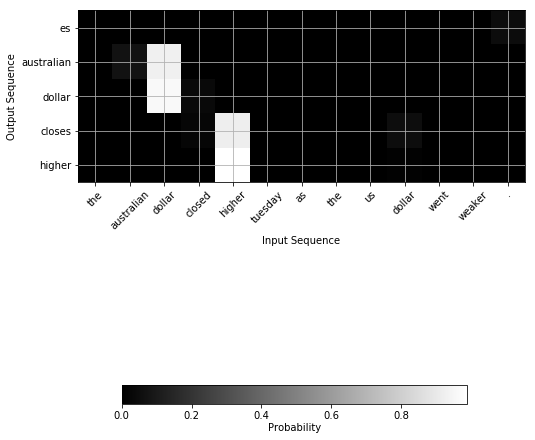

In [368]:
ind = good_list[0]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


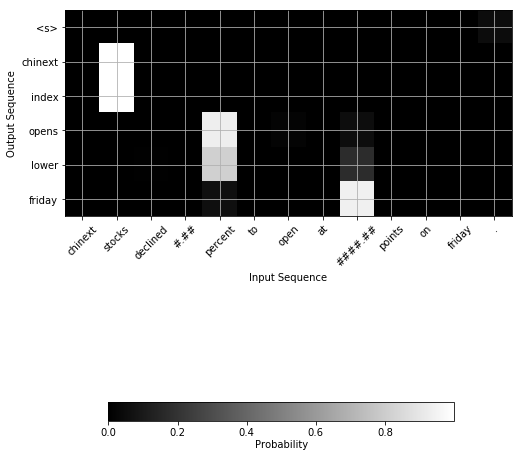

In [131]:
ind = good_list[1]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


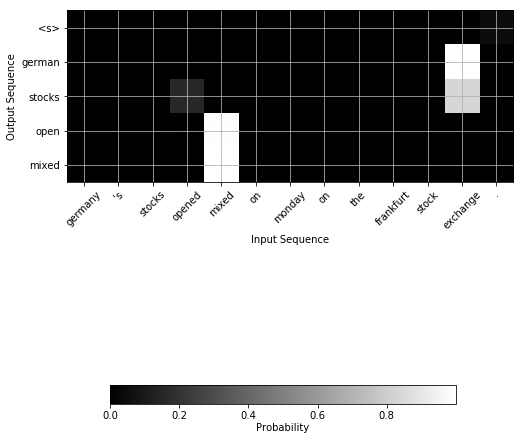

In [132]:
ind = good_list[2]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


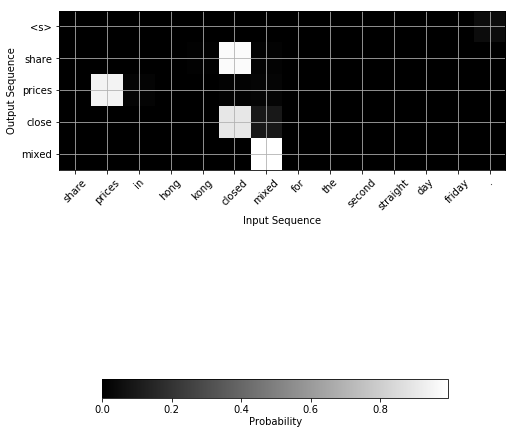

In [133]:
ind = good_list[3]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


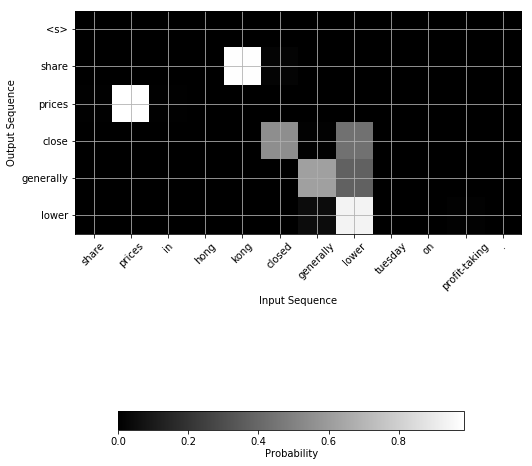

In [134]:
ind = good_list[4]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

## Bad Examples

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


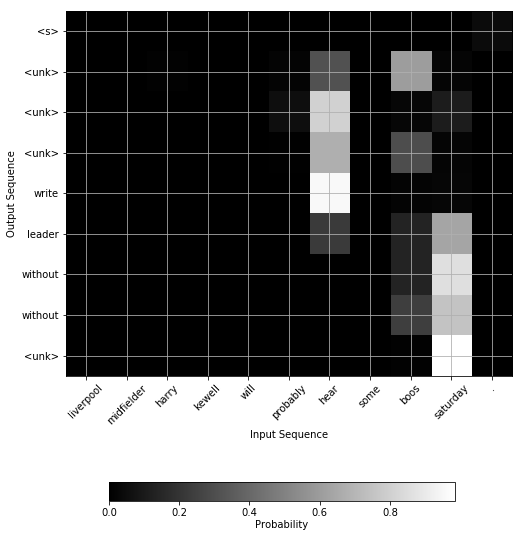

In [135]:
ind = bad_list[0]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


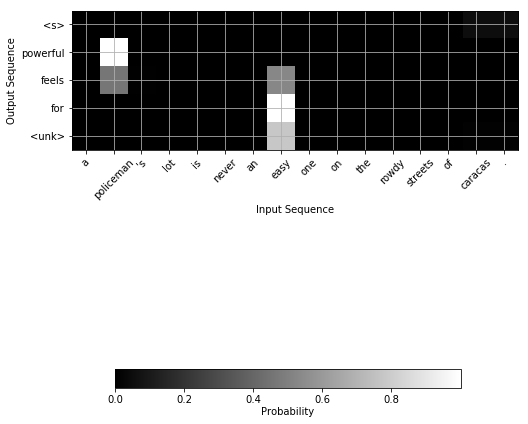

In [136]:
ind = bad_list[1]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


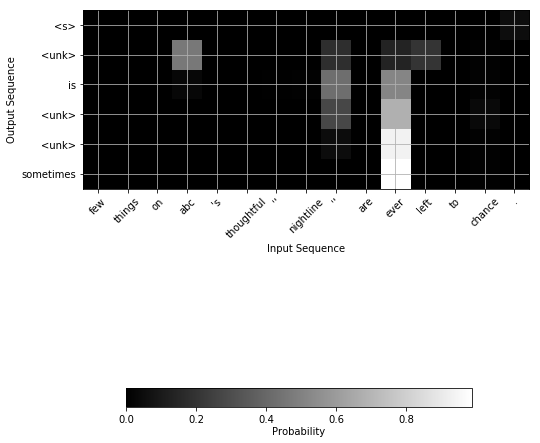

In [137]:
ind = bad_list[2]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


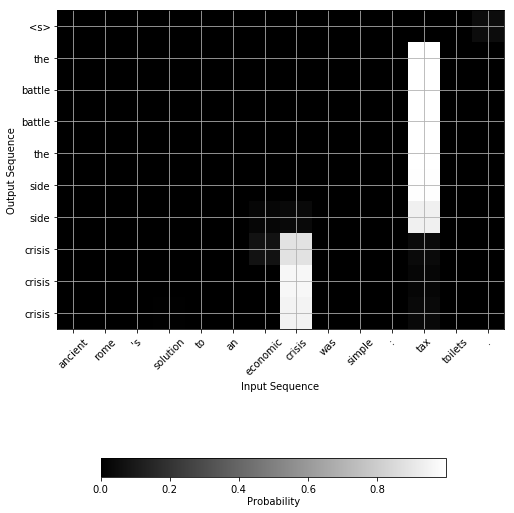

In [138]:
ind = bad_list[3]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


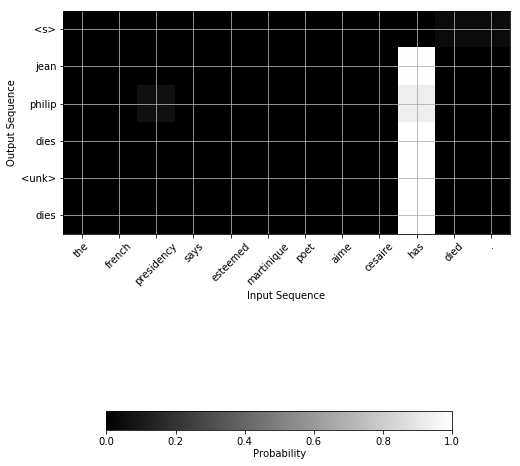

In [139]:
ind = bad_list[4]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

## Random Examples

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


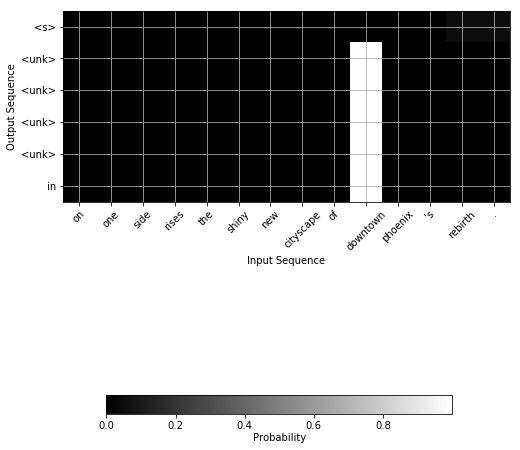

In [141]:
ind = rand_list[0]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


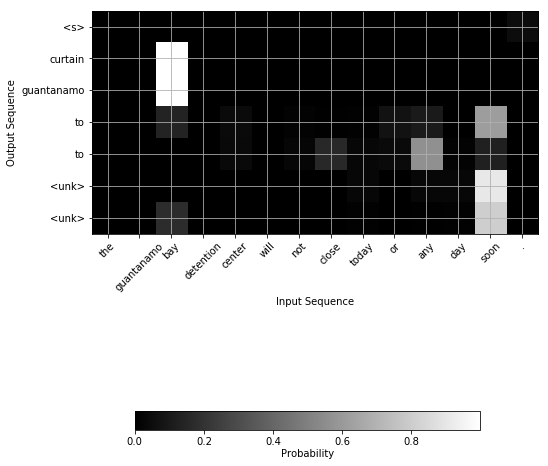

In [142]:
ind = rand_list[1]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


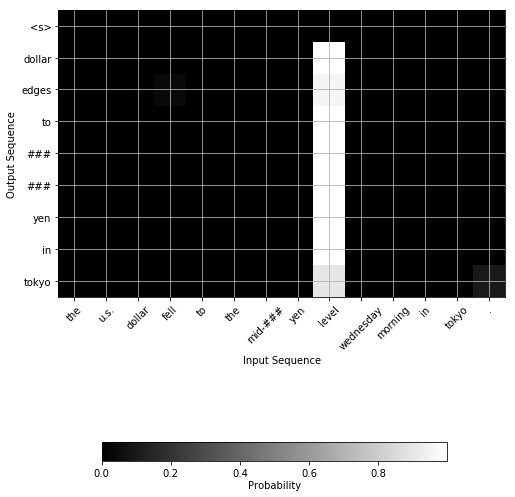

In [143]:
ind = rand_list[2]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


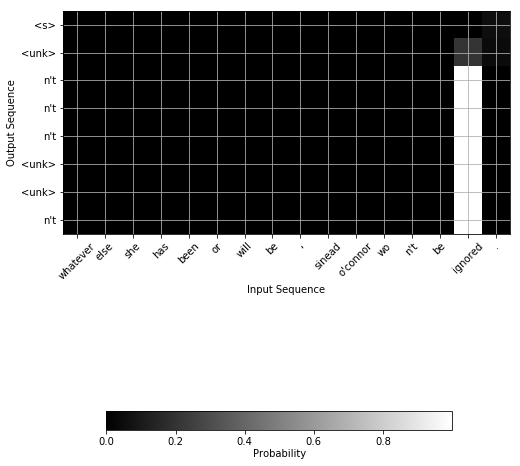

In [144]:
ind = rand_list[3]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


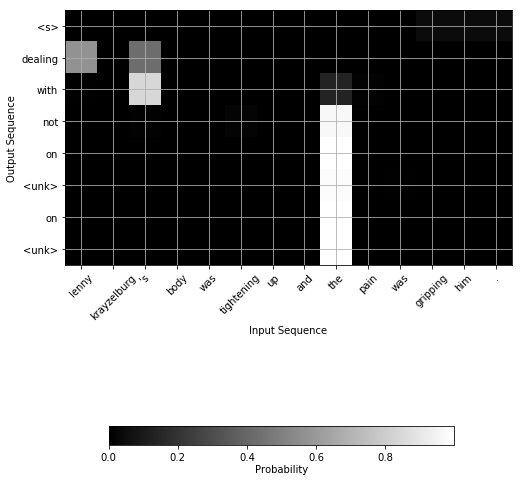

In [145]:
ind = rand_list[4]
text = test_article[ind]
test_data_vector = test_article_pad[ind].reshape(1,33)
viz.attention_map(text,test_data_vector,idx2word_sum)

In the attention map, whenever the model has a lighter color, it means that that that particular word on y-axis is correlated to word on x-axis. 

* Good Examples     
From the good examples, we found out most of them are related to finance such as stock, shares and market, since they are more structured compared to others. For the first sentence, the input sentence is "the australian dollar closed higher tuesday as the us dollar went weaker", while the predicted summary is "australian dollar closes higher". The word "dollar" in the input is correlated to the phrase "australian dollar" with "dollar" included, while "higher" predicts "closes higher", which maintains the original meaning.
Based on the second sentence, the first line of the article is “chinext stocks declined #.## points to open at #,###.## points on Friday”, while the decoded summary is “chinext index opens lower Friday”. We found out that the word “stocks” in the article corresponds to “chinext index” paraphrase in the output, which makes sense. The word “percent” is correlated to “opens lower”, while “####.##” is correlated to “Friday”. 
In the input sentence “germany’s stocks opened mixed on Monday on the Frankfurt stock exchange”, the phrase “open mixed” corresponds to “mixed” in the input. Moreover, “exchange” predicts “german stocks”, where it is more correlated to “german” than to “stocks”. But generally speaking, “stocks” should be more related to “exchange”.
In the fourth example, most of the words in the output are extracted from the input sequence. However, the word ”share” is correlated to “closed”, which is a little bit weird.
For the fifth sentence, this case is similar to the last sentence. Nevertheless, the “share” in the output corresponds “kong” from “hong kong”, a proper noun, which seems to be an issue. In addition, the verb phrase “close generally lower” all refers to the same word “lower”.

* Bad Examples    
From the attention weight plots of bad examples, there are always a bunch of words correlated by one or two words in the input, which suggests that the attention weights of the system does not work well for the examples. For instance, in the first sentence, there are a few unknown words predicted by the word "hear" in the input according the value of attention weights, while the two "without"s are predicted by "Saturday" in the article.     
In the second sentence, the first part of the output, "powerful feels" is predicted by the word "policeman", while the second half of the output get higher weight in the word "easy", which does not make much sense.   
For the third sentence, it is the word "ever" that gets the higher weight for most of the words in the output. 
For the fourth sentence, the three "crisis" in the end of the output are correlated to "crisis" in input, which demonstrates extraction from input. In addition, the first half of the input with some repetitive words, which is not syntactically
fluent, is softly aligned with the word "tax".    
For the fifth sentence, I found out the whole sentence is softly aligned with a single word "has". In conclusion, the soft alignment between the input and generated output does not seem reasonable.

* Random Examples   
From the random examples, the attention weights work well for some sentences, such as the second sentence "the guantanamo bay detention center will not close today or any day soon", where there is still a word "guantanamo" corresponded to the "bay" in the input. However, the attention map does not seem to apply well in the other sentences, like the first, third, fourth sentences, in which all the n-grams in th input are only correlated to a single word.


In [389]:
# load result data
with open("result_plain.txt") as f:
    result = f.readlines()
with open("result_attention.txt") as f:
    result_attention = f.readlines()

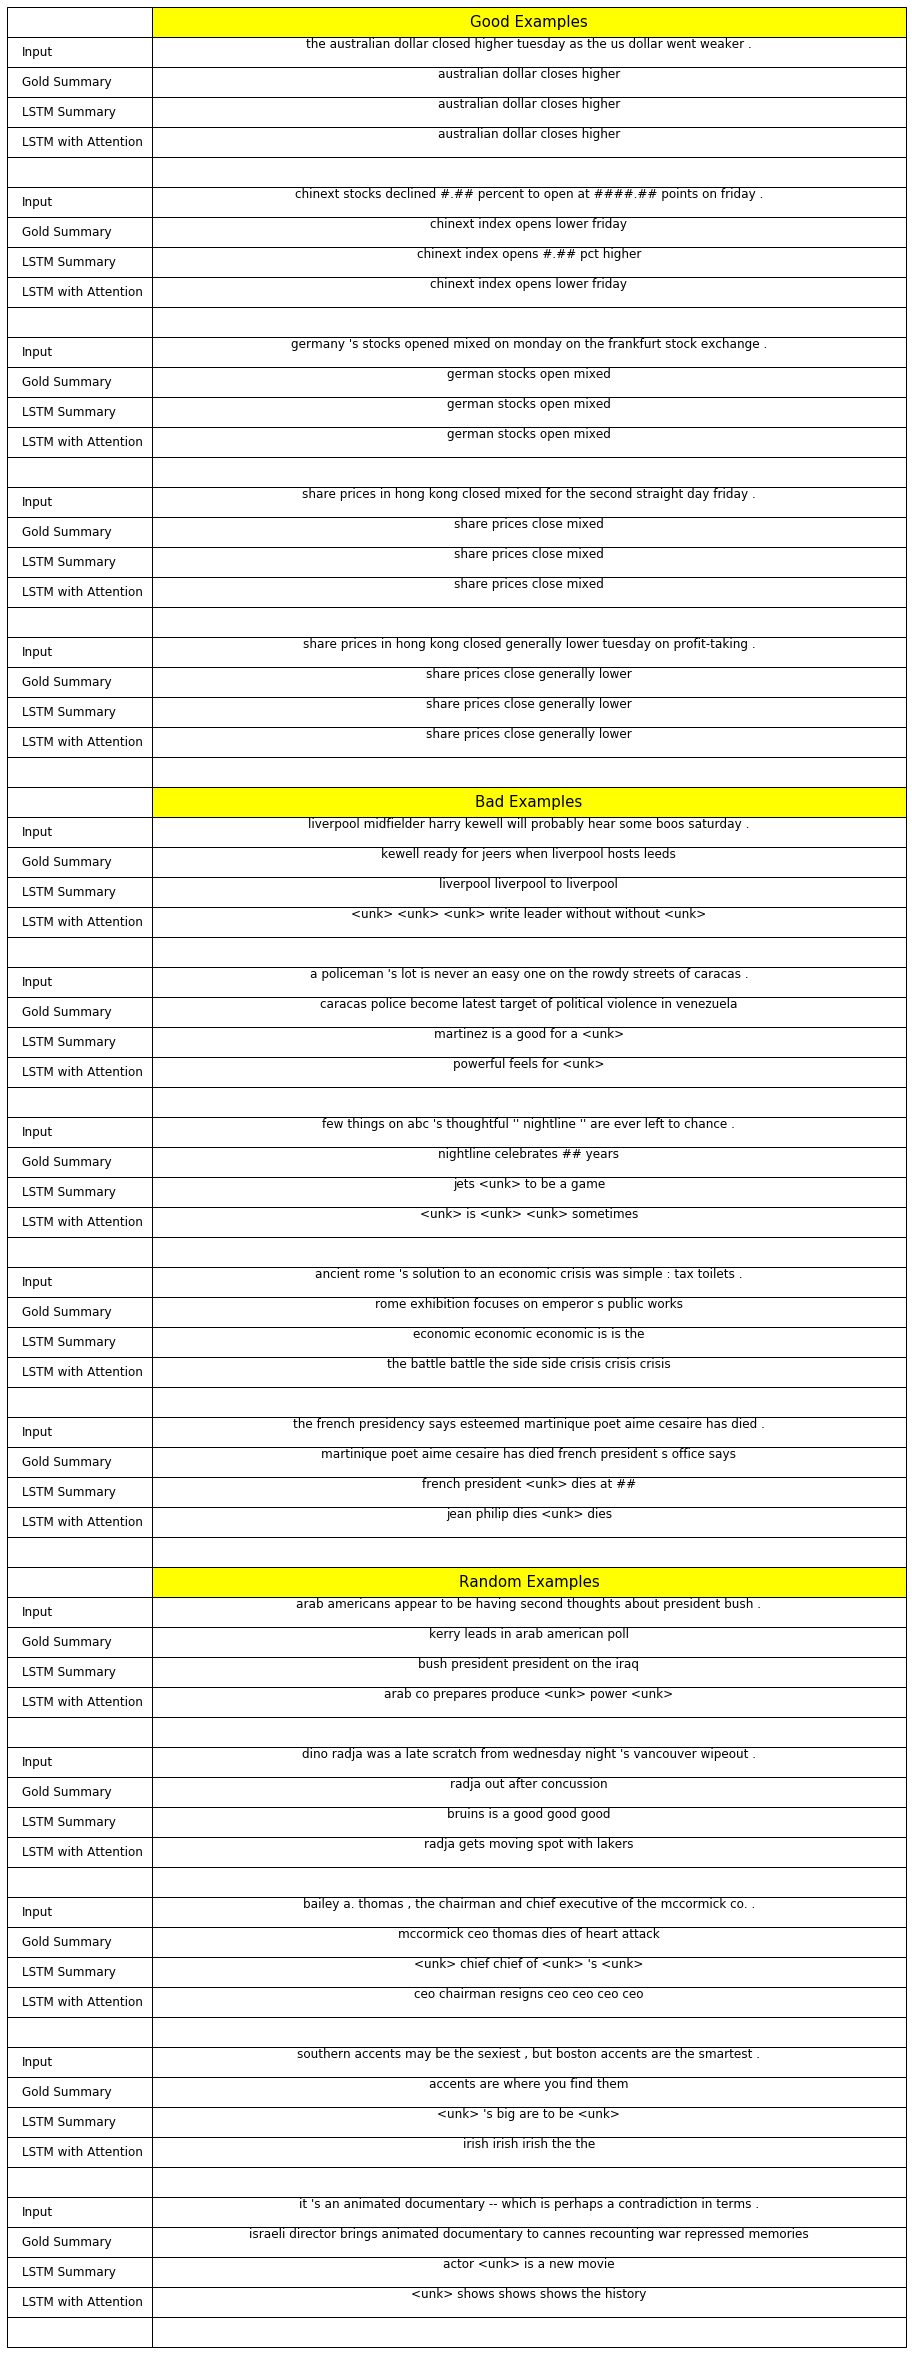

In [397]:
# create result table
clust_data = []
for i in (good_list + bad_list + rand_list):
    clust_data += [test_article[i], test_title[i], result[i], result_attention[i], ""]
clust_data.insert(0, "Good Examples")
clust_data.insert(26, "Bad Examples")
clust_data.insert(52, "Random Examples")
clust_data = np.array(clust_data).reshape(78,1)

rowlabel= [ "Input","Gold Summary", "LSTM Summary", "LSTM with Attention", ""] * 15
rowlabel.insert(0, "")
rowlabel.insert(26, "")
rowlabel.insert(52, "")

plt.axis('tight')
plt.axis('off')
the_table = plt.table(cellText=clust_data, cellLoc='center', colWidths = [1.5, 3.5],
                      rowLabels=rowlabel,loc='center')
the_table.scale(1.5, 2.5)
the_table.auto_set_font_size(False)
the_table.set_fontsize(12)

for i in [0, 26, 52]:
    the_table._cells[(i, 0)].set_facecolor("yellow")
    the_table._cells[(i, 0)].set_fontsize(15)
plt.show()

repetition of words,
ungrammaticality, syntactic problems such as attachment which make the resulting summary syntactically
fluent but semantically incorrect, reference issues (e.g., using pronouns that are not resolved or NP
references that are incorrect), wrong phrases dropped from the sentence, improper handling of proper
nouns, etc. Also note how much abstraction vs. extraction your system does. Is your system making
lexical substitutions, generalizing, compressing?

## Comparison with the Models
The plain lstm model I created is using the teacher forcing method to ignore the previous timestep predicted word, and instead use as input, the previous timestep word from gold title, which is usally better than the non teacher forcing method.   
In the second model, we used attention in the encoder-decoder model. Instead of decoding the input sequence into a single fixed context vector, the attention model develops a context vector that is filtered specifically for each output time step. From the paper, we know that each time the proposed model generates a word in a translation, it searches for a set of positions in a source sentence where the most relevant information is concentrated. The model then predicts a target word based on the context vectors associated with these source positions and all the previous generated target words.    

From the training evaluation process, we found out that attention model takes longer and more memory to train the model, but ideally it performs more accurate in generating the title summaries. It can be discovered and validated from the result table. Though the two models both perform well in sentences related to stock and finance, the model attention shows better result, as it is able to capture prep. and adv. phrases. For instance, in the second sentence for the good example, lstm model with attention has captured the prep. word "friday" from the input text, which provides more detail compared to the plain lstm model.
In terms of the abstraction vs. extraction, lstm with attention model are more likely to generate words and phrases that do not exist in the input. For example, in the random example "Bailey a. Thomas, the chairman and chief executive of the mccormick co", the model with attention is able to generate the occupation of the subject body, "ceo", from the input text phrases including "the chairman" and "chief executive". On the other hand, the plain lstm model tend to extract tokens from the input. In the sentence "the french presidency says esteemed martinique poet aime cesaire has died", the plain lstm model could extract the subject body of the sentence "french presidency", while the model with attention has generated a name "Jean-Philippe".  

From the decoded outputs, we do see some cases with lexical substitutions, generalizing and compressing, especially lexical substitutions. In some financial-related articles, "lower" is replaced with "down", while "share" is substituted by "stock". For instance, the title "london share prices down at midday" is predicted by the article "share prices on the london stock exchange were lower at midday thursday", where the original "lower" has changed to the word "down" with the lexical and sementical meaning remaining the same. In terms of generalizing and compression, for the article "germany 's benchmark stock index gained , boosted by thyssen ag and fried", it got truncated the second half part, just retaining the major impact of the sentence "germany 's stock index gained", regardless of the plain lstm model or model with attention. 

## Problems and Proposal  
1) Problems

There are a few issues appearing the summarization process including ungrammaticality, repetition of words, reproducing factual details inaccurately, and wrong sentence parsing, out of which the issue of repetition of words is the most severe one. For example, for the fourth article-summary pair, we have a bunch of "economic" and "is" in the decoded output from plain lstm model, while we have three words "battle", "side" and "crisis" repeated in the summary predicted by the model with attention. 

In terms of incorrect sentence parsing, in the article "the french presidency says esteemed martinique poet aime cesaire has died", both models captured the meaning "the french president dies", which is obviously wrong, since the misunderstood the verb phrase "has died" should be attached after the proper name "aime cesaire" instead of "french president".
As for ungrammaticality, it takes place all the time if the articles are not financial or not structured enough. In the article "it 's one of the oldest rivalries in soccer : belgium vs. the netherlands", the reference title should be "<unk> rivalries rarely get any better or older than", while we predicted "italy defeats growth doubles italy in italy in denmark cup netherlands", which is grammatically incorrect. 
    
   In addition, we have summaries syntactically fluent but semantically incorrect.
In the second sentence from the random examples, we get "radjia gets moving spots with lakers" from the model with impact, which is significantly different from its original meaning. 

   Last but not least, we have cases, which predict the location, time and change completely different or even opposite in the output. For the article "this is the cox news service spot news budget for friday , june # , ####", both of the models capture the main body "the news service service news budget". Furthermore, the attention model even generates the time and date, but unfortunately the time it predicted is Thursday not Friday.

2) Proposal      
Since the problem of repetition of words is the most severe one, I come up with a few approaches to deal with it. Repetition may be caused by the decoder’s over-reliance on the decoder input (i.e. previous summary word), rather than storing longer-term information in the decoder state. This can be seen by the fact that a single repeated word commonly triggers an endless repetitive cycle. 
To tackle repetitive summaries, we could use a technique called coverage, which is also used in the state of the art model for summarization, Pointer Generator. The idea is that we use the attention distribution to keep track of what’s been covered so far, and penalize the network for attending to same parts again. 
On each timestep t of the decoder, the coverage vector $c^{{t}}$ is the sum of all the attention distributions $a^{{t}}$.

In other words, the coverage of a particular source word is equal to the amount of attention it has received so far.
$$c^{{t}} = \sum_{t=0}^{t-1}a^{{t}} $$
Lastly, we introduce an extra loss term to penalize any overlap between the coverage vector and the new attention distribution:
In this way, it discourages the network from attending to anything that is already been covered.
$$covloss_{t} = \sum_{i}min(a_{i}^{{t}},c_{i}^{{t}})  $$

## Reference
[lstm seq2seq](https://github.com/fchollet/keras/blob/master/examples/lstm_seq2seq.py)      
[pointer generator](http://www.abigailsee.com/2017/04/16/taming-rnns-for-better-summarization.html)


# Unidirectional LSTM Encoder Decoder With Attention and Beam Search (Extra Credit)

The models that you implemented till now had greedy decoder. Now implement a Decoder with Beam Search and show improved results